# Tarea Minería de Datos

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import scipy.stats as stats

from pandas.plotting import autocorrelation_plot

import statsmodels.tsa.holtwinters as ets
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import pmdarima as pm

In [2]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from psynlig import pca_scree
from psynlig import pca_explained_variance_pie

from psynlig import (
    pca_explained_variance,
    pca_residual_variance,
    pca_explained_variance_bar,
    pca_explained_variance_pie,
    pca_1d_loadings,
    pca_2d_loadings,
    pca_2d_scores
)

In [3]:
from NuestrasFunciones import *
import NuestrasFunciones

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Ejercicio 1

#### 1. Reporte descriptivo de los datos. Dimensiones del dataset, número de variables continuas y categóricas. Distribuciones. Comentarios generales.

Lectura de datos

In [5]:
df_fev = pd.read_csv(r'FEV_data.csv')
df_fev.head()

seqnbr  subjid  age    fev  height  sex  smoke
0       1     301    9  1.708    57.0    2      2
1       2     451    8  1.724    67.5    2      2
2       3     501    7  1.720    54.5    2      2
3       4     642    9  1.558    53.0    1      2
4       5     901    9  1.895    57.0    1      2

In [6]:
df_fev.describe()

seqnbr        subjid         age         fev      height  \
count  654.00000    654.000000  654.000000  654.000000  654.000000   
mean   327.50000  37169.571865    9.931193    2.636780   61.143578   
std    188.93782  23690.860350    2.953935    0.867059    5.703513   
min      1.00000    201.000000    3.000000    0.791000   46.000000   
25%    164.25000  15811.000000    8.000000    1.981000   57.000000   
50%    327.50000  36071.000000   10.000000    2.547500   61.500000   
75%    490.75000  53638.500000   12.000000    3.118500   65.500000   
max    654.00000  90001.000000   19.000000    5.793000   74.000000   

              sex       smoke  
count  654.000000  654.000000  
mean     1.486239    1.900612  
std      0.500193    0.299412  
min      1.000000    1.000000  
25%      1.000000    2.000000  
50%      1.000000    2.000000  
75%      2.000000    2.000000  
max      2.000000    2.000000

In [7]:
df_fev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seqnbr  654 non-null    int64  
 1   subjid  654 non-null    int64  
 2   age     654 non-null    int64  
 3   fev     654 non-null    float64
 4   height  654 non-null    float64
 5   sex     654 non-null    int64  
 6   smoke   654 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 35.9 KB


In [8]:
df_fev.shape

(654, 7)

El dataset tiene 654 entradas, 7 variables y no hay valores missing. Según el .info() todas las variables son numéricas, voy a evaluar la cantidad de valores únicos que tiene cada una de las variables.

In [9]:
df_fev.nunique()

seqnbr    654
subjid    654
age        17
fev       575
height     56
sex         2
smoke       2
dtype: int64

Se puede ver que las variables sex y smoke tienen solo 2 valores unicos, y por su descripción podemos saber que son categóricas. Por ende el siguiente paso sería cambiar el tipo de estas variables a category.

In [10]:
to_factor = list(df_fev.loc[:,df_fev.nunique() <= 10]);
df_fev[to_factor] = df_fev[to_factor].astype('category')
df_fev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   seqnbr  654 non-null    int64   
 1   subjid  654 non-null    int64   
 2   age     654 non-null    int64   
 3   fev     654 non-null    float64 
 4   height  654 non-null    float64 
 5   sex     654 non-null    category
 6   smoke   654 non-null    category
dtypes: category(2), float64(2), int64(3)
memory usage: 27.2 KB


Así tengo 5 variables continuas (seqnbr, subjid, age, fev y height) y dos categóricas (sex y smoke). 

Ahora paso a la representación gráfica de las distribuciones de cada variable. Para las variables numéricas graficaré el histograma al igual que el box plot.

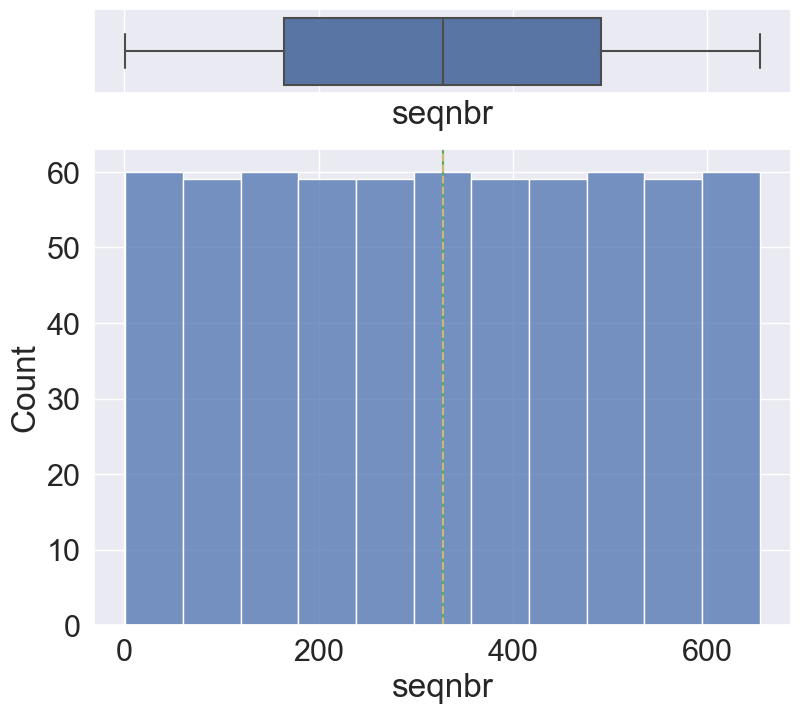

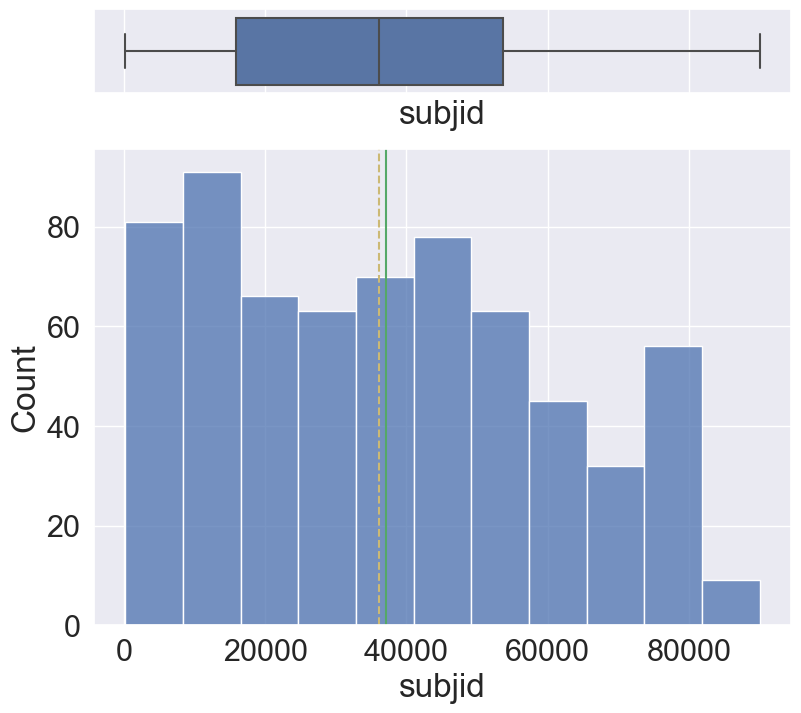

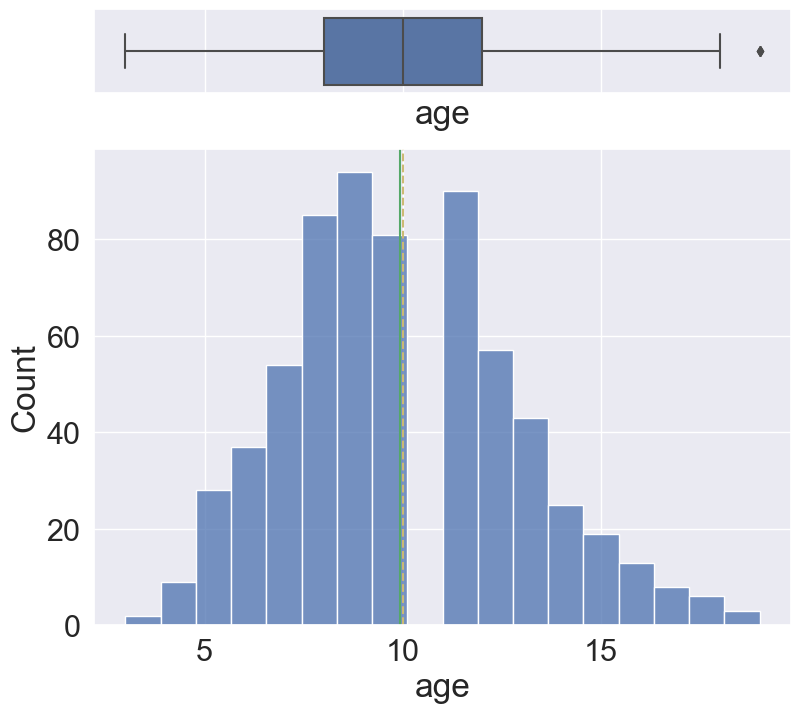

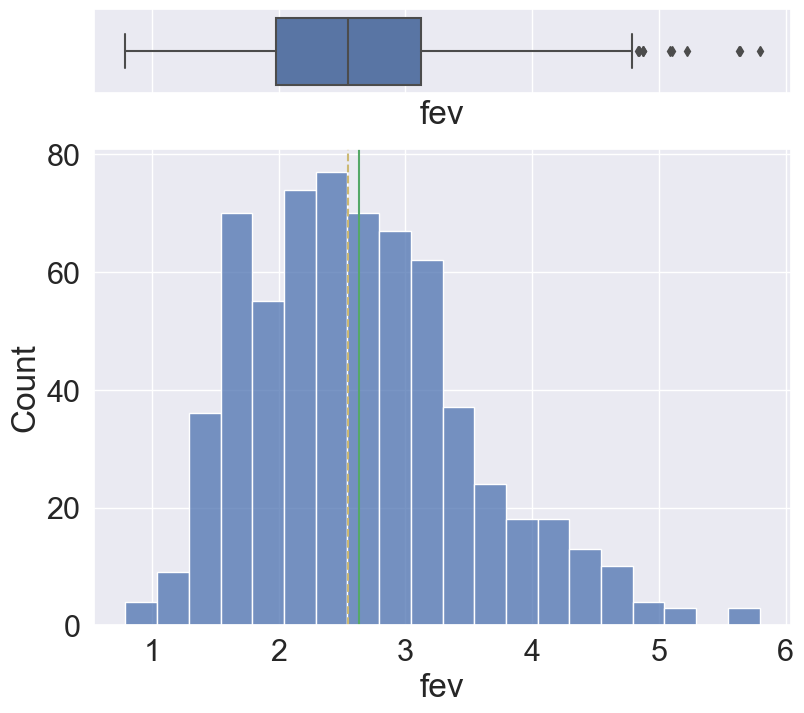

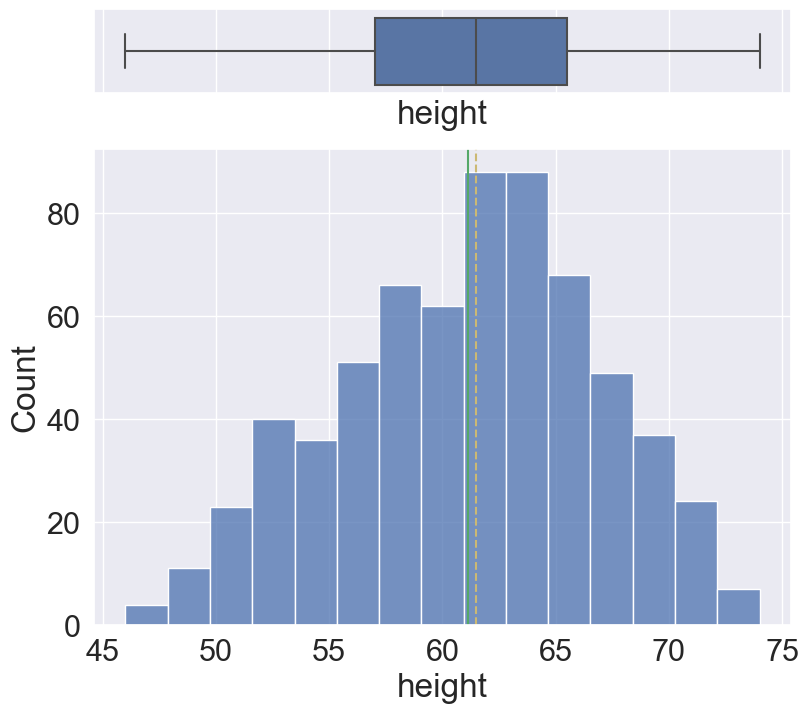

seqnbr    None
subjid    None
age       None
fev       None
height    None
dtype: object

In [11]:
df_fev[['seqnbr','subjid','age','fev','height']].apply(histogram_boxplot)

Las distribuciones de las variables numéricas se asemejan a la distribución normal, con la media y la mediana muy similares.

Fev es la variable con más outliers, y le sigue age con un solo outlier que sería la observación que tiene 19 años.

In [12]:
cat_plot(df_fev.sex)

En cuanto a la varibale sex se podría decir que la muestra está balanceada, tenemos casi la misma cantidad de observaciones del sexo masculino como del sexo femenino.

In [13]:
cat_plot(df_fev.smoke)

En cuanto a la variable smoke hay un desbalance importante, dado que hay 589 observaciones que no fuman contra 65 que si lo hacen.

Voy a corroborar si necesito hacer depuración de los datos. Del .info() sabemos que no hay valores missing para ninguna de las variables, voy a mirar si hay outliers extremos.

In [14]:
df_fev.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))

seqnbr
subjid
age
fev
height


seqnbr  subjid  age  fev  height
0     0.0     0.0  0.0  0.0     0.0
1     0.0     0.0  0.0  0.0     0.0
2     0.0     0.0  0.0  0.0     0.0

Si bien en los garficos de boxplot anteriores aparecía que las variables fev y age tienen outliers podemos saber que ninguno de estos valores son outliers extremos por lo que no es necesario hacer gestión de outliers. 

#### 2. Decide si se descarta de inicio alguna de las variables de cara al modelado.

Como siguiente paso descartaré las variables seqnbr y subjid para la etapa de modelado dado que son identificatorias y no aportan información sustancial para explicar el comportamineto de la variable objetivo.

In [15]:
df2_fev = df_fev.drop(['seqnbr','subjid'],axis=1)
df2_fev.head()

age    fev  height sex smoke
0    9  1.708    57.0   2     2
1    8  1.724    67.5   2     2
2    7  1.720    54.5   2     2
3    9  1.558    53.0   1     2
4    9  1.895    57.0   1     2

#### 3. Ajusta el mejor modelo de regresión lineal con variables originales y sin interacciones entre las variables.

Antes de hacer la regresión voy a cambiar los valores de la variable smoke para que "no" sea 0 y "yes" sea 1. Además cambio los valores de la variable sex para que "1" sea male y "0" sea female.

In [16]:
df2_fev.smoke.replace(2,0,inplace=True)
df2_fev.sex.replace(2,0,inplace=True)
df2_fev.head()

age    fev  height sex smoke
0    9  1.708    57.0   0     0
1    8  1.724    67.5   0     0
2    7  1.720    54.5   0     0
3    9  1.558    53.0   1     0
4    9  1.895    57.0   1     0

Previo a plantear el primer modelo voy a sacar la matriz de correlación para tener una mejor idea sobre qué variables tienen mayor correlación con mi variable objetivo.

In [17]:
corr = df2_fev.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

En el lado positivo, la variable fev tiene correlaciones altas con todas las variables numéricas explicativas. Sin embargo, también se observa correlación alta entre las variables explicativas age y height, lo cual puede traer problemas de colinelidad en el modelo. 

Ahora, de cara al modelado, guardo la variable objetivo, fev, en un dataframe aparte y creo otro dataframe llamaoa fev_model que contiene solo las variables explicativas. 

In [18]:
varObjCont = df2_fev.fev
fev_model = df2_fev.drop(['fev'], axis=1)

Evaluo la importancia del efecto que tiene cada una de las varibales explicativas sobre la variable objetivo ultilizando la V de Cramer.

In [19]:
tablaCramer = pd.DataFrame(fev_model.apply(lambda x: cramers_v(x,varObjCont)),columns=['VCramer'])

px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente al FEV').update_yaxes(categoryorder="total ascending")

Podemos ver que las dos variables explicativas con mayor efecto son height y age, y en caso de que decida quedarme solo con una de estas variables por la alta correlación que existe entre ellas me quedaría con height.

Separo la muestra entre training y test para tener datos para entrenar el modelo y datos para luego validarlo. Dejo el 80% de los datos para el entrenamiento y 20% para el testeo.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(fev_model, varObjCont, test_size=0.2, random_state=42)

print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (523, 4) (523,)
Testing dataset shape: (131, 4) (131,)


In [21]:
data_train = X_train.join(y_train)
data_train.head()

age  height sex smoke    fev
321   12    71.0   1     0  4.550
456   12    68.0   1     0  4.411
340   10    62.0   1     0  1.937
29     9    60.0   0     0  2.100
570   10    65.0   1     0  3.090

Como primer modelo voy a utilizar todas las variables explicativas, a partir de este modelo iré descartando las variables que no sean significativas en la modalidad backwards.

In [22]:
modelo1 = ols('fev ~ age + height + sex + smoke',data=data_train).fit()
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     423.4
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          1.09e-161
Time:                        20:10:23   Log-Likelihood:                -281.13
No. Observations:                 523   AIC:                             572.3
Df Residuals:                     518   BIC:                             593.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3576      0.271    -16.067      0.000      -4.890      -3.825
sex[T.0]      -0.1511      0.038     -4.028      0.000      -0.225      -0.077
smoke[T.0]     0.0652      0.066      0.983      0.326      -0.065       0.196
age            0.0632      0.011      5.678      0.000       0.041       0.085
height         0.1041      0.005     19.150      0.000       0.093       0.115
==============================================================================
Omnibus:                       11.617   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.038
Skew:                           0.178   Prob(JB):                     0.000200
Kurtosis:                       3.810   Cond. No.                         932.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

El R cuadrado ajustado para este modelo es de 0.764, lo cual significa que mis varaibles explicativas logran explicar el 76,4% de la variabilidad de la variable objetivo. 

Por otro lado la variable smoke es la única que no resulta significativa conisderando un nivel de significatividad del 95% (alpha de 0.05). Esto resulta sorprendente ya que uno pensaría que el hecho de fumar tendría un impacto mayor sobre el volumen respiratorio. La lógica que podríamos encontrar es que al tratarse de un muestra de niños, al ser jóvenes los efectos negativos de fumar no han afectado aún su capacidad respiratoria.

Hay que tener en cuenta que para este modelo incluí ambas variables height y age que sabemos que están correlacionadas entre sí. 

Antes de eliminar variables por su significatividad quiero probar como funciona el modelo utilizando solo una de las variables height y age dada su alta correlación, no quiero que la colinelidad afecte los resultados y de esta forma puedo aislar sus efectos. 

Empiezo con el modelo 2, que tiene solo la variable height. 

In [23]:
modelo2 = ols('fev ~ height + sex + smoke',data=data_train).fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     522.3
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          2.67e-156
Time:                        20:10:23   Log-Likelihood:                -296.91
No. Observations:                 523   AIC:                             601.8
Df Residuals:                     519   BIC:                             618.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.1260      0.242    -21.181      0.000      -5.601      -4.651
sex[T.0]      -0.1195      0.038     -3.127      0.002      -0.195      -0.044
smoke[T.0]    -0.0408      0.066     -0.622      0.534      -0.170       0.088
height         0.1282      0.003     36.779      0.000       0.121       0.135
==============================================================================
Omnibus:                       16.177   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.946
Skew:                           0.163   Prob(JB):                     3.14e-07
Kurtosis:                       4.126   Cond. No.                         802.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

El R cuadrado ajustado baja a 0.75, lo cual no es un efecto negativo tan grande. A su vez, smoke sigue sin ser significativa con un alpha de 0.05. 

En el modelo 3 puebo utilizando solo la variable age y se ve que los resultados sufren más que en el caso anterior. El R cuadrado baja a 0.6 y el AIC y BIC suben significativamente, lo cual indica que las variables seleccionadas como explicativas no logran explicar el comportamineto de la variable objetivo tan bien como las anteriores. Por otro lado, la variable smoke sigue sin ser significativa con un alpha de 0.05.

In [24]:
modelo3 = ols('fev ~ age + sex + smoke',data=data_train).fit()
modelo3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     259.4
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          8.00e-103
Time:                        20:10:23   Log-Likelihood:                -421.11
No. Observations:                 523   AIC:                             850.2
Df Residuals:                     519   BIC:                             867.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3748      0.146      2.568      0.011       0.088       0.661
sex[T.0]      -0.3132      0.048     -6.561      0.000      -0.407      -0.219
smoke[T.0]     0.1278      0.087      1.477      0.140      -0.042       0.298
age            0.2300      0.009     25.398      0.000       0.212       0.248
==============================================================================
Omnibus:                       12.341   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.298
Skew:                           0.314   Prob(JB):                      0.00130
Kurtosis:                       3.465   Cond. No.                         71.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Para el modelo 4 vuelvo a las bases del modelo 1 y quito la variable smoke que había resultado no ser significativa. En este caso vemos que el R cuadrado ajustado no se ve afectado y todas las variables resultan significativas. 

In [25]:
modelo4 = ols('fev ~ age + height + sex',data=data_train).fit()
modelo4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     564.2
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          6.86e-163
Time:                        20:10:23   Log-Likelihood:                -281.61
No. Observations:                 523   AIC:                             571.2
Df Residuals:                     519   BIC:                             588.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2829      0.260    -16.450      0.000      -4.794      -3.771
sex[T.0]      -0.1540      0.037     -4.117      0.000      -0.227      -0.081
age            0.0601      0.011      5.629      0.000       0.039       0.081
height         0.1043      0.005     19.223      0.000       0.094       0.115
==============================================================================
Omnibus:                       11.573   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.840
Skew:                           0.155   Prob(JB):                     0.000134
Kurtosis:                       3.850   Cond. No.                         892.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Para el modelo 5 pruebo solo con las variables height y sex, eliminando smoke como en el modelo anterior y también la variable age por su alta correlación con la variable height. Esta decisión la tomo teniendo en cuenta que como probamos en los modelo 2 y 3, el modelo es mejor si conservo la variable height sobre age. 

De los resultados vemos que el R cuadrado ajustado no cambia con respecto al modelo 2 y todas las variables resultan significativas. De todos los modelos probados en este punto me quedaría con este ya que todas las variables resultan significativas, el R cuadrado es bueno y me aseguro de que no estoy incluyendo variables que pueden traer problemas de colinealidad. 

In [26]:
modelo5 = ols('fev ~ height + sex',data=data_train).fit()
modelo5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     784.2
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          1.02e-157
Time:                        20:10:23   Log-Likelihood:                -297.11
No. Observations:                 523   AIC:                             600.2
Df Residuals:                     520   BIC:                             613.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.2022      0.209    -24.931      0.000      -5.612      -4.792
sex[T.0]      -0.1165      0.038     -3.075      0.002      -0.191      -0.042
height         0.1288      0.003     38.588      0.000       0.122       0.135
==============================================================================
Omnibus:                       16.211   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.479
Skew:                           0.173   Prob(JB):                     3.97e-07
Kurtosis:                       4.111   Cond. No.                         685.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 4. Ajusta el mejor modelo de regresión lineal con variables originales y con interacciones entre las variables que resulten relevantes.

Para las interacciones voy a probar un modelo que intruduzca la multiplicacion entre height y sex.

In [27]:
modelo_int1 = ols('fev ~ height*sex',data=data_train).fit()
modelo_int1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     542.1
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          1.85e-159
Time:                        20:10:23   Log-Likelihood:                -289.58
No. Observations:                 523   AIC:                             587.2
Df Residuals:                     519   BIC:                             604.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.7718      0.253    -22.852      0.000      -6.268      -5.276
sex[T.0]            1.5332      0.425      3.605      0.000       0.698       2.369
height              0.1380      0.004     34.062      0.000       0.130       0.146
height:sex[T.0]    -0.0271      0.007     -3.894      0.000      -0.041      -0.013
==============================================================================
Omnibus:                       10.502   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               16.405
Skew:                           0.122   Prob(JB):                     0.000274
Kurtosis:                       3.833   Cond. No.                     1.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Se ve que el R cuadrado para este modelo mejora con respecto al anterior, pasa de 0.75 a 0.757. Además la ineracción entra ambas variables resulta significativa.

Como último modelo voy a probar utilizando como variable objetivo el logarítmo de la variable fev. Vemos que el R cuadrado ajustado aumenta de 0.75 a 0.786 pero la variable sex ya no resulta significativa. Este modelo funcionaría igual de bien con la variable height como única variable explicativa.

In [28]:
modelo_int2 = ols('np.log(fev) ~ height+sex',data=data_train).fit()
modelo_int2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(fev)   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     958.5
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          3.81e-175
Time:                        20:10:23   Log-Likelihood:                 242.18
No. Observations:                 523   AIC:                            -478.4
Df Residuals:                     520   BIC:                            -465.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2235      0.074    -29.882      0.000      -2.370      -2.077
sex[T.0]      -0.0142      0.014     -1.048      0.295      -0.041       0.012
height         0.0513      0.001     43.129      0.000       0.049       0.054
==============================================================================
Omnibus:                       37.896   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.571
Skew:                          -0.550   Prob(JB):                     1.41e-12
Kurtosis:                       4.138   Cond. No.                         685.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 5- Comparación de ambos modelos por validación cruzada repetida. ¿Cuál de ellos tiene mejor comportamiento en generalización?

In [29]:
form1 = 'fev ~ age + height + sex + smoke'
form2 = 'fev ~ height + sex + smoke'
form3 = 'fev ~ height + sex'
form4 = 'fev ~ height*sex'
form5 = 'np.log(fev)~ height + sex'

# Creamos lista de fórmulas   
list_form = [form1,form2,form3,form4,form5]
list_form

# Aplicamos a toda la lista la función creada (devuelve un dataframe pero está transpuesto)
list_res = pd.DataFrame(map(lambda x: cross_val_lin(x,df2_fev, seed=2022),list_form))

# Trasnponer dataframe y pasar de wide a long (creando un factor variable con el nombre de cada fórmula de la lista[0,1,2,3])
results = list_res.T.melt()
results.columns = ['Modelo','R2']

Modelo: fev ~ age + height + sex + smoke
Coeficiente de determinación R2: 0.767 (0.030)
Modelo: fev ~ height + sex + smoke
Coeficiente de determinación R2: 0.751 (0.033)
Modelo: fev ~ height + sex
Coeficiente de determinación R2: 0.752 (0.033)
Modelo: fev ~ height*sex
Coeficiente de determinación R2: 0.759 (0.032)
Modelo: np.log(fev)~ height + sex
Coeficiente de determinación R2: 0.791 (0.032)


De la validación cruzada sale que el mejor modelo es el que tiene como variable objetivo el logaritmo de fev con las variables explicativas height y sex. Este sería el modelo con el que me quedaría ya que eliminé las variables que correlacionaban entre sí y la variable smoke que no era significativa. 

<AxesSubplot:xlabel='Modelo', ylabel='R2'>

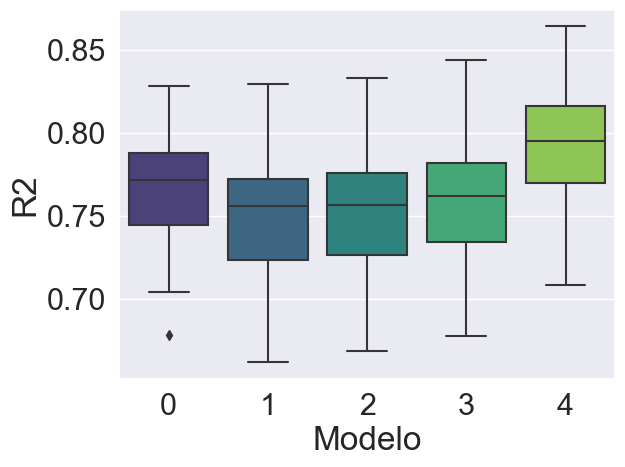

In [30]:
sns.boxplot(x='Modelo',y='R2',data=results,palette='viridis')

# Ejercicio 2

#### 1. Lectura y representación de la serie. Descomposición. Conclusiones.

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
defunciones = pd.read_excel(r'defunciones.xlsx')
defunciones.head()

Todas las causas  Tumores  Causas externas
0      1980M01             28681     4883             1277
1      1980M02             23906     4493             1122
2      1980M03             25275     4957             1244
3      1980M04             22500     4523             1214
4      1980M05             22781     4893             1228

Puedo ver en la salida anterior que la primera columna consiste de fechas con el formato año-mes, pero el año y el mes están separados por una "M", y así pandas no lo reconoce como fecha. A continuación reemplazo la "M" por "-" y así será identificado como fecha. La columna con las fechas la nombro "Month".

In [33]:
defunciones['Month'] = defunciones.iloc[:,0].apply(lambda x: x.replace('M','-'))

defunciones = defunciones.iloc[:,1:]
defunciones.head()

Todas las causas  Tumores  Causas externas        Month
0             28681     4883             1277      1980-01
1             23906     4493             1122      1980-02
2             25275     4957             1244      1980-03
3             22500     4523             1214      1980-04
4             22781     4893             1228      1980-05

Ahora convierto la columna "Month" en el índice de mi data frame para poder hacer la serie temporal. Tambien elijo la variable tumores como la variable ojetivo, así que creo un nuevo data frame llamado "tumores_data" que tiene solo el índice y la variable "tumores". Finalmente, grafico la serie temporal.

In [34]:
defunciones.set_index(['Month'],inplace=True)
defunciones.index=pd.to_datetime(defunciones.index)
defunciones.head()

Todas las causas  Tumores  Causas externas
Month                                                 
1980-01-01             28681     4883             1277
1980-02-01             23906     4493             1122
1980-03-01             25275     4957             1244
1980-04-01             22500     4523             1214
1980-05-01             22781     4893             1228

In [35]:
tumores_data = defunciones[['Tumores']]
tumores_data.head()

Tumores
Month              
1980-01-01     4883
1980-02-01     4493
1980-03-01     4957
1980-04-01     4523
1980-05-01     4893

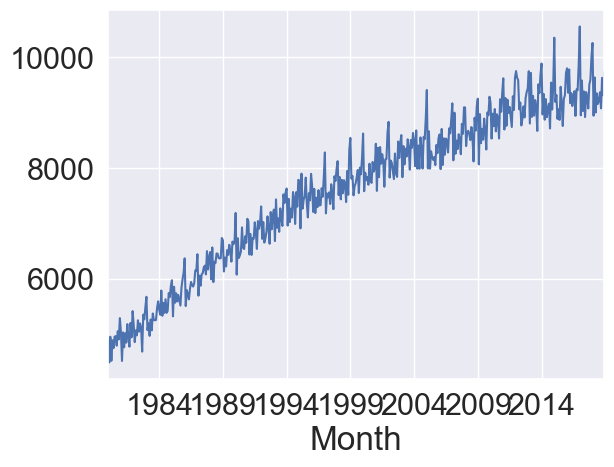

In [36]:
tumores_data.Tumores.plot()
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

Del gráfico de arriba puedo ver que la serie no es estacionaria, dado que tiene tendencia ascendente. Voy a relaizar el test de Dickey-Fuller para testear la estacionareidad. Recordar que el test de Dickey-Fuller tiene como hipótesis nula que la serie no es estacionaria.

In [37]:
test_stationarity(tumores_data.Tumores)

Results of Dickey-Fuller Test:
Test Statistic                  -3.913292
p-value                          0.001939
#Lags Used                      11.000000
Number of Observations Used    456.000000
Critical Value (1%)             -3.444772
Critical Value (5%)             -2.867899
Critical Value (10%)            -2.570157
dtype: float64


El pvalor del test sale muy bajo, por ende rechazaría la hipotesis nula del test y eso indicaría que la serie sea estacionaria. Sin embargo podemos ver en el gráfico de arriba que esto no es así ya que la serie tiene tendencia.

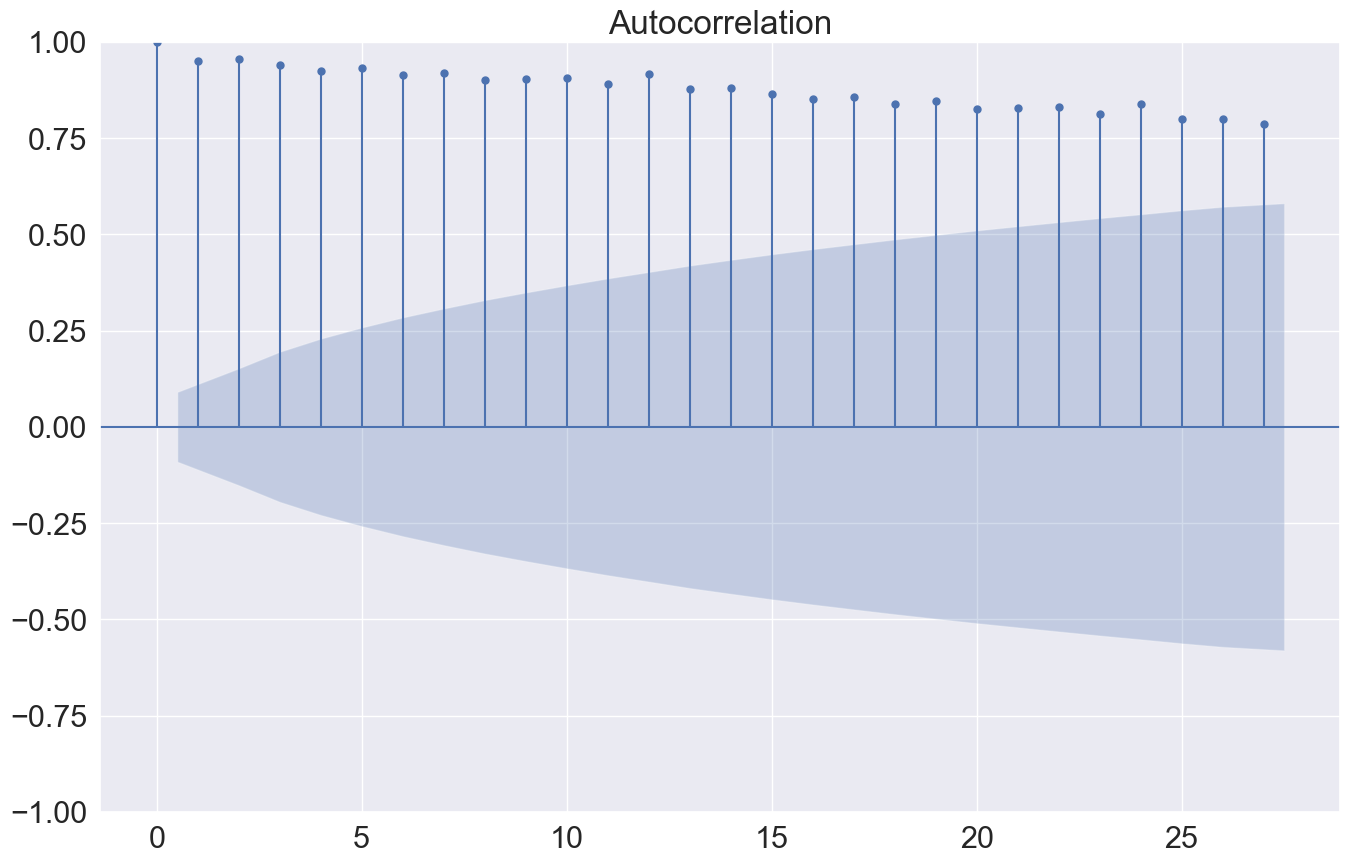

In [38]:
plot_acf(tumores_data.dropna(inplace=False))
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

##### Descomposición

Comienzo haciendo la descomposición aditiva.

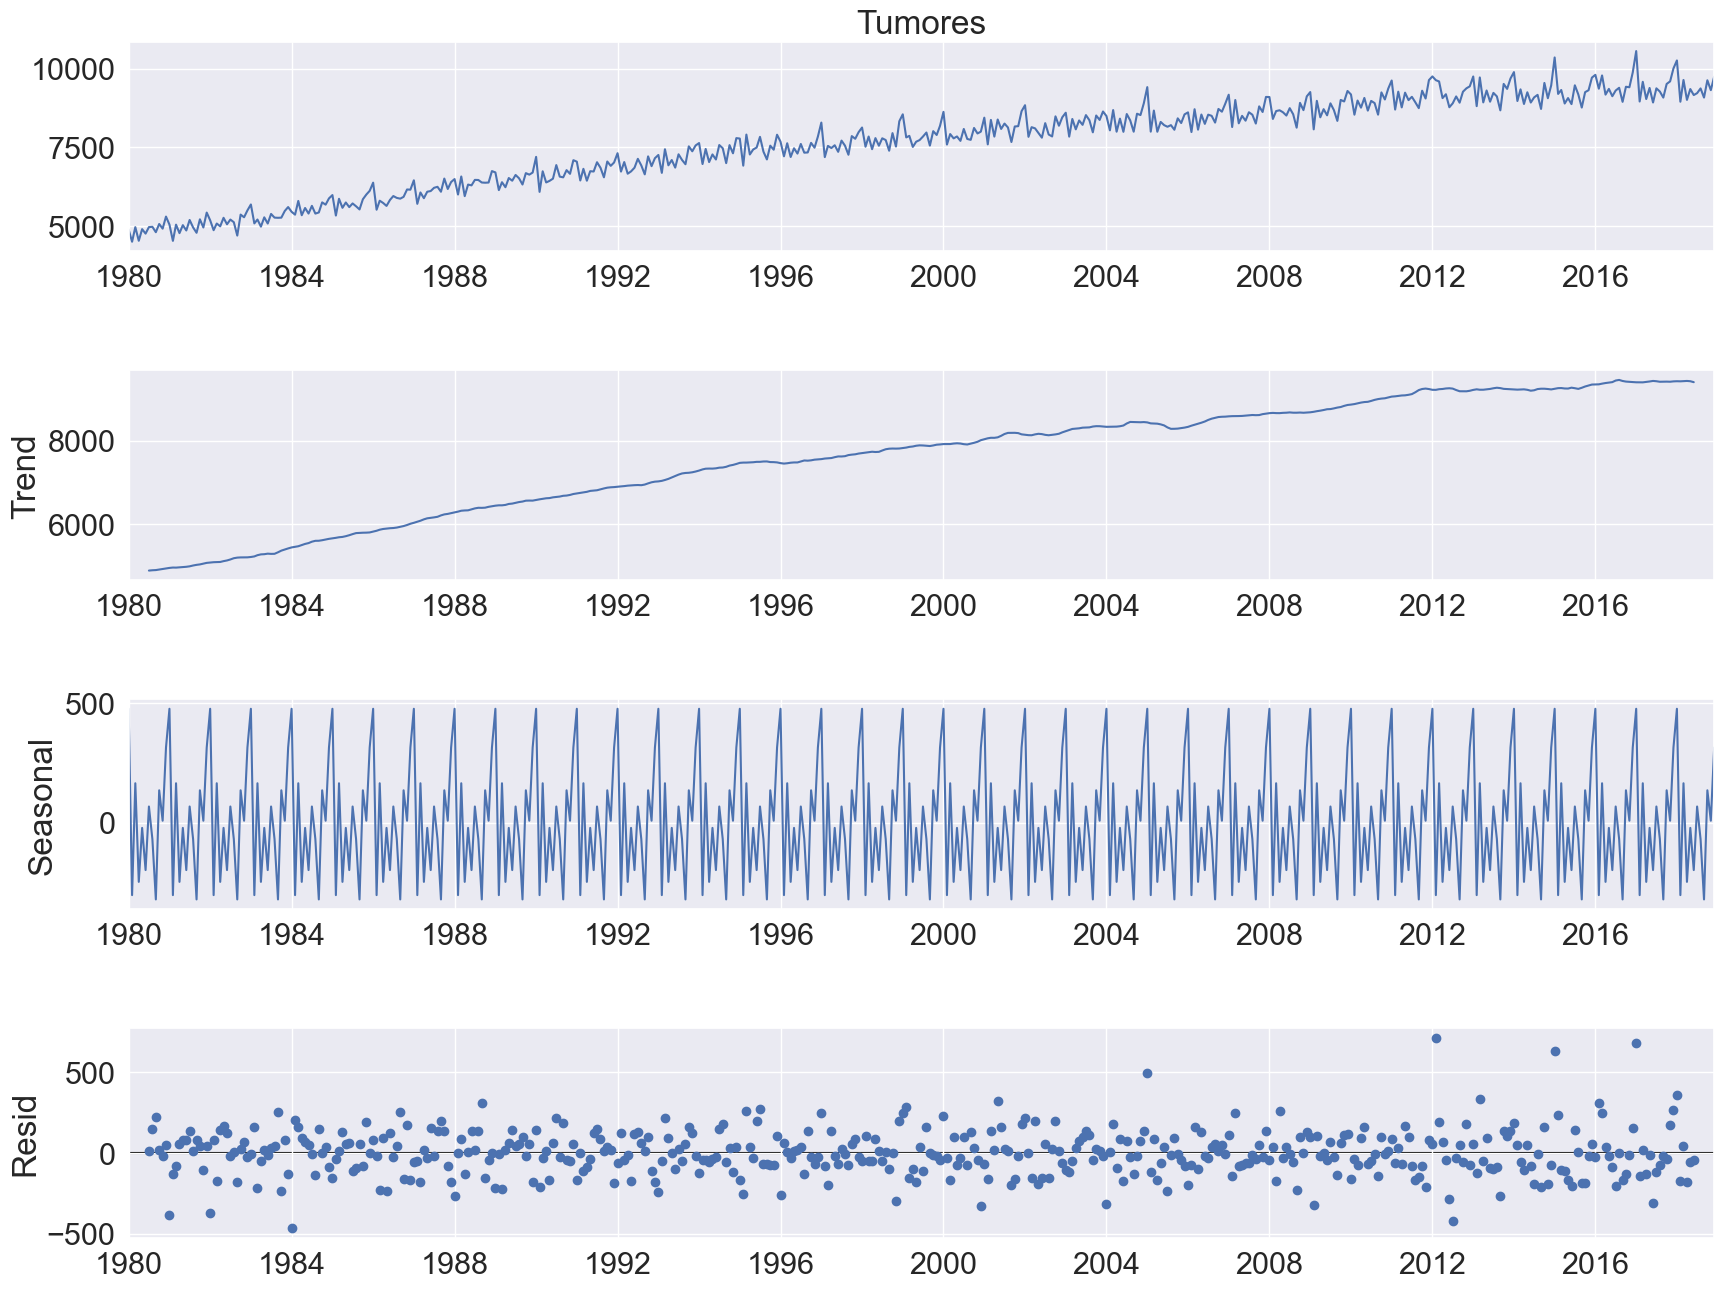

In [39]:
desc_ad = seasonal_decompose(tumores_data.Tumores, model='additive',period=12)
desc_ad.plot().set_size_inches(18, 14)
plt.show()

In [40]:
test_stationarity(desc_ad.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.910178e+00
p-value                        1.109779e-14
#Lags Used                     1.700000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.445368e+00
Critical Value (5%)           -2.868161e+00
Critical Value (10%)          -2.570297e+00
dtype: float64


Realizo el test de Dickey-Fuller para los residuos de la descomposición aditiva, el p-valor da un número muy pequeño por lo cual rechazo la hipótesis nula y se puede decir que al sacar tendencia y estacionalidad la serie es estacionaria.

Pruebo ahora la descomposición multiplicativa. Como la serie parece tener fluctuaciones crecientes, la descompasición multiplicativa sería la más adecuada. 

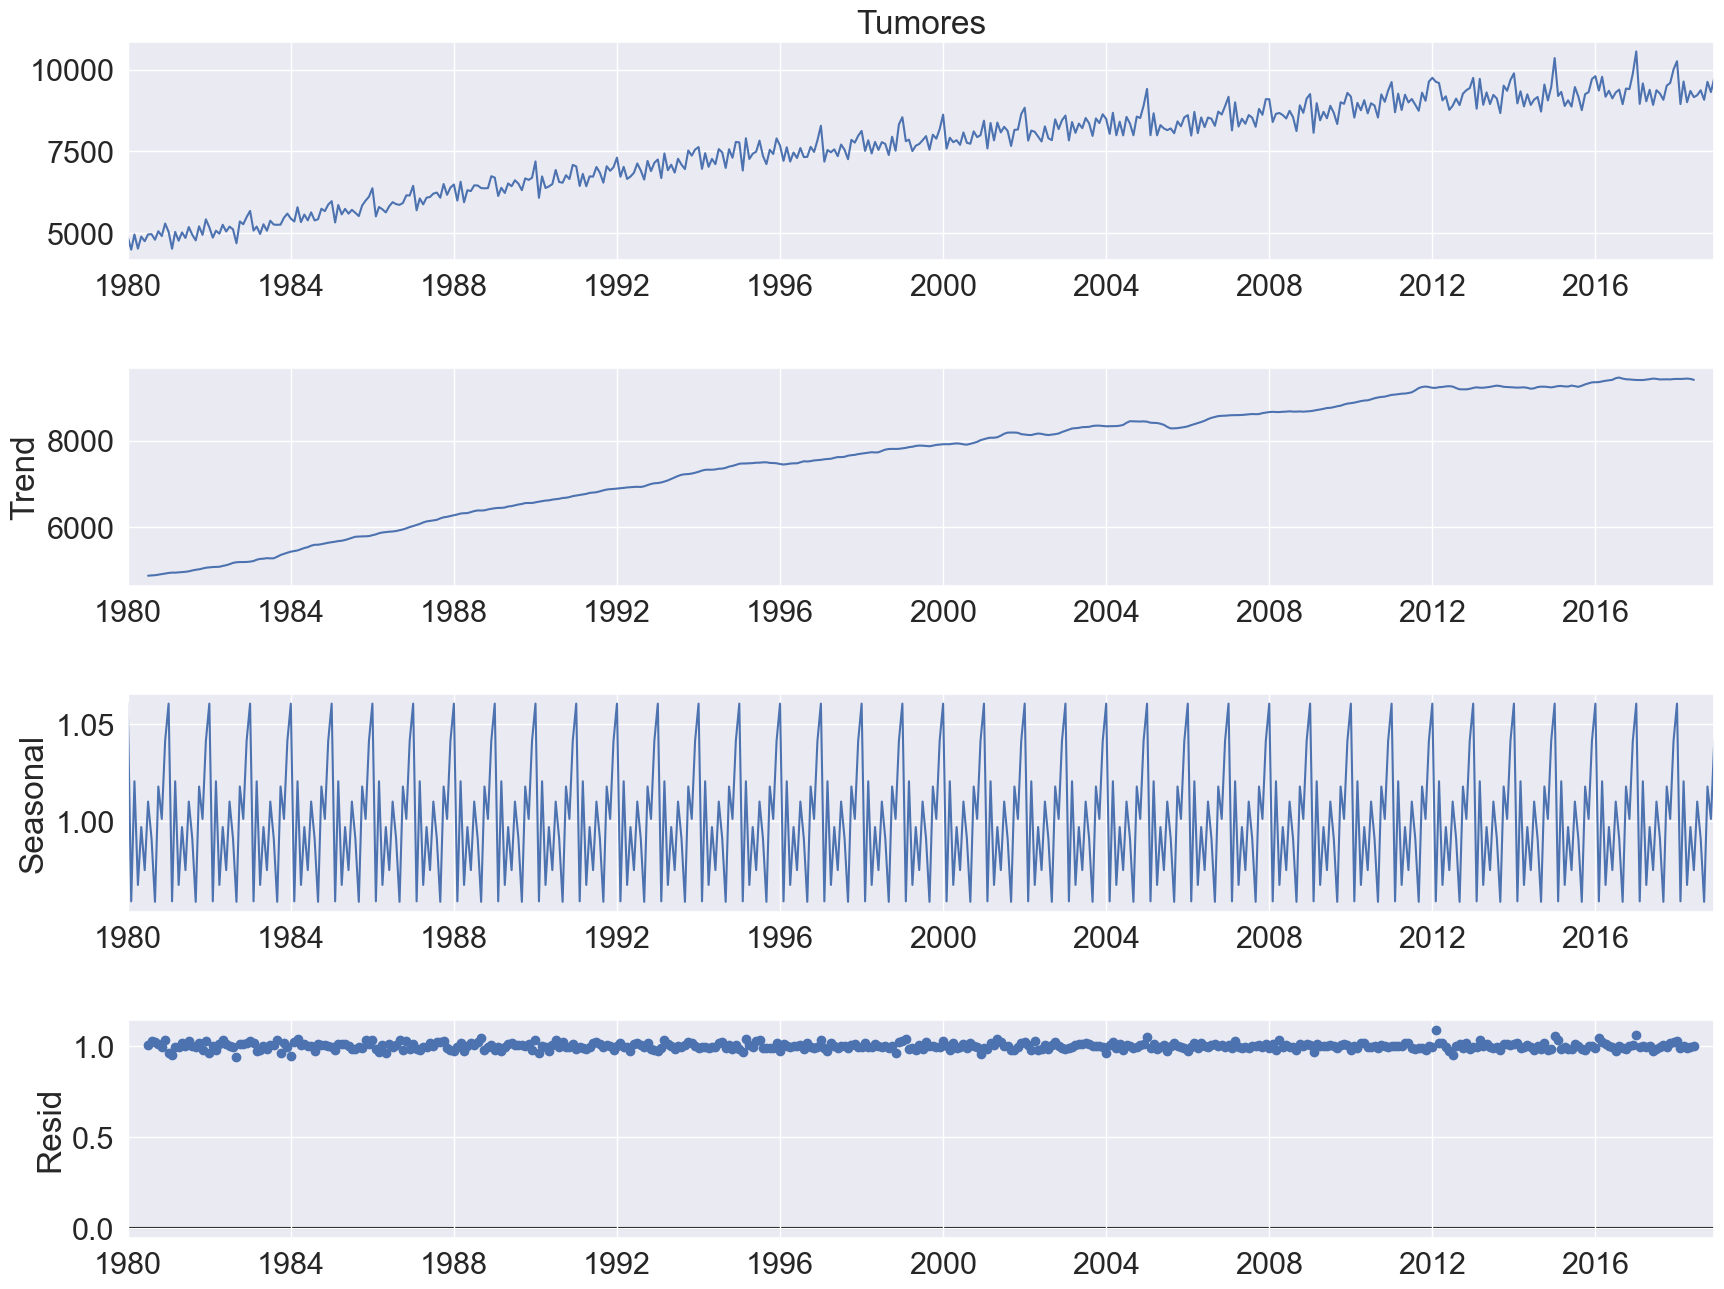

In [41]:
desc_mult = seasonal_decompose(tumores_data.Tumores, model='multiplicative',period=12)
desc_mult.plot().set_size_inches(18, 14)
plt.show()

In [42]:
test_stationarity(desc_mult.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.090168e+00
p-value                        3.843388e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.445368e+00
Critical Value (5%)           -2.868161e+00
Critical Value (10%)          -2.570297e+00
dtype: float64


De nuevo tengo un p-valor bajo, los residuos de la descomposición son estacionarios, por lo tanto sacando tendancia y estacionalidad la serie sería estarionaria. 

Como último paso tomo logarítmo de la variable objetivo para estabilizar la varianza de las serie.

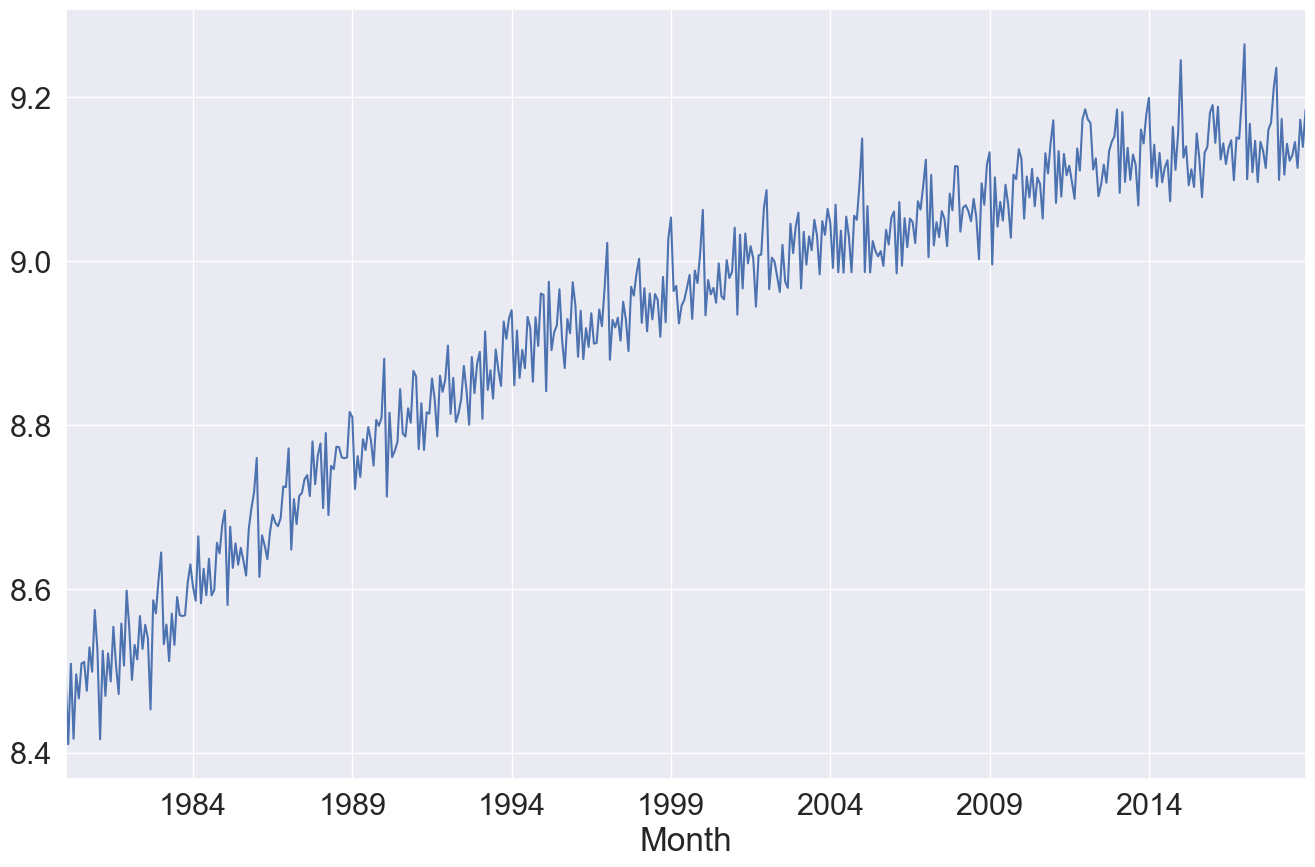

In [43]:
tumoresLog = np.log(tumores_data.Tumores)
tumoresLog.plot()
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

#### 3. Mejor modelo de suavizado exponencial. ¿Pasa el test residual de Ljung.Box?

Primero hago la separación de la muestra entre training y test. Tomamos como test los últimos dos años de la serie.

In [44]:
tumoresLog = tumores_data.copy()
tumoresLog['Tumores'] = np.log(tumoresLog['Tumores'])

tumores_tr = tumoresLog[:'2016-12-01']
tumores_tst = tumoresLog['2017-01-01':]

Voy a modelizar la serie logarítmica que cree arriba porque dejo que el modelo suavizador capte los componentes de tendencia y estacionalidad pero como no puede captar la heterocedasticidad, me deshago de ella con el logaritmo.



Voy a probar los modelos de suavizado de Holt-Winters, el aditivo y el multiplicativo. Dejo de lado los modelos de aslisado simple y el de Alisado doble de Holt ya que sus resultados son lineas rectas que sé que no van a ajustarse al comprtamiento de la serie. 

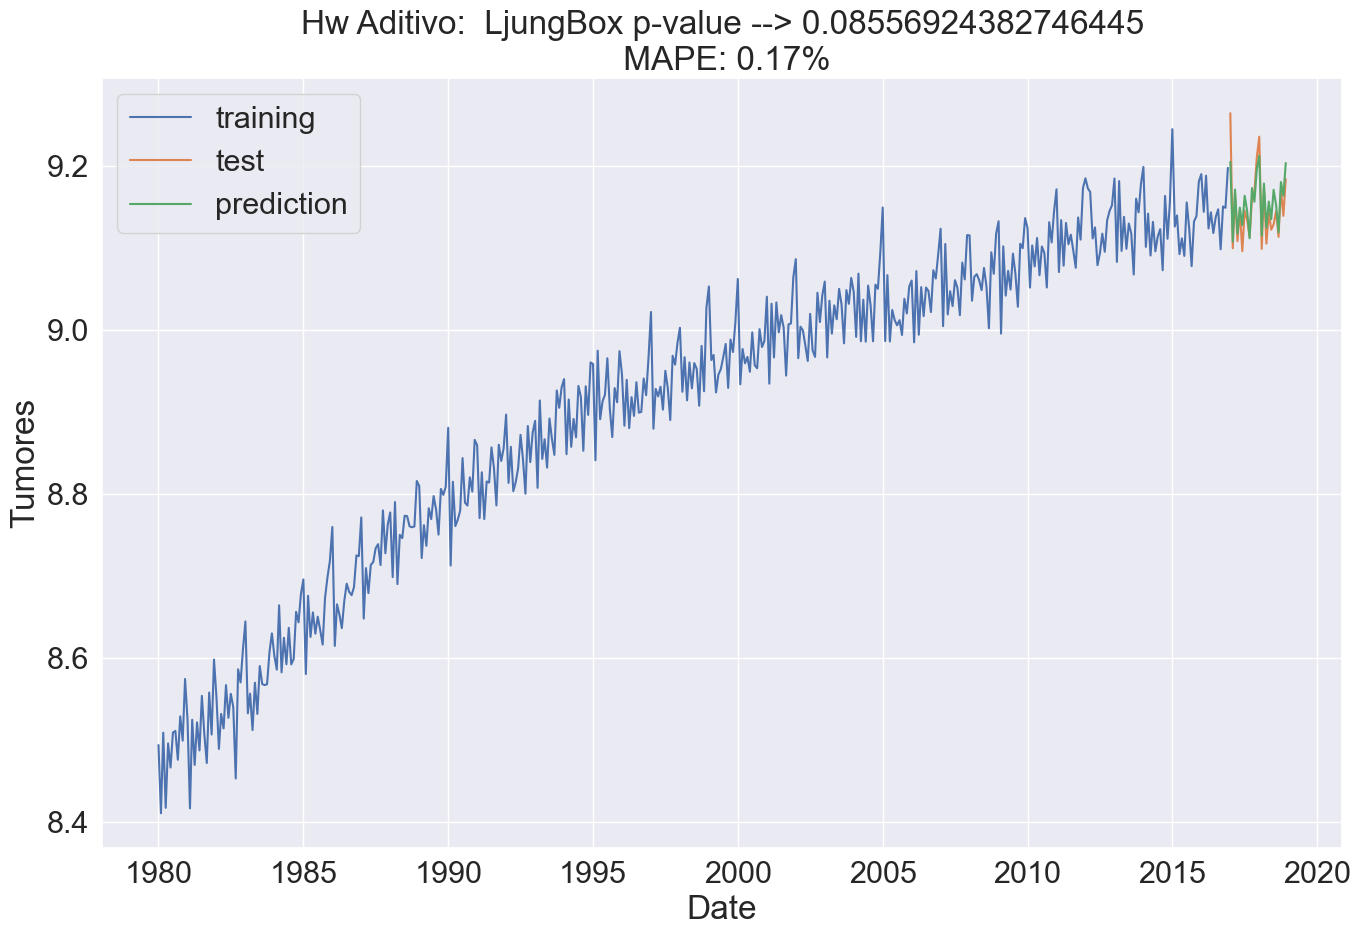

0.08556924382746445


In [45]:
hw_add = ets.ExponentialSmoothing(tumores_tr,trend='add', damped_trend=False, seasonal='add').fit()
hw_add.summary()

eval_model(hw_add,tumores_tr,tumores_tst,'Hw Aditivo')
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

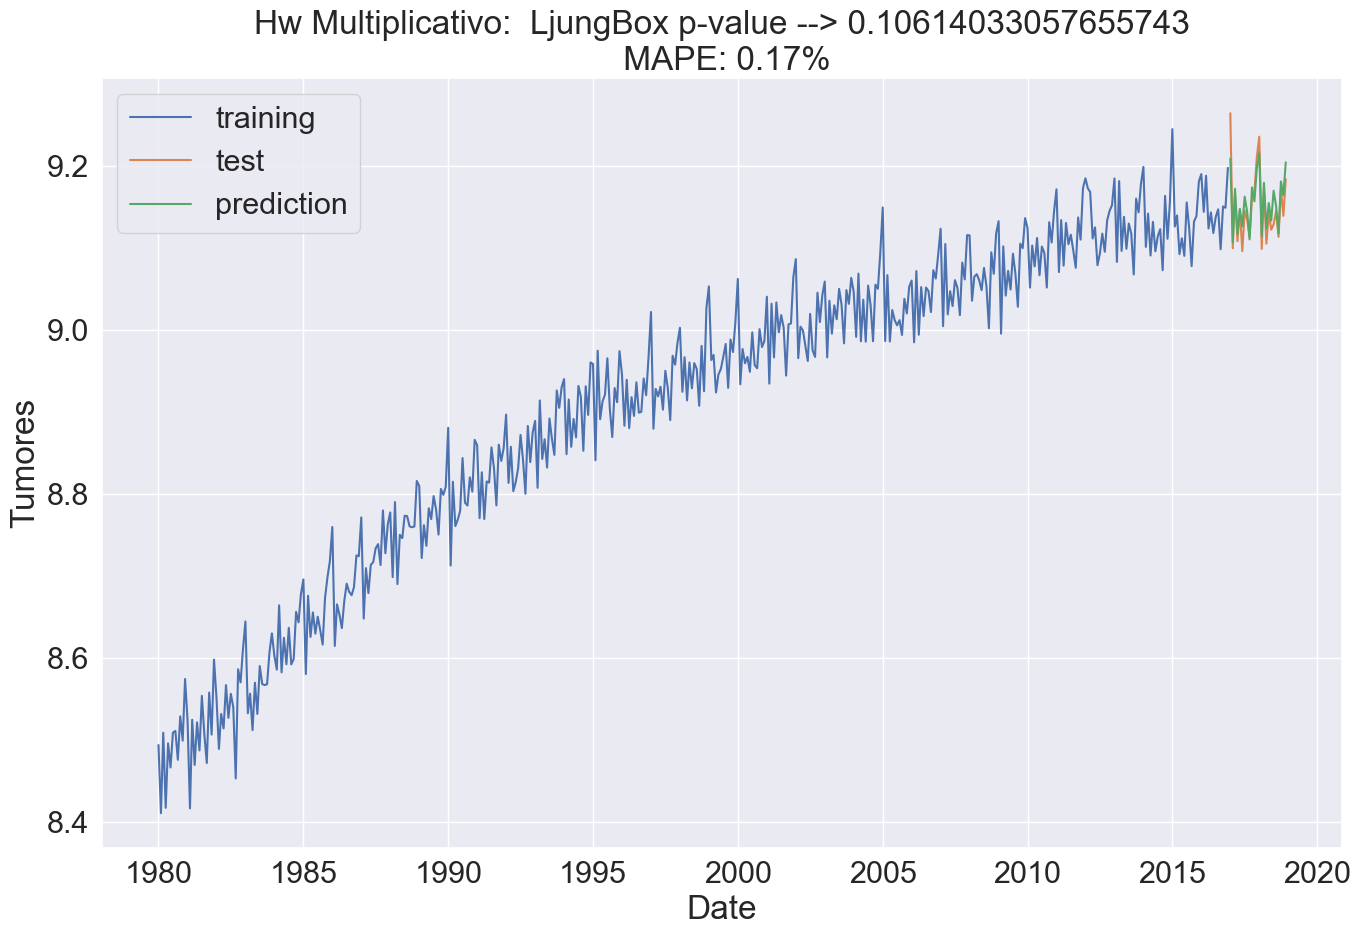

0.10614033057655743


In [46]:
hw_mul = ets.ExponentialSmoothing(tumores_tr,trend='mul', damped_trend=False, seasonal='mul').fit()
hw_mul.summary()

eval_model(hw_mul,tumores_tr,tumores_tst,'Hw Multiplicativo')
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

Entre el modelo aditivo y el multiplicativo me quedaría con el segundo ya que ambos modelos tienen MAPE bajo pero el multiplicativo esta más lejos de rechazar la hipótesis nula del test de Ljung Box de ausencia de correlación entre los residuos. 

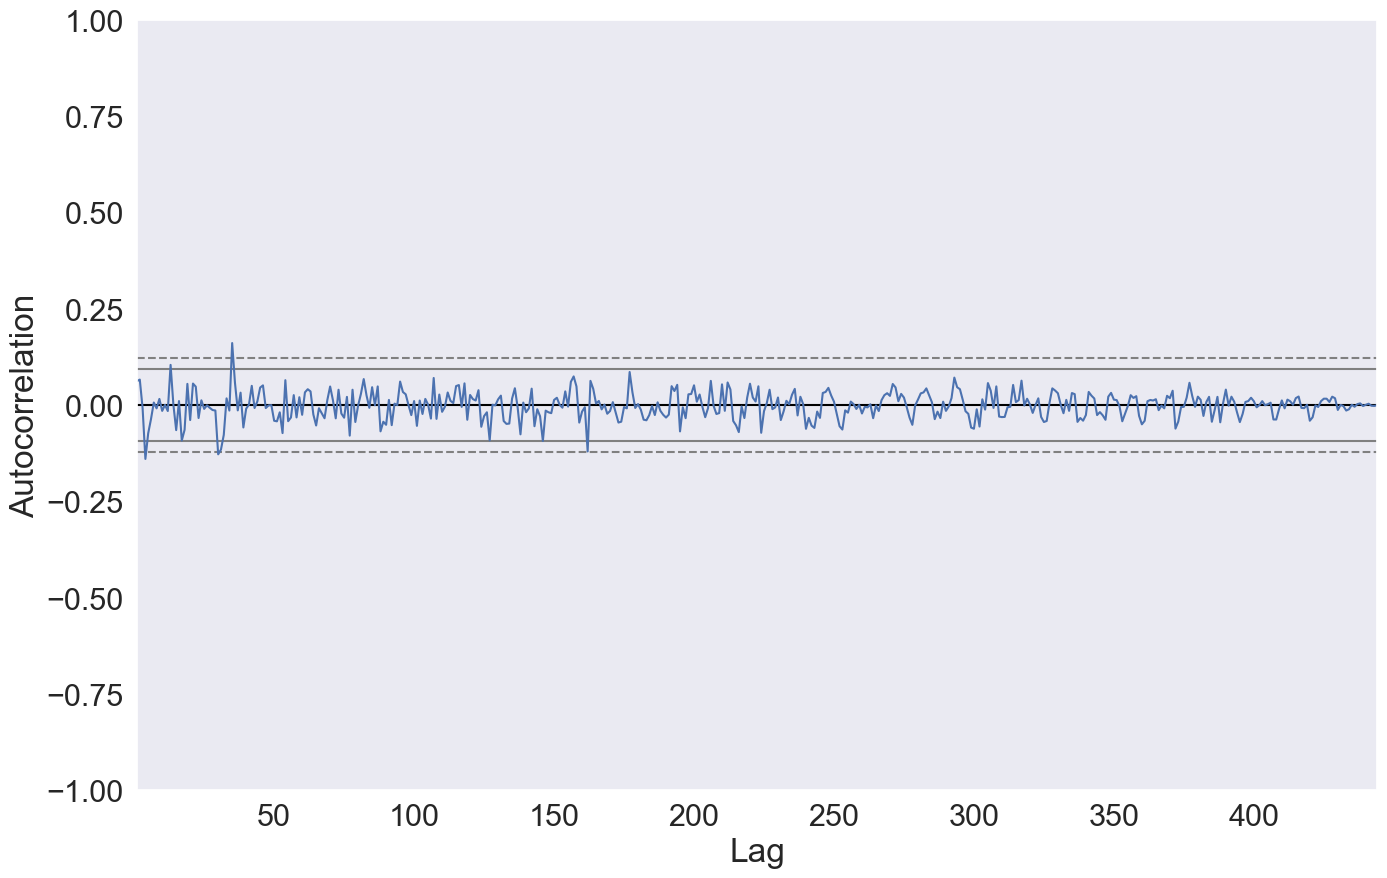

In [47]:
plt.clf()
autocorrelation_plot(hw_mul.resid)
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

#### 4. Mejor modelo ARIMA. ¿Pasa el test residual de Ljung.Box?

Para eliminar la tendancia realizo la diferenciación de la serie para considerar la serie de diferencias entre una observación y la anterior en lugar de la serie original.

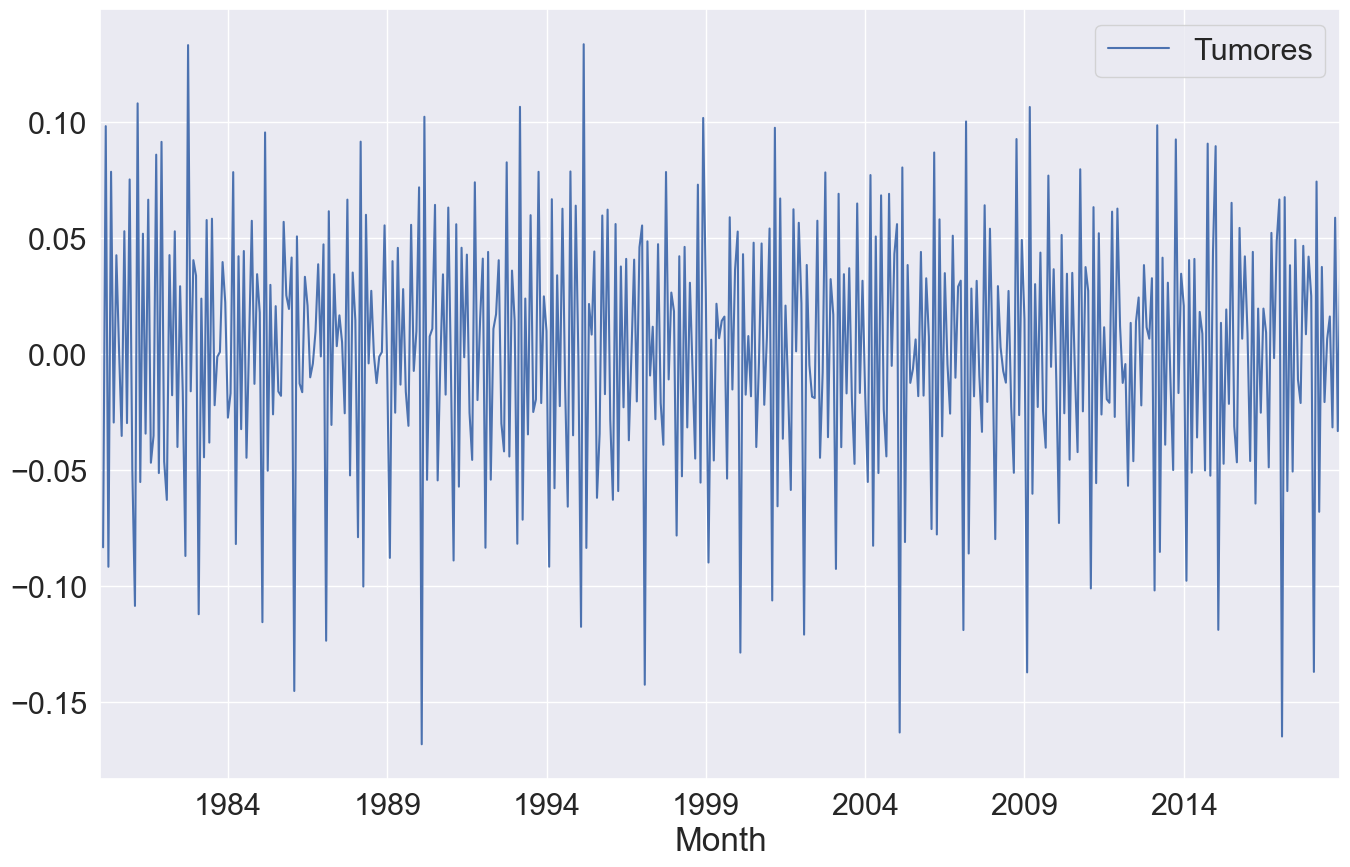

In [48]:
tumoresLog_diff_1 = tumoresLog.diff(periods=1)
tumoresLog_diff_1.plot()
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

Ahora para eliminar la estacionalidad diferencio por 12 periodos ya que tengo una serie mensual. 

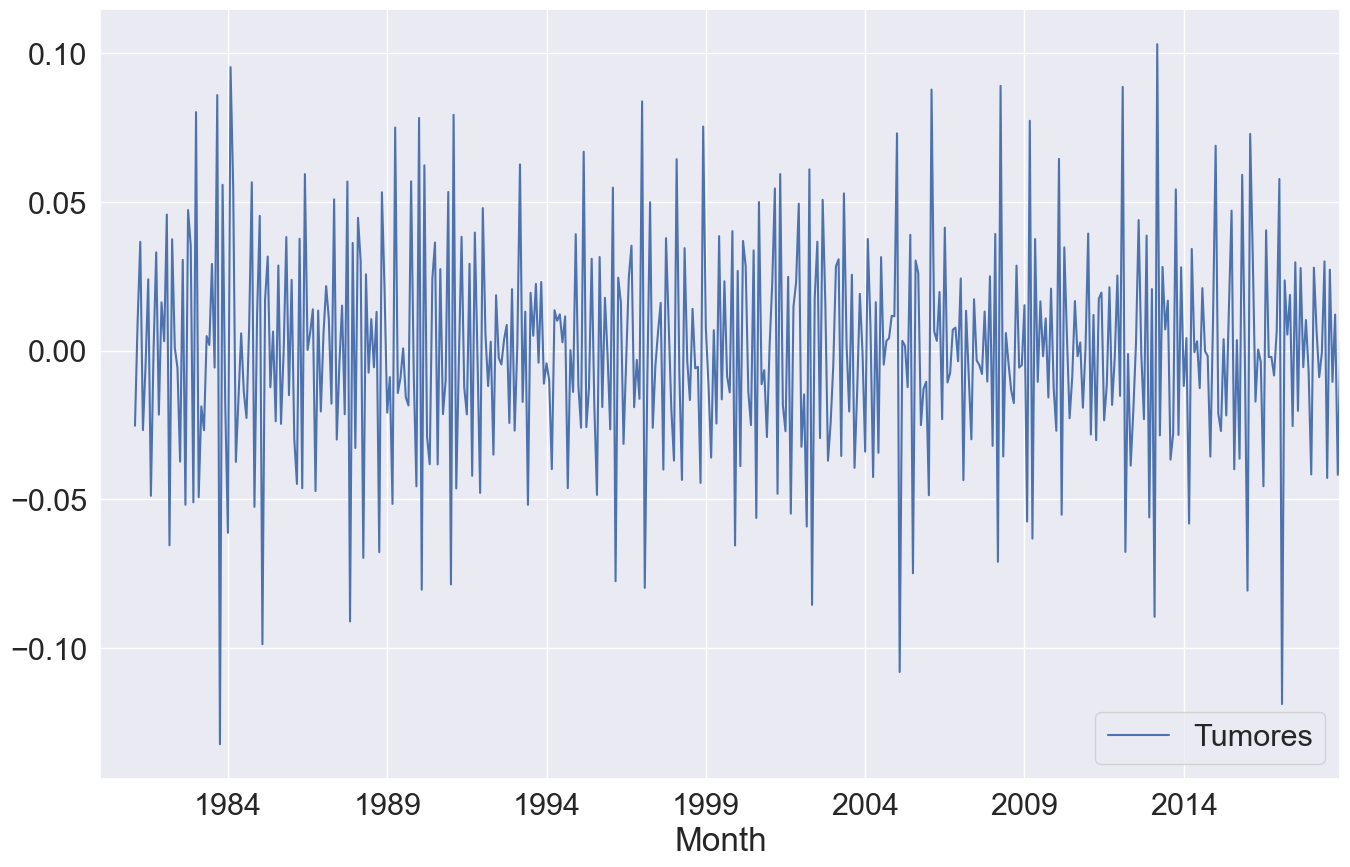

In [49]:
tumoresLog_diff_1_12 = tumoresLog_diff_1.diff(periods=12)
tumoresLog_diff_1_12.plot()
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

Ahora grafico el acf y el pacf par intentar descubir cual sería el mejor modelo ARIMA para la serie.

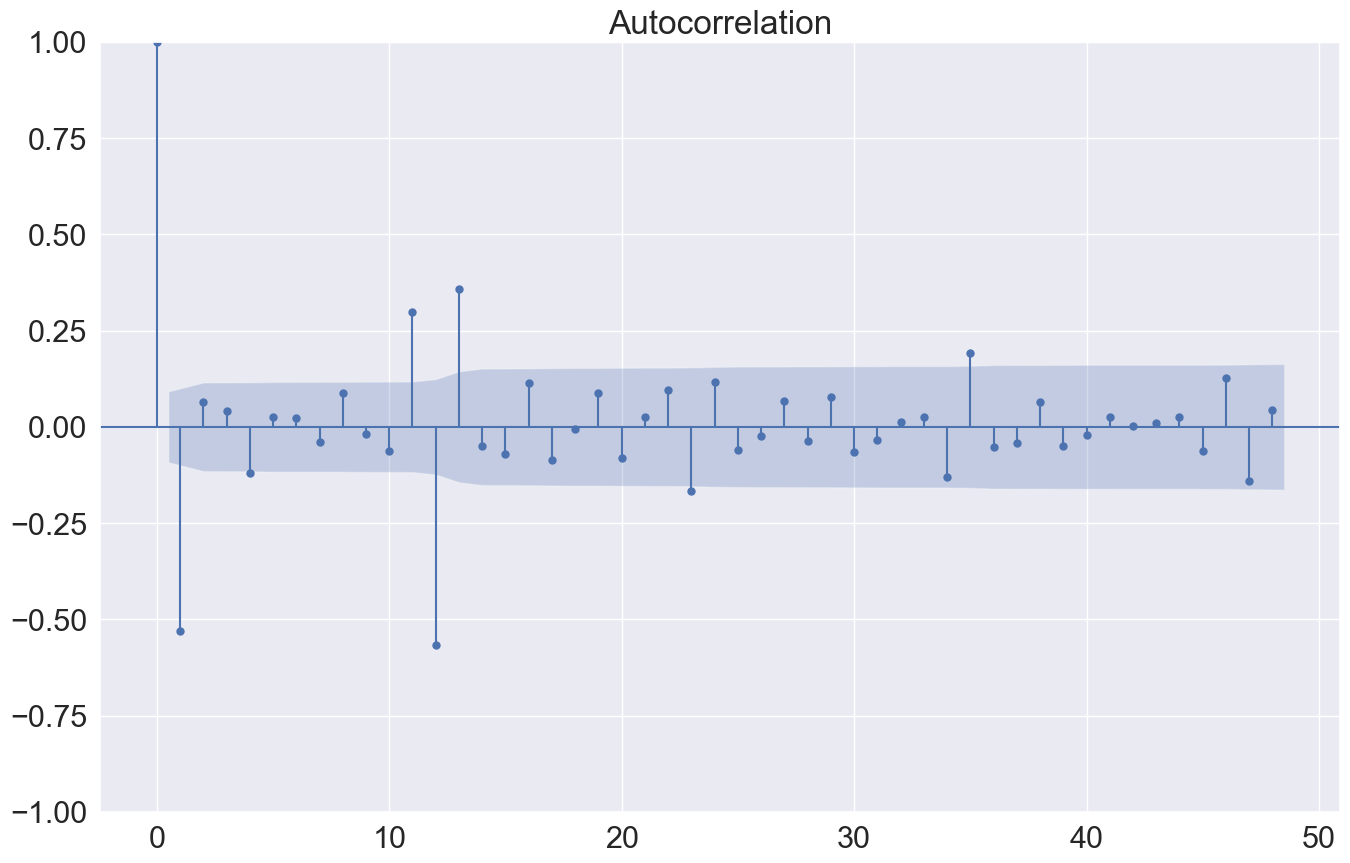

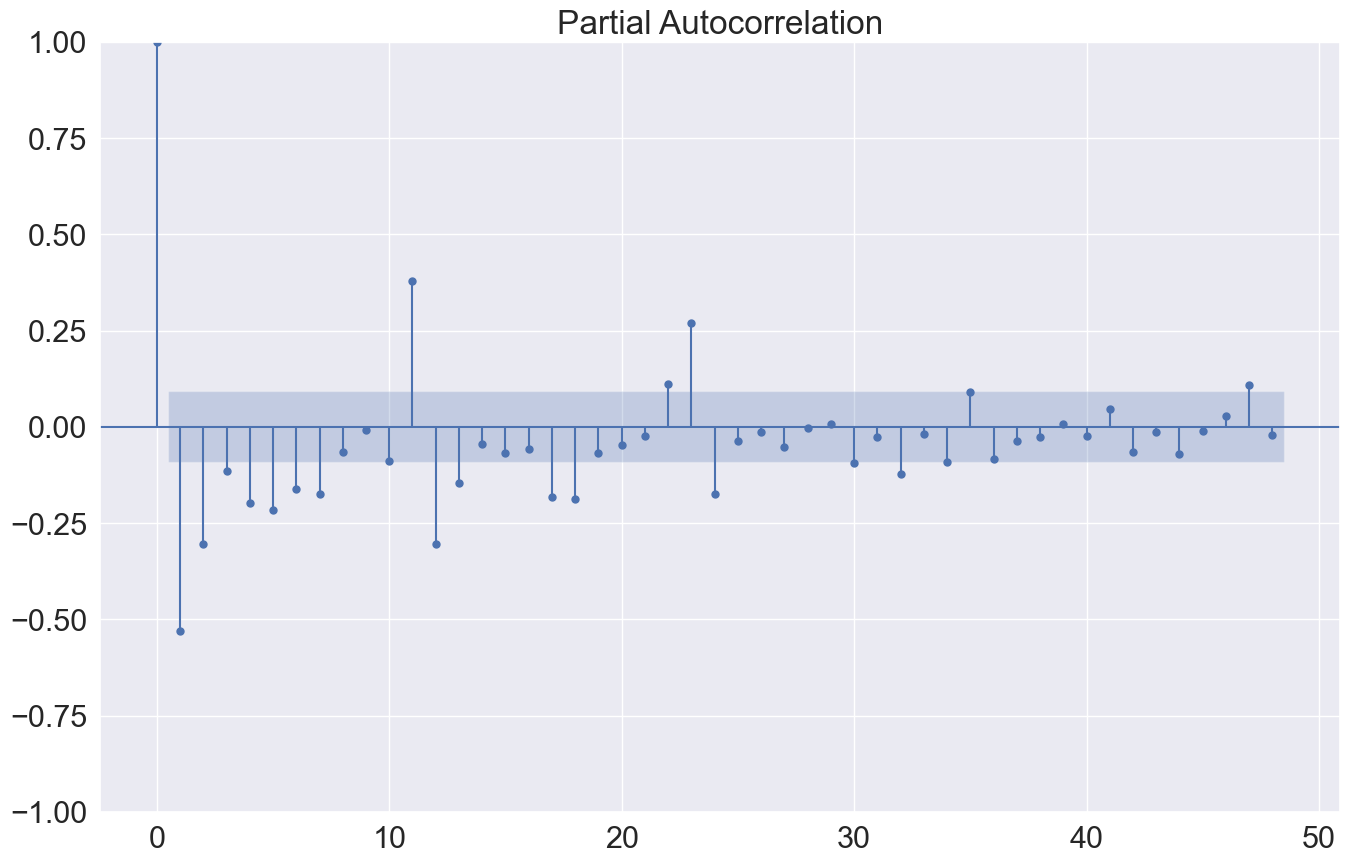

In [50]:
plot_acf(tumoresLog_diff_1_12.dropna(inplace=False),lags=48)
plt.rcParams["figure.figsize"] = (16,10)
plt.show()
plot_pacf(tumoresLog_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

Mirando los correlogramas, y arriesgando una conclusión, dado que el ACF se corta en 1 y vemos un decrecimiento geométrico en PACF, podríamos decir que tenemos un MA(1). Por otro lado, no queda claro cual sería la el mejor modelo AR() para esta serie.

Comienzo probando el modelo MA(1).

##### Modelo1: MA(1)

In [51]:
arima1 = SARIMAX(tumores_tr, 
                order = (0, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_1 = arima1.fit()
arima_1.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27394D+00    |proj g|=  1.66143D+01

At iterate    5    f= -2.37027D+00    |proj g|=  3.78340D-01

At iterate   10    f= -2.38849D+00    |proj g|=  5.49315D+00

At iterate   15    f= -2.39337D+00    |proj g|=  3.35244D-03

At iterate   20    f= -2.39357D+00    |proj g|=  1.03324D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     40      1     0     0   5.749D-04  -2.394D+00
  F =  -2.3935680858168631     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Tumores   No. Observations:                  444
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                1062.744
Date:                            Thu, 29 Jun 2023   AIC                          -2119.488
Time:                                    20:10:32   BIC                          -2107.290
Sample:                                01-01-1980   HQIC                         -2114.672
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8387      0.029    -28.959      0.000      -0.895      -0.782
ma.S.L12      -0.8623      0.038    -22.721      0.000      -0.937      -0.788
sigma2         0.0004   2.24e-05     18.140      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                46.73
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.44
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

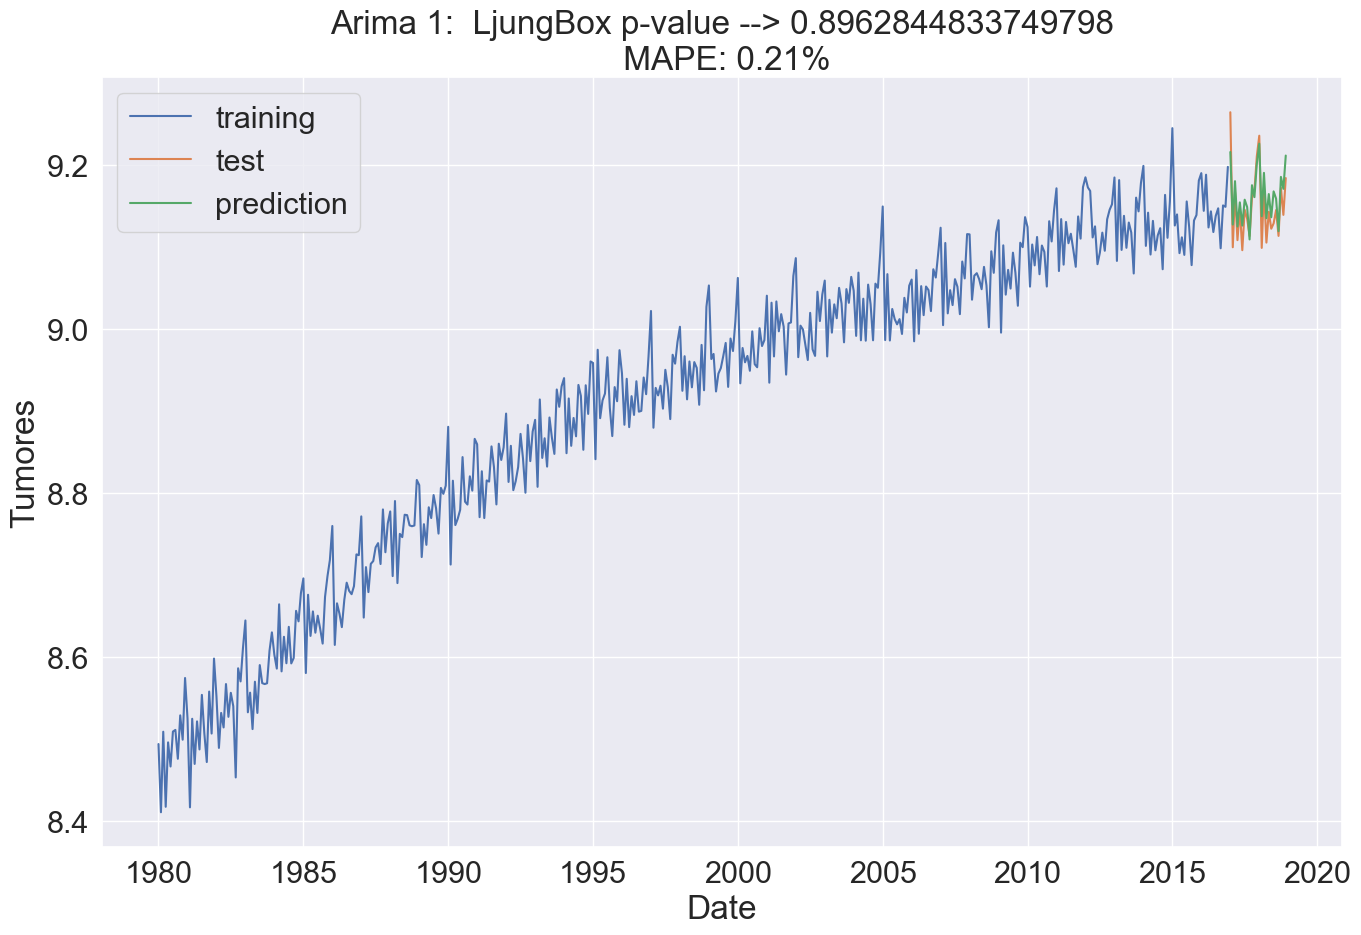

0.8962844833749798


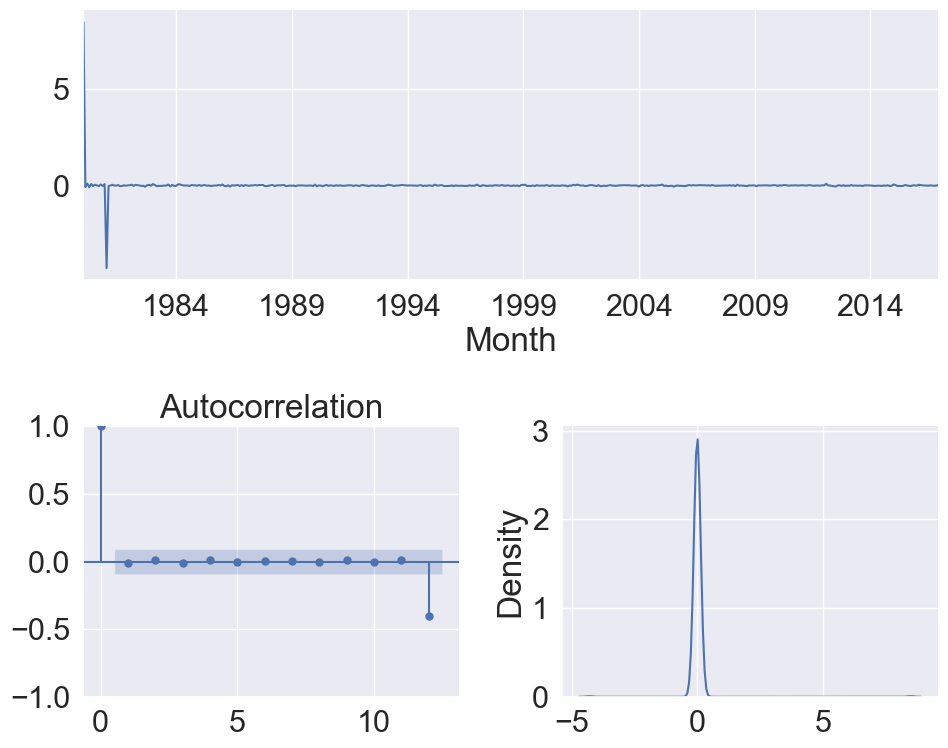

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.896 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


In [52]:
eval_model(arima_1,tumores_tr,tumores_tst,'Arima 1')

residcheck(arima_1.resid,12)
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

El modelo MA(1) tiene un MAPE mas alto que los modelos de suavizado de Holt-Winters, pero al igual que ellos pasa el testd e Ljung-Box.

##### Modelo 2: AR(1)

In [53]:
arima2 = SARIMAX(tumores_tr, 
                order = (1, 1, 0), 
                seasonal_order =(1, 1, 0, 12))
  
arima_2 = arima2.fit()
arima_2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13132D+00    |proj g|=  8.77943D+00

At iterate    5    f= -2.15450D+00    |proj g|=  3.12572D-02

At iterate   10    f= -2.15679D+00    |proj g|=  1.38855D-01


 This problem is unconstrained.



At iterate   15    f= -2.15680D+00    |proj g|=  1.92048D-03

At iterate   20    f= -2.15680D+00    |proj g|=  2.19126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     79      2     0     0   2.191D-03  -2.157D+00
  F =  -2.1568029444462389     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Tumores   No. Observations:                  444
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 957.621
Date:                            Thu, 29 Jun 2023   AIC                          -1909.241
Time:                                    20:10:34   BIC                          -1897.043
Sample:                                01-01-1980   HQIC                         -1904.425
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4909      0.036    -13.746      0.000      -0.561      -0.421
ar.S.L12      -0.5302      0.040    -13.227      0.000      -0.609      -0.452
sigma2         0.0007   4.16e-05     16.362      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   8.04   Jarque-Bera (JB):                 5.06
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               0.69   Skew:                             0.06
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

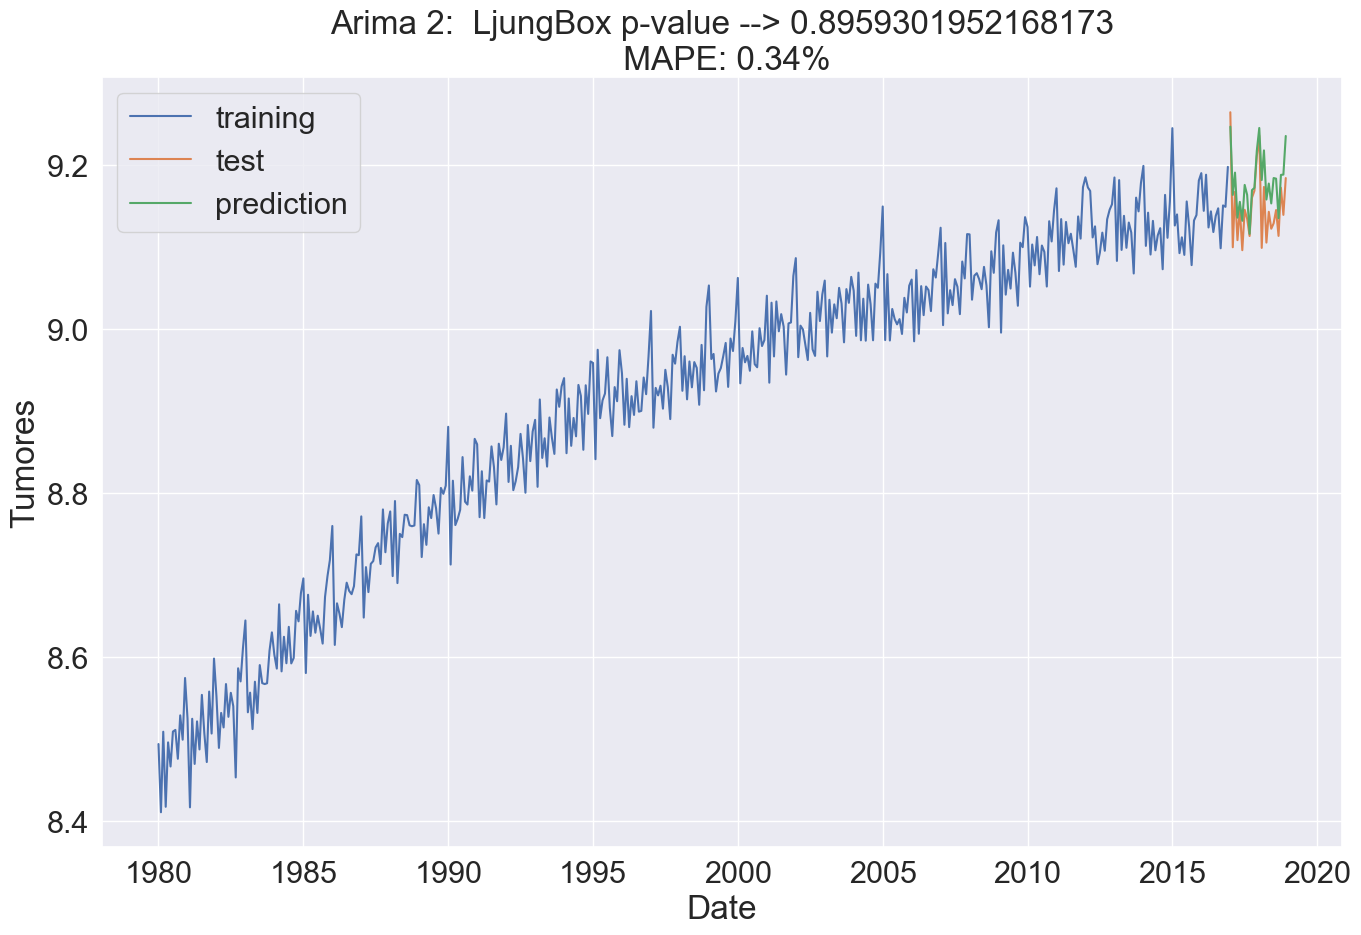

0.8959301952168173


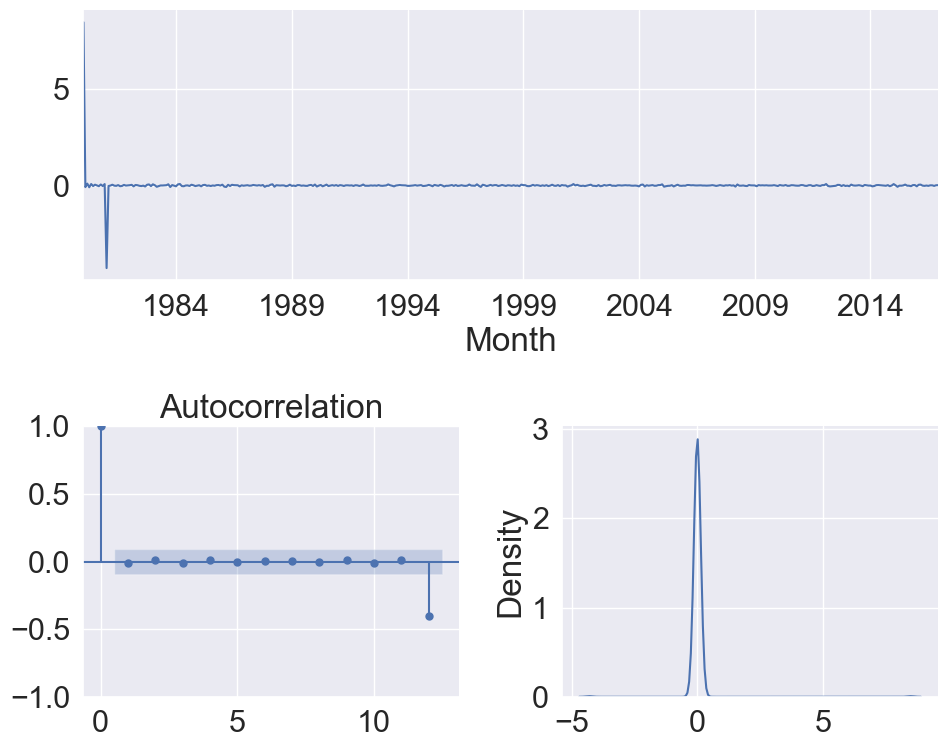

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.896 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


In [54]:
eval_model(arima_2,tumores_tr,tumores_tst,'Arima 2')

residcheck(arima_2.resid,12)

plt.rcParams["figure.figsize"] = (16,10)
plt.show()

El MAPE de este modelo es bantante más alto que el del MA(1), pero aún así pasa el test de Ljung-Box.

##### Modelo 3 : ARIMA(1,1)

In [55]:
arima3 = SARIMAX(tumores_tr, 
                order = (1, 1, 1), 
                seasonal_order =(1, 1, 1, 12))
  
arima_3 = arima3.fit()
arima_3.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22923D+00    |proj g|=  1.28623D+01


 This problem is unconstrained.



At iterate    5    f= -2.27934D+00    |proj g|=  2.98482D-01

At iterate   10    f= -2.32296D+00    |proj g|=  1.14773D+01

At iterate   15    f= -2.37488D+00    |proj g|=  3.23334D-01

At iterate   20    f= -2.39567D+00    |proj g|=  5.13293D-02

At iterate   25    f= -2.39567D+00    |proj g|=  1.70719D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     57      1     0     0   1.707D-02  -2.396D+00
  F =  -2.3956737738820943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Tumores   No. Observations:                  444
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1063.679
Date:                            Thu, 29 Jun 2023   AIC                          -2117.358
Time:                                    20:10:36   BIC                          -2097.028
Sample:                                01-01-1980   HQIC                         -2109.331
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0244      0.054      0.452      0.651      -0.081       0.130
ma.L1         -0.8450      0.033    -25.469      0.000      -0.910      -0.780
ar.S.L12      -0.0735      0.056     -1.301      0.193      -0.184       0.037
ma.S.L12      -0.8420      0.044    -19.208      0.000      -0.928      -0.756
sigma2         0.0004   2.23e-05     18.111      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                48.91
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.45
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

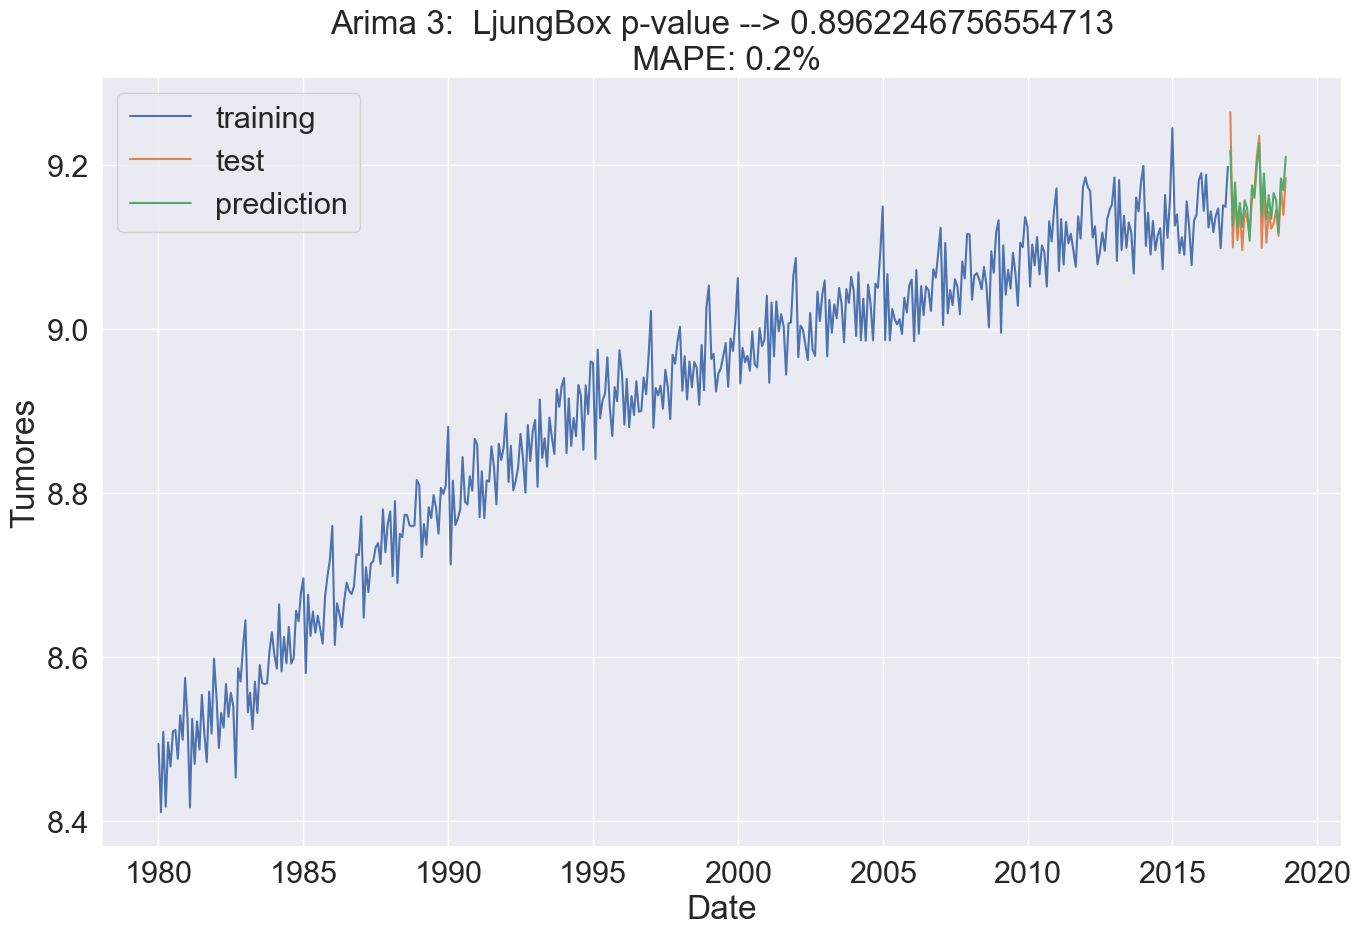

0.8962246756554713


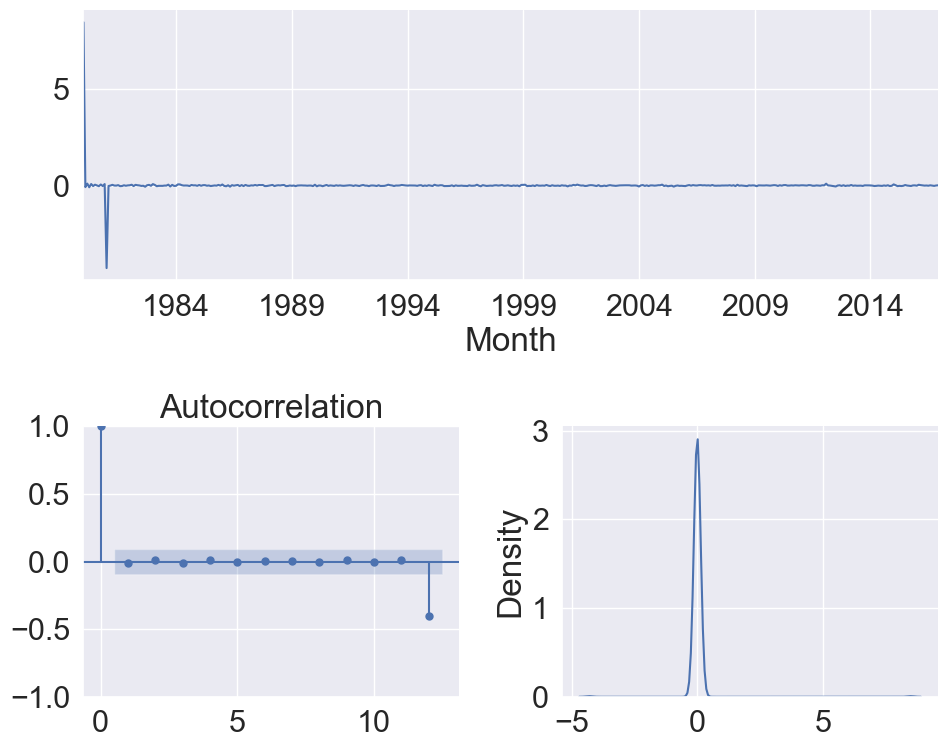

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.896 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


In [56]:
eval_model(arima_3,tumores_tr,tumores_tst,'Arima 3')
residcheck(arima_3.resid,12)

plt.rcParams["figure.figsize"] = (16,10)
plt.show()

Este modelo tiene un MAPE parecido al del MA(1), y pasa el test de Ljung-Box.


Como ultimo paso vamos a probar el modelo automático que prueba las distintas combinaciones de AR() y MA() hasta encontrar la mejor.

In [57]:
arima_auto = pm.auto_arima(tumores_tr, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-2131.193, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1339.055, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1876.126, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1809.771, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1340.659, Time=0.10 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-1811.200, Time=1.19 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-1982.013, Time=1.19 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=-2125.441, Time=4.15 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=-2117.641, Time=2.47 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-1640.490, Time=0.30 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=-1883.089, Time=2.03 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-2070.465, Time=1.69 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=-2153.731, Time=2.54 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=-2129.079, Time=1.95 sec
 ARIM

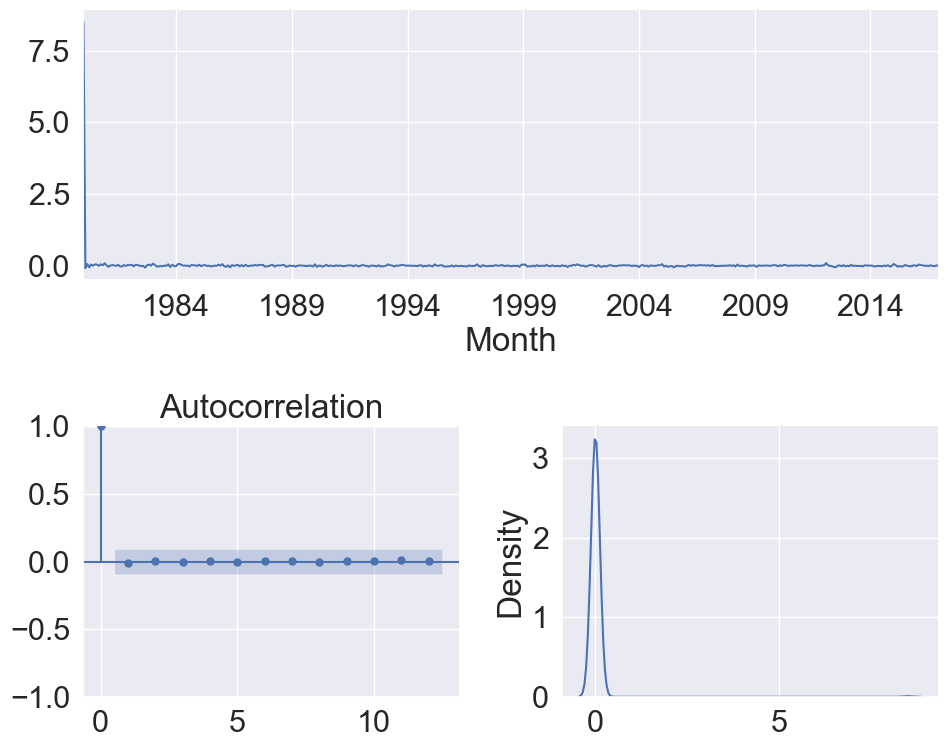

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.983 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


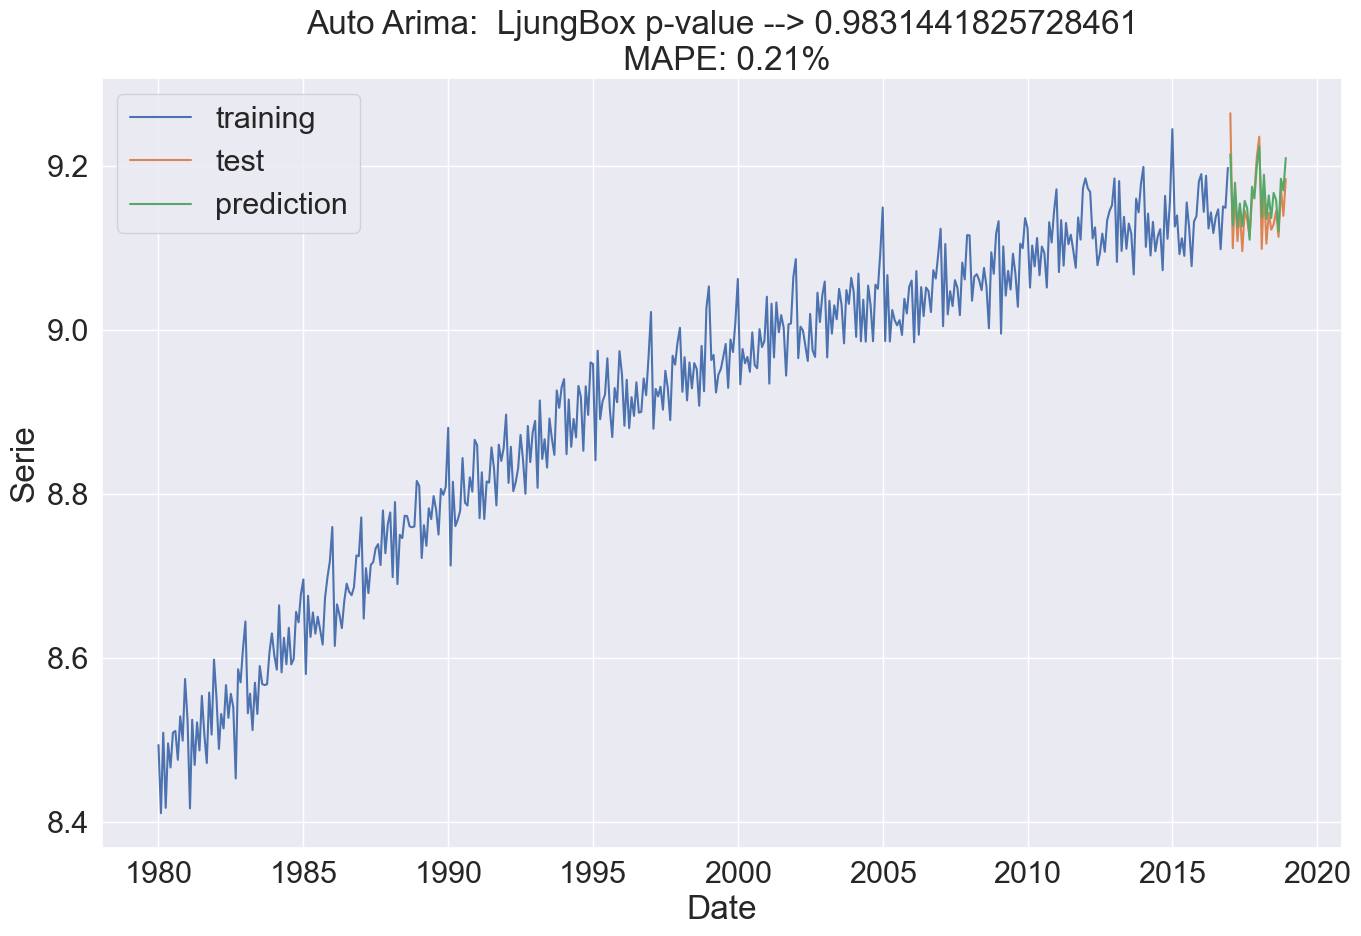

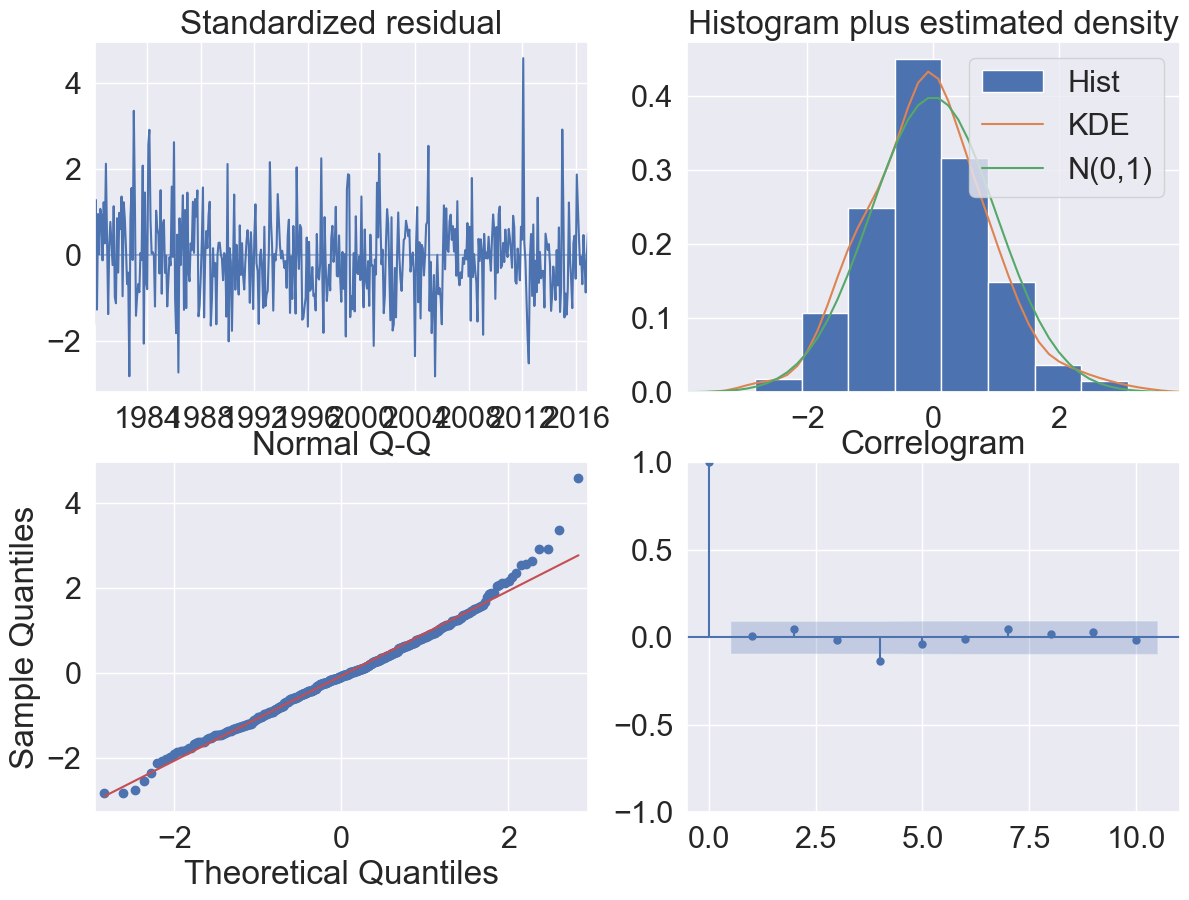

In [58]:
residcheck(arima_auto.resid(),12)
eval_model_Aarima(arima_auto,tumores_tr,tumores_tst,'Auto Arima')

plt.rcParams["figure.figsize"] = (16,10)
plt.show()

Según la función de auto ARIMA el mejor modelo sería un MA(1), como habíamos intuído por los correlogramas, pero con un seasonal order distinto al original que probamos. Este modelo no rechaza la hipótesis nula del test de LjunBox, y tiene un MAPE de 0.21%.  

#### 5. Comparación. En relación al MAPE en el conjunto de test, ¿Qué modelo resulta más preciso en sus predicciones?


Comparando los MAPES, los modelos de suavizado de Holt-Winters tienen los MAPEs más bajos de todos y serían los más precisos. 

# Ejercicio 3

#### 1. Leer el archivo wisconsin.xlsx

In [59]:
wisconsin = pd.read_excel(r'wisconsin.xlsx')
wisconsin.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [60]:
wisconsin.set_index(['id'],inplace=True)
wisconsin.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
id                                                                         
842302           M        17.99         10.38          122.80     1001.0   
842517           M        20.57         17.77          132.90     1326.0   
84300903         M        19.69         21.25          130.00     1203.0   
84348301         M        11.42         20.38           77.58      386.1   
84358402         M        20.29         14.34          135.10     1297.0   

          smoothness_mean  compactness_mean  concavity_mean  \
id                                                            
842302            0.11840           0.27760          0.3001   
842517            0.08474           0.07864          0.0869   
84300903          0.10960           0.15990          0.1974   
84348301          0.14250           0.28390          0.2414   
84358402          0.10030           0.13280          0.1980   

          concave points_mean  symmetry_mean  ...  radius_worst  \
id                                            ...                 
842302                0.14710         0.2419  ...         25.38   
842517                0.07017         0.1812  ...         24.99   
84300903              0.12790         0.2069  ...         23.57   
84348301              0.10520         0.2597  ...         14.91   
84358402              0.10430         0.1809  ...         22.54   

          texture_worst  perimeter_worst  area_worst  smoothness_worst  \
id                                                                       
842302            17.33           184.60      2019.0            0.1622   
842517            23.41           158.80      1956.0            0.1238   
84300903          25.53           152.50      1709.0            0.1444   
84348301          26.50            98.87       567.7            0.2098   
84358402          16.67           152.20      1575.0            0.1374   

          compactness_worst  concavity_worst  concave points_worst  \
id                                                                   
842302               0.6656           0.7119                0.2654   
842517               0.1866           0.2416                0.1860   
84300903             0.4245           0.4504                0.2430   
84348301             0.8663           0.6869                0.2575   
84358402             0.2050           0.4000                0.1625   

          symmetry_worst  fractal_dimension_worst  
id                                                 
842302            0.4601                  0.11890  
842517            0.2750                  0.08902  
84300903          0.3613                  0.08758  
84348301          0.6638                  0.17300  
84358402          0.2364                  0.07678  

[5 rows x 31 columns]

#### 2. Obtener la matriz de correlaciones entre las variables numéricas.

In [61]:
corr = wisconsin.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

Mirando la matriz de correlaciones podemos ver que hay varias variables con correlaciones altas, mayores a 0.8. Estas variables son sobre todo las variables de medidas de los tumores, como el radio, el area y el perímetro.

#### 3. Sabiendo que se trata de predecir la variable binaria diagnosis (‘M,’B’). ¿Cuál sería el modelo adecuado de predicción? ¿Qué problemas auguras a la luz de la información sobre las correlaciones del archivo?

Dado que la variable diagnois es una variable binaria, el modelo adecuado sería un modelo de Regresión Logistica. Sin embargo tengo demasiadas variables en el dataset, habría que reducir sus dimensiones. Mirando la matriz de correlaciones podemos intuir que vamos a tener un problema de colinealidad entre las variables explicativas. 

#### 4. Como posible estrategia se plantea la realización de un ACP para la reducción de dimensiones y un modelo de predicción adecuado utilizando como predictores las componentes principales resultantes de tal forma que se retenga al menos el 70% de la variabilidad del archivo.

##### a. Valora la adecuación muestral a priori

In [62]:
wisconsin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [63]:
wisconsin_var = wisconsin.drop(['diagnosis'],axis=1)

In [64]:
calculate_bartlett_sphericity(wisconsin_var)

(39362.120841132055, 0.0)

Realizo el test de bartlett para evaluar si la matriz de correlación es una matriz identidad, es decir que no hay correlaciones entre las variables. El p-valor de este test es 0, por lo que puedo rechazar la hipótesis nula de ausencia de correlación y por lo tanto las variables son adecuadas para un análisis de componentes.

In [65]:
calculate_kmo(wisconsin_var)

(array([0.83463512, 0.64352613, 0.85334054, 0.86403253, 0.814716  ,
        0.87939755, 0.89192843, 0.90027723, 0.82510264, 0.83181381,
        0.83412178, 0.48458942, 0.84290718, 0.85199881, 0.64427854,
        0.8712978 , 0.82547994, 0.83516673, 0.5832182 , 0.81149623,
        0.82308704, 0.60329755, 0.88493799, 0.82044529, 0.75316064,
        0.85127714, 0.90222587, 0.89105242, 0.69074764, 0.81233969]),
 0.8322253094694511)

Relizamos el KMO que es el índice de adecuación muestral, contrasta la correlación observada entre pares de variables y sus correspondientes correlaciones parciales. Para este test las variables que tengan valores por encima de 0.7 están bien y las que estén por dejo de 0.5 están mal. En este caso podríamos dropear texture_se porque tiene un KMO menor a 0.5

In [66]:
wisconsin_var.drop(['texture_se'], axis=1, inplace=True)

##### b. Realiza el ACP sobre las numéricas. ¿Cuántas componentes se deberían considerar para cumplir el criterio mencionado? Interpreta la componente 1.

In [67]:
scaler = StandardScaler()
scaler.fit(wisconsin_var)
X = scaler.transform(wisconsin_var)
pd.DataFrame(X, index=wisconsin_var.index).head()

0         1         2         3         4         5   \
id                                                                     
842302    1.097064 -2.073335  1.269934  0.984375  1.568466  3.283515   
842517    1.829821 -0.353632  1.685955  1.908708 -0.826962 -0.487072   
84300903  1.579888  0.456187  1.566503  1.558884  0.942210  1.052926   
84348301 -0.768909  0.253732 -0.592687 -0.764464  3.283553  3.402909   
84358402  1.750297 -1.151816  1.776573  1.826229  0.280372  0.539340   

                6         7         8         9   ...        19        20  \
id                                                ...                       
842302    2.652874  2.532475  2.217515  2.255747  ...  1.886690 -1.359293   
842517   -0.023846  0.548144  0.001392 -0.868652  ...  1.805927 -0.369203   
84300903  1.363478  2.037231  0.939685 -0.398008  ...  1.511870 -0.023974   
84348301  1.915897  1.451707  2.867383  4.910919  ... -0.281464  0.133984   
84358402  1.371011  1.428493 -0.009560 -0.562450  ...  1.298575 -1.466770   

                21        22        23        24        25        26  \
id                                                                     
842302    2.303601  2.001237  1.307686  2.616665  2.109526  2.296076   
842517    1.535126  1.890489 -0.375612 -0.430444 -0.146749  1.087084   
84300903  1.347475  1.456285  0.527407  1.082932  0.854974  1.955000   
84348301 -0.249939 -0.550021  3.394275  3.893397  1.989588  2.175786   
84358402  1.338539  1.220724  0.220556 -0.313395  0.613179  0.729259   

                27        28  
id                            
842302    2.750622  1.937015  
842517   -0.243890  0.281190  
84300903  1.152255  0.201391  
84348301  6.046041  4.935010  
84358402 -0.868353 -0.397100  

[5 rows x 29 columns]

In [68]:
pca = PCA(n_components=0.7)
scores = pca.fit_transform(X)
scores_df = pd.DataFrame(scores ,index=wisconsin_var.index)
scores_df.rename(columns={0: 'CP1', 1: 'CP2', 2: 'CP3'}, inplace=True)
scores_df

CP1        CP2       CP3
id                                      
842302     9.205757   2.084449  0.059804
842517     2.408412  -3.675769 -0.088502
84300903   5.750108  -0.982022 -0.122626
84348301   7.119026  10.395646 -2.876393
84358402   3.951483  -1.880751  2.355341
...             ...        ...       ...
926424     6.440044  -3.624559  2.616683
926682     3.755029  -3.841211  0.636011
926954     1.260571  -1.915557  0.130874
927241    10.363857   1.664955 -2.556605
92751     -5.485555  -0.776701  0.722546

[569 rows x 3 columns]

Le pido al PCA que me devuelva las componentes que explican el 70% de la varianza y son 3.

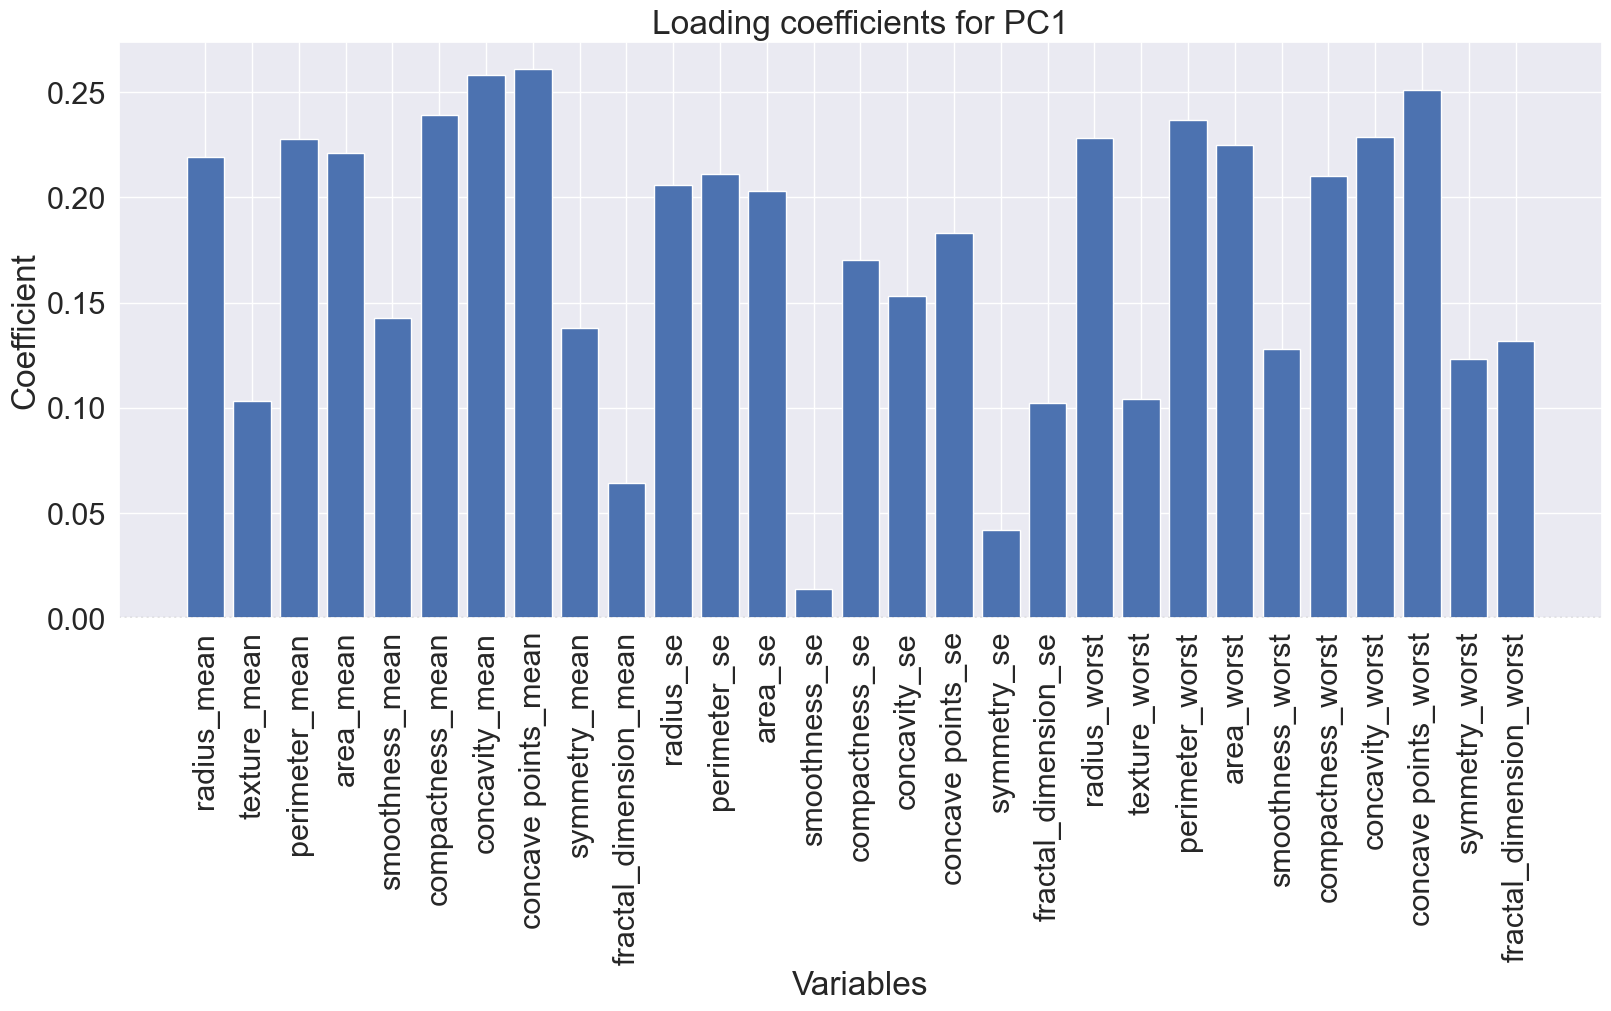

In [69]:
pca_1d_loadings(
        pca,
        wisconsin_var.columns,
        select_components={1},
        plot_type='bar',
    )
plt.show()

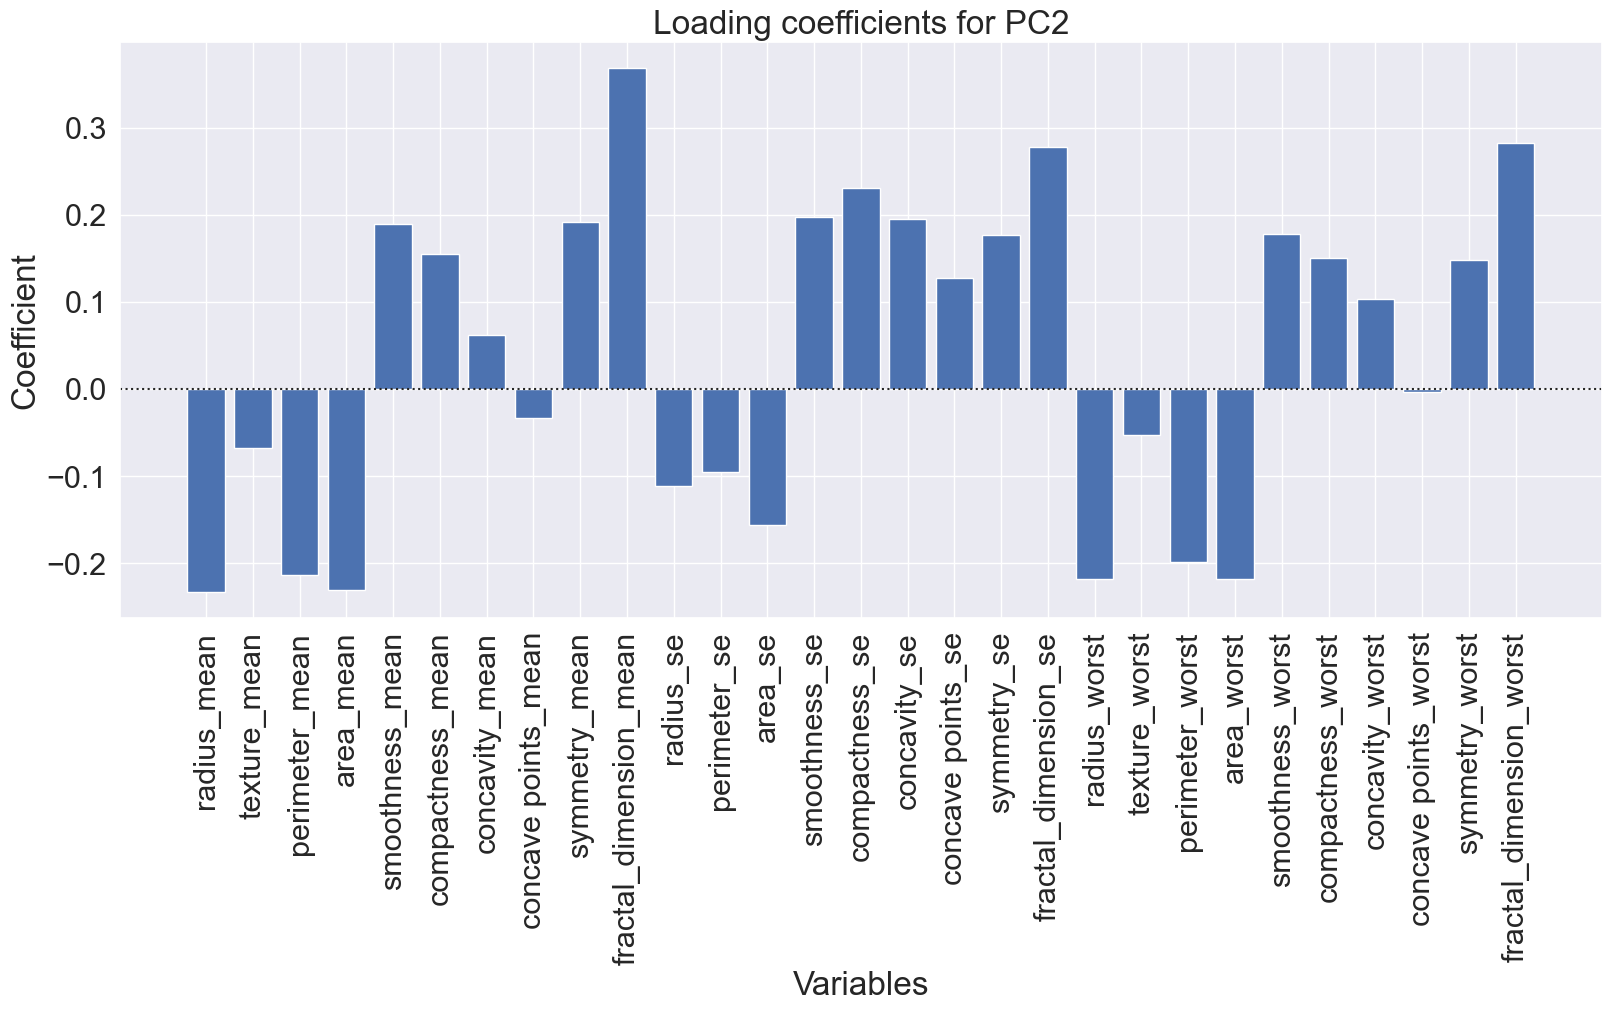

In [70]:
pca_1d_loadings(
        pca,
        wisconsin_var.columns,
        select_components={2},
        plot_type='bar',
    )
plt.show()

Grafique tanto el componente 1 como el 2 porque el componente 1 es el que mayor cantidad de variables capta ya que es el que más variabilidad explica. Al graficar el componente 2 puedo ver qué variables tienen cargas altas en este componente y darles menos importancia en el componente 1.

Vemos que las variables que mayor carga tienen en el componente 2 son aquellas relacionadas al error estándard y la media de fractal dimension. Volviendo al componente 1 y sin considerar las variables anteriores las variables con mayores cargas con las de compactness, concativity y concave points tanto mean como worst y ademas radio, area y perimetro.

##### c. Crea el input con estas componentes (matriz de scores o puntuaciones) y ajusta un modelo de predicción adecuado para la variable objetivo diagnosis.

Guardo la variable diagnosis aparte y reemplazo los valores para que "M" se convierta en el evento y por ende tome el valor 1, mientras que dejo que "B" tome el valor 0. 

In [71]:
wisconsin_diag = wisconsin[['diagnosis']]
wisconsin_diag.head()

diagnosis
id                
842302           M
842517           M
84300903         M
84348301         M
84358402         M

In [72]:
wisconsin_diag['diagnosis'].replace({'M': 1, 'B': 0}, inplace=True)

In [73]:
wisconsin_diag.head()

diagnosis
id                 
842302            1
842517            1
84300903          1
84348301          1
84358402          1

Ahora realizo la particóin training test utilizando como variables explicativas los componentes de la matriz de puntuación que salió del PCA realizado en el punto anterior. Luego inento un modelo de regresión logística.

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scores_df, wisconsin_diag, test_size=0.2, random_state=1234)

print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (455, 3) (455, 1)
Testing dataset shape: (114, 3) (114, 1)


In [75]:
data_train = X_train.join(y_train.astype('int64'))

In [76]:
formula =ols_formula(data_train,'diagnosis')
formula

'diagnosis ~ CP1 + CP2 + CP3'

In [77]:
from statsmodels.formula.api import logit 

modeloCompleto = logit(formula,data=data_train).fit()
modeloCompleto.summary()

Optimization terminated successfully.
         Current function value: 0.071121
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              diagnosis   No. Observations:                  455
Model:                          Logit   Df Residuals:                      451
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Jun 2023   Pseudo R-squ.:                  0.8918
Time:                        20:11:36   Log-Likelihood:                -32.360
converged:                       True   LL-Null:                       -299.10
Covariance Type:            nonrobust   LLR p-value:                2.653e-115
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2319      0.373     -3.306      0.001      -1.962      -0.502
CP1            3.2221      0.603      5.347      0.000       2.041       4.403
CP2           -1.5849      0.352     -4.502      0.000      -2.275      -0.895
CP3           -0.8712      0.215     -4.055      0.000      -1.292      -0.450
==============================================================================

Possibly complete quasi-separation: A fraction 0.51 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

El pseudo R cuadrado es muy alto pero supongo que se debe a que estoy utilizando como variabes explicativas tres componentes que engloban muchas variables del dataset original. A su vez los 3 componentes resultan ser signivicativos para explicar el comportamiento de la variable diagnosis.

##### d. Conclusiones del modelo por validación cruzada repetida. Interpreta el parámetro de la componente 1.

In [78]:
data_completa = scores_df.join(wisconsin_diag.astype('int64'))

In [79]:
cross_val_log(formula,data=data_completa)

Modelo: diagnosis ~ CP1 + CP2 + CP3
AUC: 0.992 (0.006)


array([0.98247354, 0.98971037, 1.        , 1.        , 0.98517086,
       0.97838192, 0.99669312, 0.99737963, 0.99594595, 0.99077734,
       0.99047317, 0.99714195, 0.98571429, 0.99383117, 0.99558233,
       0.99262899, 1.        , 0.98689258, 0.98615137, 0.99762873,
       0.99632476, 0.99338624, 0.98663548, 0.98113811, 0.99731724,
       0.97230769, 0.99491902, 0.99863248, 0.99371693, 0.99705882,
       0.98930839, 0.99695946, 0.9987013 , 0.98587127, 0.98982456,
       0.99632353, 0.98669966, 0.99066023, 0.99031073, 0.996535  ,
       0.99434851, 0.98550725, 0.99810606, 0.99403299, 0.99090909,
       0.98632479, 0.99290541, 0.99448052, 0.98926593, 0.99778621,
       0.99493243, 0.98744113, 0.99935065, 0.99333099, 0.98356808,
       0.995625  , 0.97648298, 0.99669118, 0.99355878, 0.99351071,
       0.99863248, 0.99410416, 0.9921875 , 0.99384615, 0.98170732,
       0.99760684, 0.99537037, 0.99159664, 0.98412162, 0.99415964,
       0.99648338, 0.995788  , 0.9973271 , 0.98393162, 0.98596

In [80]:
np.exp(modeloCompleto.params)

Intercept     0.291740
CP1          25.081904
CP2           0.204966
CP3           0.418433
dtype: float64

La interpretacion seria que la probabilidad de diagnosis de tumor maligno es 19 veces mayor con el aumento de una unidad del Componente 1. La interpretación no es tan simple dado que el componente es una combinación lineal de muchas variables, pero podemos observar que tiene un efecto positivo y alto sobre la probabilidad de ser diagnosticado con un tumor maligno. Cuanto más altos sean los valores de las variables que identificamos previamente con cargas altas en el Componente 1, más probable es recibir un disgnostico negativo.

# Ejercicio 4

#### 1. Escoge 10 variables numéricas presentes en el conjunto de datos y realiza un ligera depuración sobre este subconjunto de variables (Valores raros, Outliers, NAs..)

In [81]:
elecciones_ESP = pd.read_excel(r'DatosEleccionesEspaña.xlsx')
elecciones_ESP.head()

Name  CodigoProvincia         CCAA  Population  TotalCensus  \
0    Abadía               10  Extremadura         336          282   
1  Abertura               10  Extremadura         429          364   
2     Acebo               10  Extremadura         569          569   
3  Acehúche               10  Extremadura         822          704   
4  Aceituna               10  Extremadura         623          540   

   AbstentionPtge  AbstencionAlta  Izda_Pct  Dcha_Pct  Otros_Pct  ...  \
0          20.213               0    60.444    35.555      1.778  ...   
1          25.275               0    54.779    44.118      0.368  ...   
2          27.241               0    44.203    53.140      0.966  ...   
3          30.114               1    50.813    45.325      0.000  ...   
4          30.185               1    44.562    49.867      0.796  ...   

   ComercTTEHosteleria  Servicios  ActividadPpal  inmuebles  Pob2010  \
0                  0.0        0.0           Otro      216.0    326.0   
1                  0.0        0.0           Otro      382.0    459.0   
2                  0.0        0.0           Otro      918.0    674.0   
3                  0.0        0.0           Otro      599.0    842.0   
4                  0.0        0.0           Otro      394.0    625.0   

   SUPERFICIE  Densidad  PobChange_pct  PersonasInmueble  Explotaciones  
0   4507.5593   MuyBaja           3.07              1.56             28  
1   6270.7646   MuyBaja          -6.54              1.12             67  
2   5702.1000   MuyBaja         -15.58              0.62             74  
3   9106.4649   MuyBaja          -2.38              1.37             66  
4   4007.6141   MuyBaja          -0.32              1.58             96  

[5 rows x 41 columns]

In [82]:
elecciones_ESP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8119 entries, 0 to 8118
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          8119 non-null   object 
 1   CodigoProvincia               8119 non-null   int64  
 2   CCAA                          8119 non-null   object 
 3   Population                    8119 non-null   int64  
 4   TotalCensus                   8119 non-null   int64  
 5   AbstentionPtge                8119 non-null   float64
 6   AbstencionAlta                8119 non-null   int64  
 7   Izda_Pct                      8119 non-null   float64
 8   Dcha_Pct                      8119 non-null   float64
 9   Otros_Pct                     8119 non-null   float64
 10  Izquierda                     8119 non-null   int64  
 11  Derecha                       8119 non-null   int64  
 12  Age_0-4_Ptge                  8119 non-null   float64
 13  Age

In [83]:
elecciones_ESP.describe()

CodigoProvincia    Population   TotalCensus  AbstentionPtge  \
count      8119.000000  8.119000e+03  8.119000e+03     8119.000000   
mean         26.670772  5.741855e+03  4.260666e+03       26.506951   
std          14.896717  4.621520e+04  3.442889e+04        7.540091   
min           1.000000  5.000000e+00  5.000000e+00        0.000000   
25%          13.000000  1.660000e+02  1.400000e+02       21.678000   
50%          26.000000  5.490000e+02  4.470000e+02       26.429000   
75%          41.000000  2.427500e+03  1.846500e+03       31.475000   
max          52.000000  3.141991e+06  2.363829e+06       57.576000   

       AbstencionAlta     Izda_Pct     Dcha_Pct    Otros_Pct    Izquierda  \
count     8119.000000  8119.000000  8119.000000  8119.000000  8119.000000   
mean         0.311368    34.403789    48.915409    14.666183     0.222811   
std          0.463082    16.482285    19.945087    25.093642     0.416158   
min          0.000000     0.000000     0.000000     0.000000     0.000000   
25%          0.000000    21.892500    38.690500     0.759500     0.000000   
50%          0.000000    35.165000    51.582000     1.883000     0.000000   
75%          1.000000    46.032000    62.201000    16.497000     0.000000   
max          1.000000    94.117000   100.000000   100.000000     1.000000   

           Derecha  ...     Industria  Construccion  ComercTTEHosteleria  \
count  8119.000000  ...   7931.000000   7980.000000          8110.000000   
mean      0.621136  ...     23.419367     48.878321           146.735265   
std       0.485134  ...    158.610811    421.863266          1233.023418   
min       0.000000  ...      0.000000      0.000000             0.000000   
25%       0.000000  ...      0.000000      0.000000             0.000000   
50%       1.000000  ...      0.000000      0.000000             0.000000   
75%       1.000000  ...     14.000000     25.000000            65.000000   
max       1.000000  ...  10521.000000  30343.000000         80856.000000   

           Servicios     inmuebles       Pob2010     SUPERFICIE  \
count    8057.000000  7.981000e+03  8.112000e+03    8110.000000   
mean      172.149684  3.246160e+03  5.795812e+03    6214.695257   
std      2446.812300  2.431471e+04  4.753568e+04    9218.194603   
min         0.000000  6.000000e+00  5.000000e+00       2.578400   
25%         0.000000  1.800000e+02  1.777500e+02    1839.191800   
50%         0.000000  4.860000e+02  5.820000e+02    3487.737450   
75%        40.000000  1.589000e+03  2.483000e+03    6893.877800   
max    177677.000000  1.615548e+06  3.273049e+06  175022.910000   

       PobChange_pct  PersonasInmueble  Explotaciones  
count    8112.000000       7981.000000    8119.000000  
mean       -4.897406          1.296009    2447.204582  
std        10.383417          0.566620   15062.738051  
min       -52.270000          0.110000       1.000000  
25%       -10.400000          0.850000      22.000000  
50%        -4.960000          1.250000      52.000000  
75%         0.092500          1.730000     137.000000  
max       138.460000          3.330000   99999.000000  

[8 rows x 37 columns]

Elijo las variables TotalCensus, Izda_Pct, Dcha_Pct, Age_19_65_pct, Age_over65_pct, WomanPopulationPtge, ForeignersPtge, UnemployLess25_Ptge, Unemploy25_40_Ptge, totalEmpresas

In [84]:
datos_ESP = elecciones_ESP[['CCAA','TotalCensus', 'Izda_Pct','Dcha_Pct', 'Age_19_65_pct', 'Age_over65_pct', 'WomanPopulationPtge', 'ForeignersPtge', 'IndustryUnemploymentPtge', 'ServicesUnemploymentPtge', 'totalEmpresas']]
datos_ESP.head()

CCAA  TotalCensus  Izda_Pct  Dcha_Pct  Age_19_65_pct  \
0  Extremadura          282    60.444    35.555         55.059   
1  Extremadura          364    54.779    44.118         56.643   
2  Extremadura          569    44.203    53.140         54.834   
3  Extremadura          704    50.813    45.325         60.098   
4  Extremadura          540    44.562    49.867         59.391   

   Age_over65_pct  WomanPopulationPtge  ForeignersPtge  \
0          26.785               44.048            0.89   
1          30.304               50.117            1.63   
2          36.028               49.033            0.70   
3          24.940               51.095            0.12   
4          25.042               48.154            0.64   

   IndustryUnemploymentPtge  ServicesUnemploymentPtge  totalEmpresas  
0                     9.524                    73.810           15.0  
1                     8.108                    67.568           11.0  
2                     9.836                    49.180           49.0  
3                     5.556                    59.259           50.0  
4                     0.000                    61.538           22.0

In [85]:
datos_ESP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8119 entries, 0 to 8118
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CCAA                      8119 non-null   object 
 1   TotalCensus               8119 non-null   int64  
 2   Izda_Pct                  8119 non-null   float64
 3   Dcha_Pct                  8119 non-null   float64
 4   Age_19_65_pct             8119 non-null   float64
 5   Age_over65_pct            8119 non-null   float64
 6   WomanPopulationPtge       8119 non-null   float64
 7   ForeignersPtge            8119 non-null   float64
 8   IndustryUnemploymentPtge  8119 non-null   float64
 9   ServicesUnemploymentPtge  8119 non-null   float64
 10  totalEmpresas             8114 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 697.9+ KB


In [86]:
datos_ESP.describe()

TotalCensus     Izda_Pct     Dcha_Pct  Age_19_65_pct  Age_over65_pct  \
count  8.119000e+03  8119.000000  8119.000000    8119.000000     8119.000000   
mean   4.260666e+03    34.403789    48.915409      57.371541       29.073583   
std    3.442889e+04    16.482285    19.945087       6.818072       11.745849   
min    5.000000e+00     0.000000     0.000000      23.459000        0.000000   
25%    1.400000e+02    21.892500    38.690500      53.845000       19.824500   
50%    4.470000e+02    35.165000    51.582000      58.655000       27.559000   
75%    1.846500e+03    46.032000    62.201000      61.818000       36.908000   
max    2.363829e+06    94.117000   100.000000     100.002000       76.471000   

       WomanPopulationPtge  ForeignersPtge  IndustryUnemploymentPtge  \
count          8119.000000     8119.000000               8119.000000   
mean             47.302755        5.619553                 10.007836   
std               4.361907        7.348553                 12.528441   
min              11.765000       -8.960000                  0.000000   
25%              45.725000        1.060000                  0.000000   
50%              48.485000        3.590000                  7.143000   
75%              50.000000        8.180000                 14.286000   
max              72.683000       71.470000                100.000000   

       ServicesUnemploymentPtge  totalEmpresas  
count               8119.000000    8114.000000  
mean                  58.649705     398.603032  
std                   24.259562    4219.366083  
min                    0.000000       0.000000  
25%                   50.000000       7.000000  
50%                   62.018000      30.000000  
75%                   72.123000     147.000000  
max                  100.000000  299397.000000

Cont


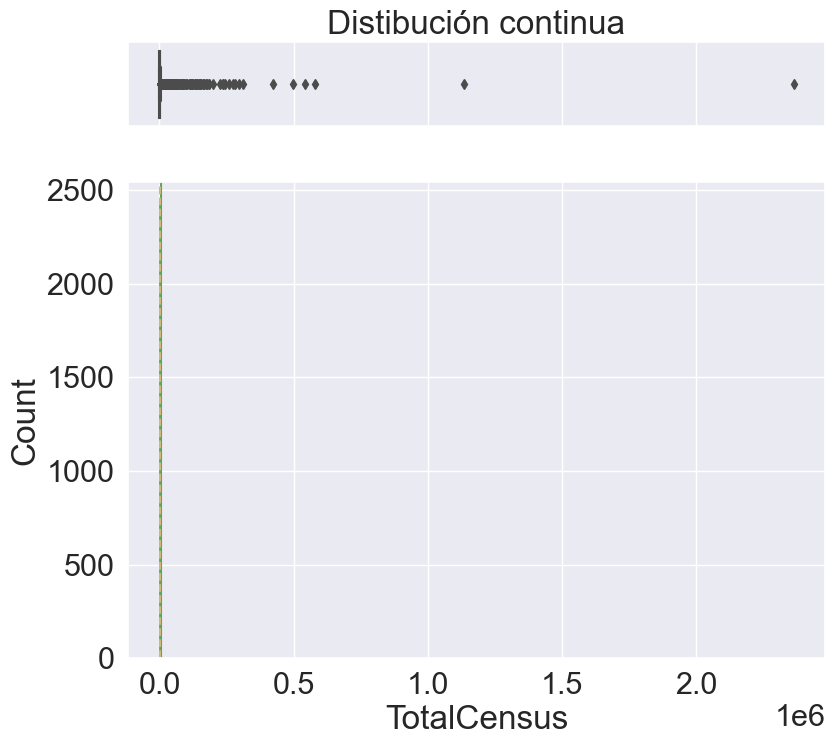

Cont


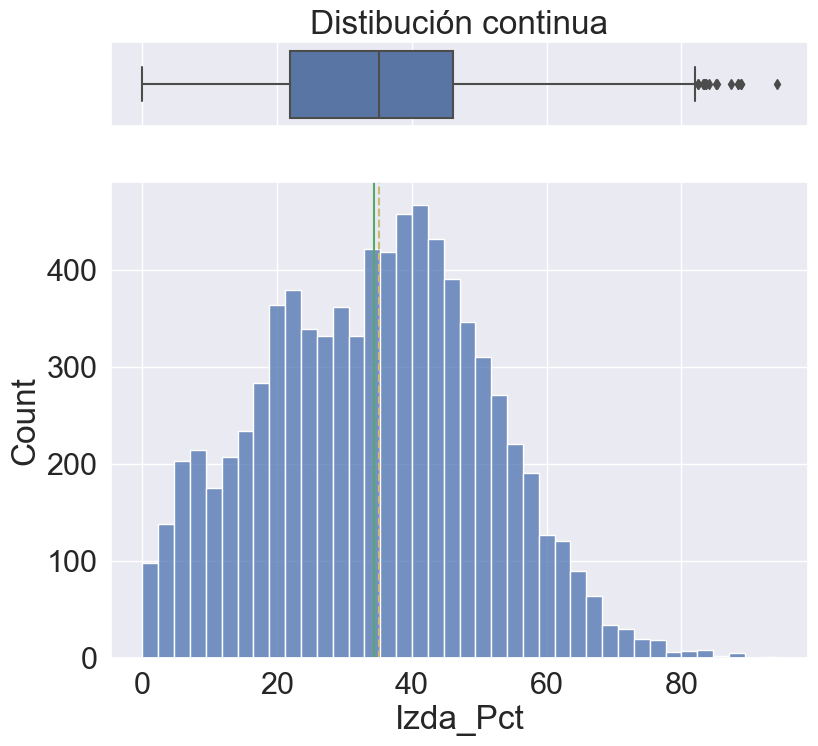

Cont


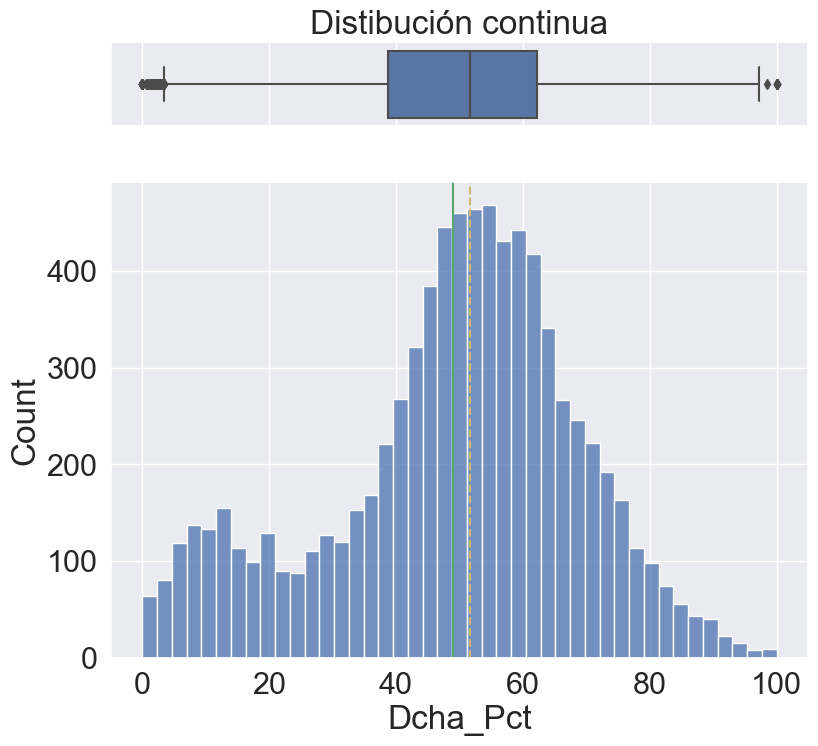

Cont


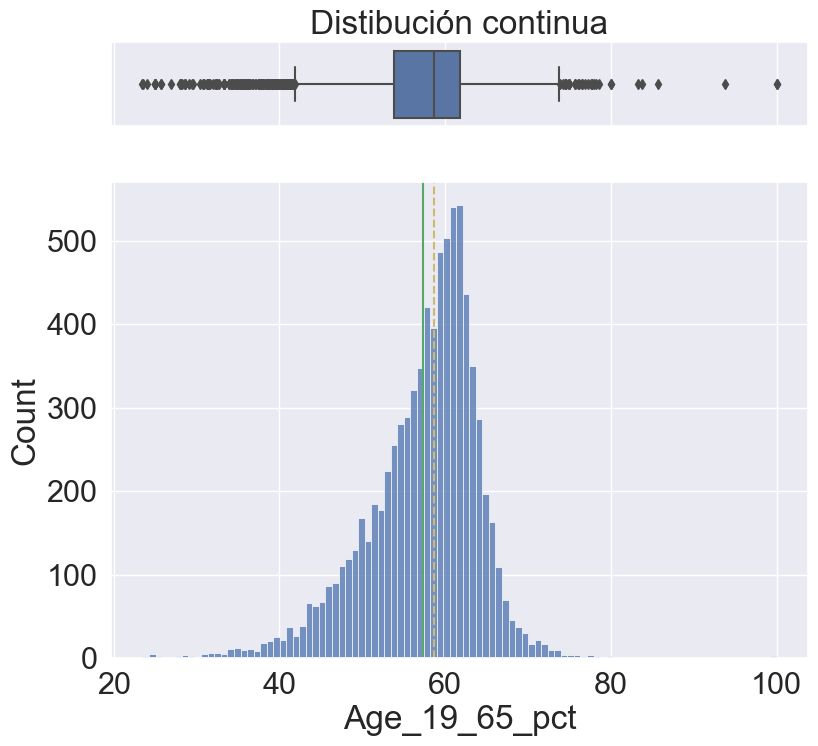

Cont


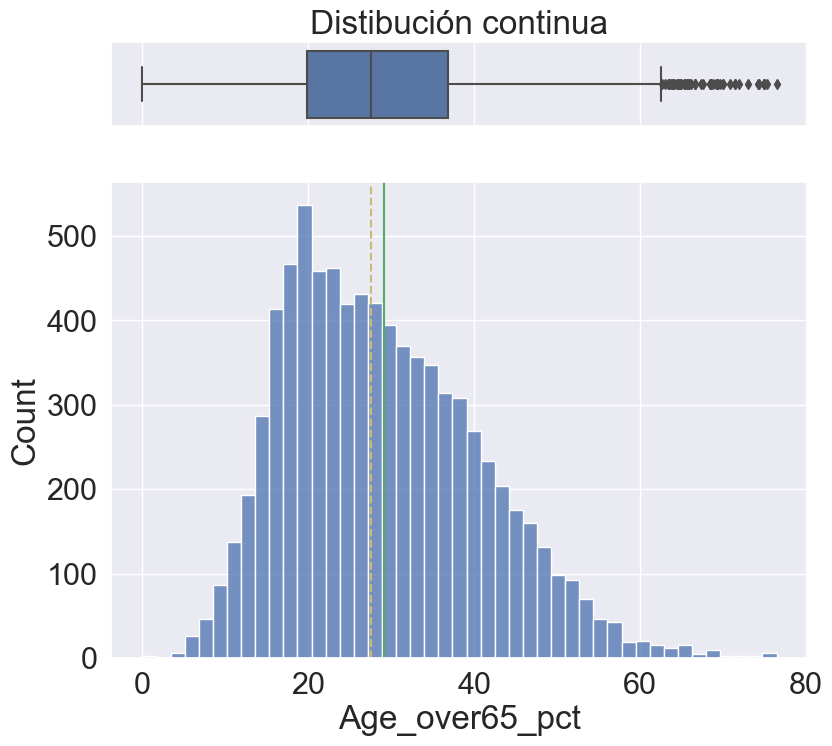

Cont


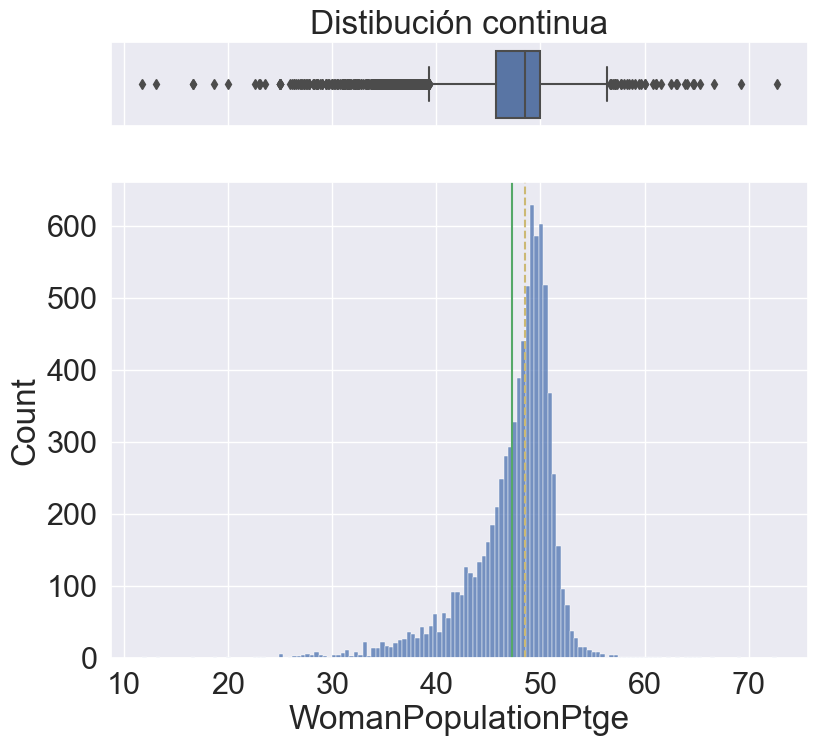

Cont


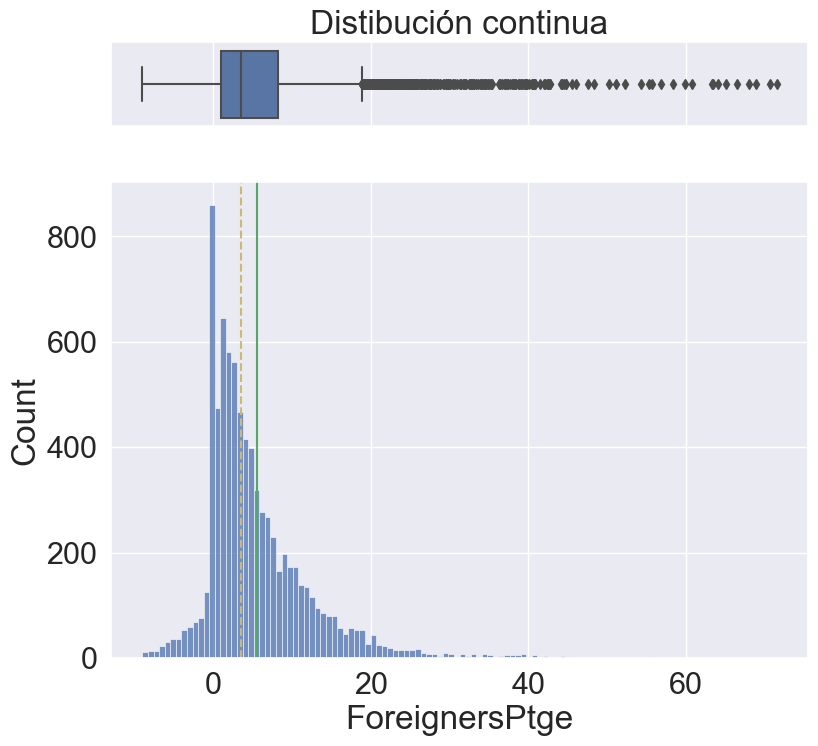

Cont


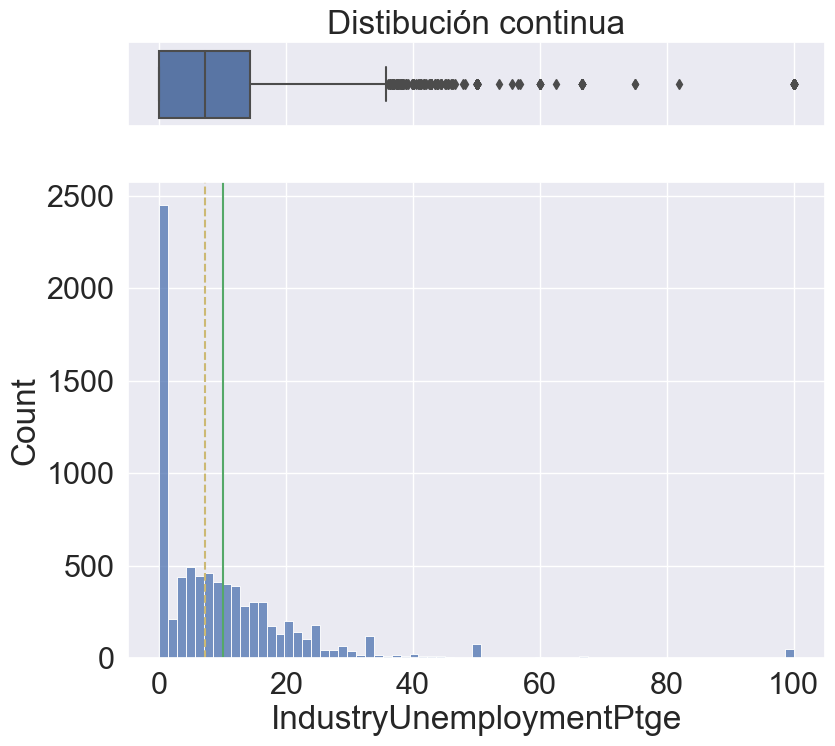

Cont


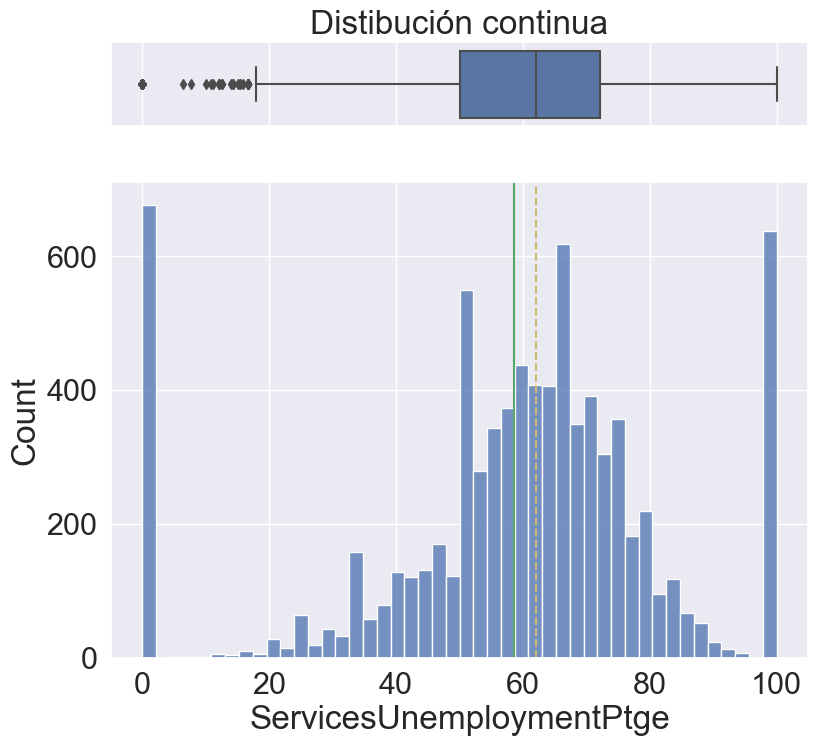

Cont


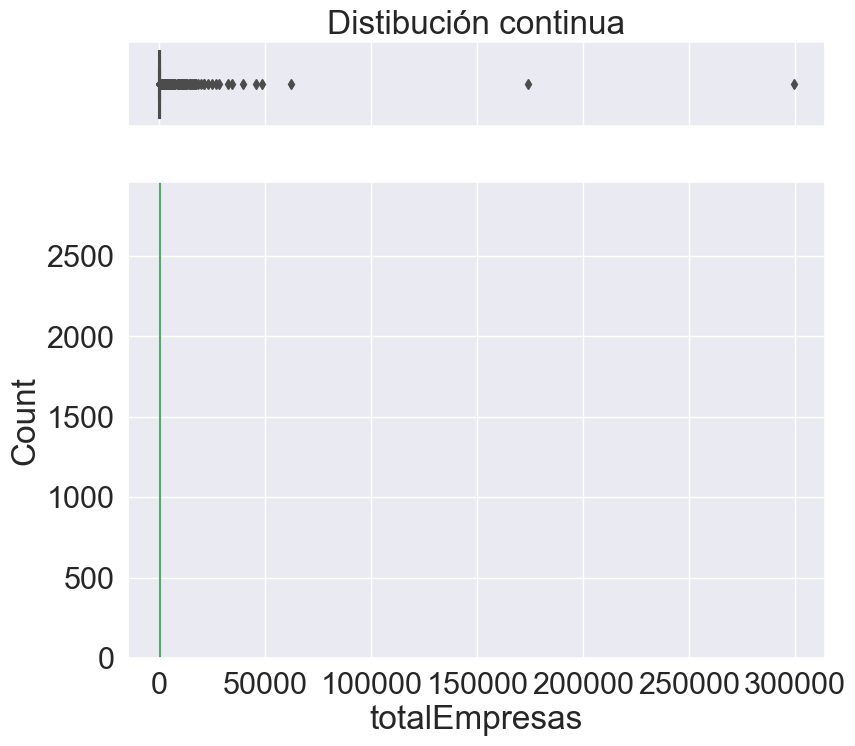

TotalCensus                 None
Izda_Pct                    None
Dcha_Pct                    None
Age_19_65_pct               None
Age_over65_pct              None
WomanPopulationPtge         None
ForeignersPtge              None
IndustryUnemploymentPtge    None
ServicesUnemploymentPtge    None
totalEmpresas               None
dtype: object

In [87]:
datos_ESP.iloc[:,1:11].apply(plot)

La variable de población en edad de censo (TotalCensus) no la voy a tocar, su distribución se debe a que las localidades tienen tamaños poblacionales muy distintos entre sí. 

Problemas:
- ForeingersPtge tiene valores negativos, que es imposible porque estamos hablando de porcentajes. 
- total empresas tiene valores muy grandes y 5 missings.
- Age_19_65_pct tiene un valor mayor a 100%
- Las variables de unemployment tienen muchos valores en 0 y 100 lo cual resulta extraño porque parece raro que en varias localidades no haya nadie empleado en cierto rubro o que la ocupación sea total.

Como primer paso voy a convertir en valores missing aquellos porcentajes imposibles de las variables ForeingersPtge y Age_19_65_pct. Además voy a convertir en missing los 0 y 100 de las variables de desempleo. Estos missings luego los voy a reemplazar por la moda de cada Comunidad Autónoma. 

In [88]:
datos_ESP.loc[~datos_ESP.Age_19_65_pct.between(0, 100), "Age_19_65_pct"] = np.nan

In [89]:
datos_ESP.loc[~datos_ESP.ForeignersPtge.between(0, 100), "ForeignersPtge"] = np.nan

In [90]:
datos_ESP.loc[~datos_ESP.IndustryUnemploymentPtge.between(1, 99), "IndustryUnemploymentPtge"] = np.nan

In [91]:
datos_ESP.loc[~datos_ESP.ServicesUnemploymentPtge.between(1, 99), "ServicesUnemploymentPtge"] = np.nan

Ahora paso a hacer el reemplazo de los valores missing por la moda. Para lograrlo voy a calcular la moda de cada una de las variables agregadas por CCAA. De ahí paso estas series a diccionarios y hago el reemplazo. Como son muchos missings siento que si reemplazo estos valores por la media/mediana/moda general los clusters van a a ser más difíciles de definir.

In [92]:
moda_IndUn = datos_ESP.groupby('CCAA')['IndustryUnemploymentPtge'].apply(lambda x: x.mode().values[0])
moda_IndUn

CCAA
Andalucía          3.846
Aragón            20.000
Asturias           8.333
Baleares           4.651
Canarias           1.938
Cantabria          6.250
CastillaLeón      25.000
CastillaMancha     7.143
Cataluña          20.000
Ceuta              4.457
ComValenciana     25.000
Extremadura        4.000
Galicia            8.000
Madrid            16.667
Melilla            1.324
Murcia             3.243
Navarra           20.000
PaísVasco         25.000
Rioja             20.000
Name: IndustryUnemploymentPtge, dtype: float64

In [93]:
moda_SerUn = datos_ESP.groupby('CCAA')['ServicesUnemploymentPtge'].apply(lambda x: x.mode().values[0])
moda_SerUn

CCAA
Andalucía         50.000
Aragón            50.000
Asturias          58.333
Baleares          50.000
Canarias          48.936
Cantabria         66.667
CastillaLeón      50.000
CastillaMancha    50.000
Cataluña          50.000
Ceuta             71.200
ComValenciana     50.000
Extremadura       66.667
Galicia           50.000
Madrid            87.500
Melilla           69.407
Murcia            38.383
Navarra           66.667
PaísVasco         50.000
Rioja             50.000
Name: ServicesUnemploymentPtge, dtype: float64

In [94]:
mapping_dict_ser = moda_SerUn.to_dict()
datos_ESP['ServicesUnemploymentPtge'] = datos_ESP.apply(lambda row: row['ServicesUnemploymentPtge'] if pd.notnull(row['ServicesUnemploymentPtge']) else mapping_dict_ser.get(row['CCAA']), axis=1)

In [95]:
mapping_dict_ind = moda_IndUn.to_dict()
datos_ESP['IndustryUnemploymentPtge'] = datos_ESP.apply(lambda row: row['IndustryUnemploymentPtge'] if pd.notnull(row['IndustryUnemploymentPtge']) else mapping_dict_ind.get(row['CCAA']), axis=1)

Voy a hacer lo mismo para la variable de porcentaje de extranjeros.

In [96]:
moda_For= datos_ESP.groupby('CCAA')['ForeignersPtge'].apply(lambda x: x.mode().values[0])
mapping_dict_for = moda_For.to_dict()
datos_ESP['ForeignersPtge'] = datos_ESP.apply(lambda row: row['ForeignersPtge'] if pd.notnull(row['ForeignersPtge']) else mapping_dict_for.get(row['CCAA']), axis=1)

In [97]:
moda_age= datos_ESP.groupby('CCAA')['Age_19_65_pct'].apply(lambda x: x.mode().values[0])
mapping_dict_age = moda_age.to_dict()
datos_ESP['Age_19_65_pct'] = datos_ESP.apply(lambda row: row['Age_19_65_pct'] if pd.notnull(row['Age_19_65_pct']) else mapping_dict_age.get(row['CCAA']), axis=1)

A continuación voy a winsorizar los outliers extremos de la variable total empresas y reemplazar los missings.

In [98]:
datos_ESP_winsor = datos_ESP[['totalEmpresas']].apply(lambda x: gestiona_outliers(x,clas='winsor'));

totalEmpresas


In [99]:
datos_ESP_2 = datos_ESP[['CCAA','TotalCensus', 'Izda_Pct','Dcha_Pct', 'Age_19_65_pct', 'Age_over65_pct', 'WomanPopulationPtge', 'ForeignersPtge', 'IndustryUnemploymentPtge', 'ServicesUnemploymentPtge']].join(datos_ESP_winsor)

In [100]:
moda_totemp= datos_ESP_2.groupby('CCAA')['totalEmpresas'].apply(lambda x: x.mode().values[0])
mapping_dict_totemp = moda_totemp.to_dict()
datos_ESP_2['totalEmpresas'] = datos_ESP_2.apply(lambda row: row['totalEmpresas'] if pd.notnull(row['totalEmpresas']) else mapping_dict_totemp.get(row['CCAA']), axis=1)
datos_ESP_2.head()

CCAA  TotalCensus  Izda_Pct  Dcha_Pct  Age_19_65_pct  \
0  Extremadura          282    60.444    35.555         55.059   
1  Extremadura          364    54.779    44.118         56.643   
2  Extremadura          569    44.203    53.140         54.834   
3  Extremadura          704    50.813    45.325         60.098   
4  Extremadura          540    44.562    49.867         59.391   

   Age_over65_pct  WomanPopulationPtge  ForeignersPtge  \
0          26.785               44.048            0.89   
1          30.304               50.117            1.63   
2          36.028               49.033            0.70   
3          24.940               51.095            0.12   
4          25.042               48.154            0.64   

   IndustryUnemploymentPtge  ServicesUnemploymentPtge  totalEmpresas  
0                     9.524                    73.810           15.0  
1                     8.108                    67.568           11.0  
2                     9.836                    49.180           49.0  
3                     5.556                    59.259           50.0  
4                     4.000                    61.538           22.0

In [101]:
datos_ESP_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8119 entries, 0 to 8118
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CCAA                      8119 non-null   object 
 1   TotalCensus               8119 non-null   int64  
 2   Izda_Pct                  8119 non-null   float64
 3   Dcha_Pct                  8119 non-null   float64
 4   Age_19_65_pct             8119 non-null   float64
 5   Age_over65_pct            8119 non-null   float64
 6   WomanPopulationPtge       8119 non-null   float64
 7   ForeignersPtge            8119 non-null   float64
 8   IndustryUnemploymentPtge  8119 non-null   float64
 9   ServicesUnemploymentPtge  8119 non-null   float64
 10  totalEmpresas             8119 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 697.9+ KB


#### 2. Agrega los valores por CCAA, distinguiendo entre valores relativos (agregación por la media) y valores absolutos (agregación por suma)

In [102]:
datos_ESP_agg= datos_ESP_2.groupby(['CCAA']).agg({'TotalCensus':'sum','Izda_Pct':'mean','Dcha_Pct':'mean','Age_19_65_pct':'mean','Age_over65_pct':'mean','WomanPopulationPtge':'mean',
                            'ForeignersPtge':'mean','IndustryUnemploymentPtge':'mean','ServicesUnemploymentPtge':'mean','totalEmpresas':'sum'})

In [103]:
datos_ESP_agg

TotalCensus   Izda_Pct   Dcha_Pct  Age_19_65_pct  \
CCAA                                                               
Andalucía           6279879  55.177999  41.409270      60.876649   
Aragón               984289  41.598175  54.711115      55.521389   
Asturias             872130  49.701974  46.295385      58.626064   
Baleares             749065  44.388761  48.681119      62.421522   
Canarias            1535589  39.926080  45.635125      64.421011   
Cantabria            462697  38.197441  58.299588      61.367000   
CastillaLeón        1990607  31.514937  64.860948      54.563655   
CastillaMancha      1540063  42.159800  54.733021      55.311953   
Cataluña            5313563   9.709147  15.489498      60.009161   
Ceuta                 59125  33.027000  62.709000      61.811000   
ComValenciana       3519941  22.619101  49.068886      59.472661   
Extremadura          880546  51.445243  45.760687      57.336966   
Galicia             2257941  22.624306  55.873277      55.989828   
Madrid              4662855  38.733570  57.527793      62.678698   
Melilla               53307  34.417000  61.451000      60.640000   
Murcia              1005154  37.337111  59.297022      61.581400   
Navarra              477733  40.204996  35.973989      58.106338   
PaísVasco           1714958  31.297908   9.794203      60.657606   
Rioja                232902  37.199534  59.471718      57.214155   

                Age_over65_pct  WomanPopulationPtge  ForeignersPtge  \
CCAA                                                                  
Andalucía            20.938508            49.366288        5.879004   
Aragón               33.307423            45.753094        6.833078   
Asturias             29.810372            49.841897        2.495769   
Baleares             17.805015            49.460373       14.756119   
Canarias             17.617239            49.451693       10.725568   
Cantabria            24.182500            47.716373        2.840784   
CastillaLeón         36.713069            45.622654        3.513043   
CastillaMancha       32.234108            46.331884        6.616605   
Cataluña             21.316567            48.409210        8.573231   
Ceuta                11.028000            49.258000        6.110000   
ComValenciana        24.188871            48.963561       10.833376   
Extremadura          28.283207            49.124680        1.946796   
Galicia              32.356656            50.631452        2.356911   
Madrid               15.980966            48.564251       12.256536   
Melilla               9.684000            49.064000       15.120000   
Murcia               16.525956            49.159578       12.783778   
Navarra              25.958614            46.936813        4.803235   
PaísVasco            20.066888            48.836092        4.643307   
Rioja                32.763080            43.487810        5.932356   

                IndustryUnemploymentPtge  ServicesUnemploymentPtge  \
CCAA                                                                 
Andalucía                       6.306005                 55.599255   
Aragón                         19.542332                 55.289408   
Asturias                       10.006410                 64.149731   
Baleares                        6.530925                 67.592612   
Canarias                        3.890466                 72.823102   
Cantabria                       8.636971                 69.295902   
CastillaLeón                   20.325605                 56.121210   
CastillaMancha                 10.041207                 58.429951   
Cataluña                       17.623517                 62.327107   
Ceuta                           4.457000                 71.200000   
ComValenciana                  16.387605                 63.861238   
Extremadura                     6.546625                 62.451762   
Galicia                        12.735503                 58.911366   
Madrid                          9.093771     

#### 3. Valora la necesidad de escalar los datos y decide el tipo de distancia a aplicar

Escalo los datos porque tengo unidades de medida distinatas para las variables.

In [104]:
from sklearn.preprocessing import scale
datos_ESP_scaled = scale(datos_ESP_agg)
datos_ESP_scaled_df = pd.DataFrame(datos_ESP_scaled, columns=datos_ESP_agg.columns, index=datos_ESP_agg.index)

In [105]:
datos_ESP_scaled_df

TotalCensus  Izda_Pct  Dcha_Pct  Age_19_65_pct  \
CCAA                                                             
Andalucía          2.506565  1.750486 -0.508933       0.537576   
Aragón            -0.470124  0.449270  0.408073      -1.412502   
Asturias          -0.533170  1.225774 -0.172093      -0.281958   
Baleares          -0.602345  0.716663 -0.007624       1.100129   
Canarias          -0.160235  0.289050 -0.217610       1.828228   
Cantabria         -0.763315  0.123412  0.655456       0.716133   
CastillaLeón       0.095534 -0.516904  1.107785      -1.761254   
CastillaMancha    -0.157720  0.503085  0.409583      -1.488767   
Cataluña           1.963392 -2.606330 -2.295797       0.221686   
Ceuta             -0.990166 -0.372018  0.959433       0.877812   
ComValenciana      0.955184 -1.369301  0.019107       0.026324   
Extremadura       -0.528439  1.392814 -0.208954      -0.751373   
Galicia            0.245805 -1.368802  0.488190      -1.241924   
Madrid             1.597624  0.174784  0.602250       1.193778   
Melilla           -0.993436 -0.238829  0.872709       0.451401   
Murcia            -0.458396  0.040976  0.724218       0.794205   
Navarra           -0.754863  0.315776 -0.883632      -0.471212   
PaísVasco         -0.059410 -0.537699 -2.688421       0.457812   
Rioja             -0.892484  0.027793  0.736261      -0.796094   

                Age_over65_pct  WomanPopulationPtge  ForeignersPtge  \
CCAA                                                                  
Andalucía            -0.362547             0.661649       -0.346634   
Aragón                1.247181            -1.404916       -0.116622   
Asturias              0.792064             0.933673       -1.162280   
Baleares             -0.770349             0.715460        1.793501   
Canarias             -0.794787             0.710496        0.821797   
Cantabria             0.059636            -0.282020       -1.079102   
CastillaLeón          1.690403            -1.479521       -0.917031   
CastillaMancha        1.107497            -1.073878       -0.168810   
Cataluña             -0.313345             0.114248        0.302902   
Ceuta                -1.652331             0.599713       -0.290945   
ComValenciana         0.060465             0.431309        0.847788   
Extremadura           0.593315             0.523461       -1.294629   
Galicia               1.123446             1.385258       -1.195756   
Madrid               -1.007737             0.202924        1.190890   
Melilla              -1.827243             0.488755        1.881227   
Murcia               -0.936810             0.543421        1.318000   
Navarra               0.290785            -0.727889       -0.605985   
PaísVasco            -0.475982             0.358403       -0.644542   
Rioja                 1.176339            -2.700544       -0.333772   

                IndustryUnemploymentPtge  ServicesUnemploymentPtge  \
CCAA                                                                 
Andalucía                      -0.902213                 -1.060933   
Aragón                          1.196630                 -1.107370   
Asturias                       -0.315452                  0.220534   
Baleares                       -0.866549                  0.736522   
Canarias                       -1.285238                  1.520420   
Cantabria                      -0.532599                  0.991795   
CastillaLeón                    1.320831                 -0.982707   
CastillaMancha                 -0.309934                 -0.636694   
Cataluña                        0.892370                 -0.052624   
Ceuta                          -1.195405                  1.277164   
ComValenciana                   0.696395                  0.177297   
Extremadura                    -0.864059                 -0.033942   
Galicia                         0.117292                 -0.564544   
Madrid                         -0.460166                  1.938550   
Melilla          

#### 4. Explora los métodos de clustering jerárquico para estos datos y decide el tipo de Linkage más adecuado.

In [106]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from time import time


def plot_dendogram(model, **kwargs):
  
  '''
  Esta función extrae la información de un modelo AgglomerativeClustering
  y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
  '''
      
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count
  
  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                        counts]).astype(float)
  
  # Plot
  dendrogram(linkage_matrix, **kwargs)
  plt.show()

ward :	0.00s


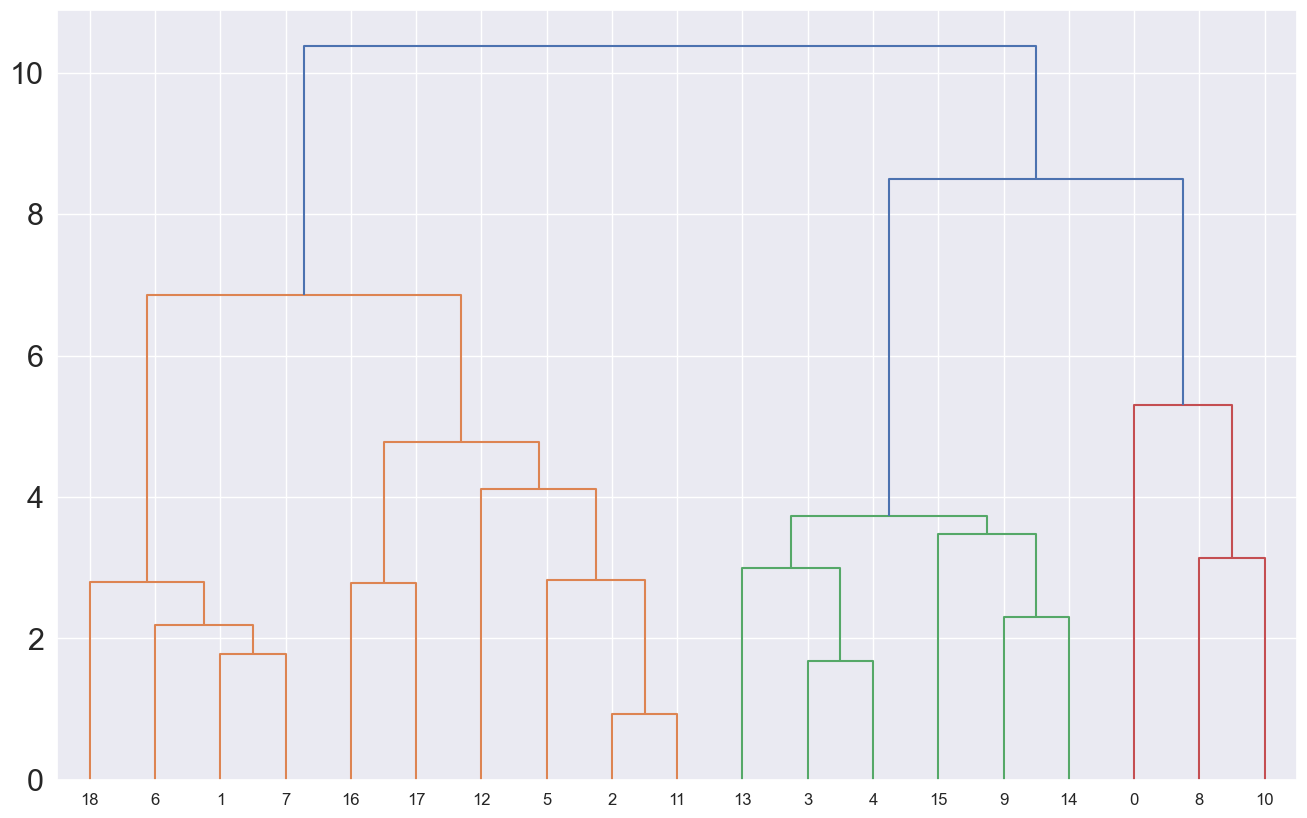

average :	0.00s


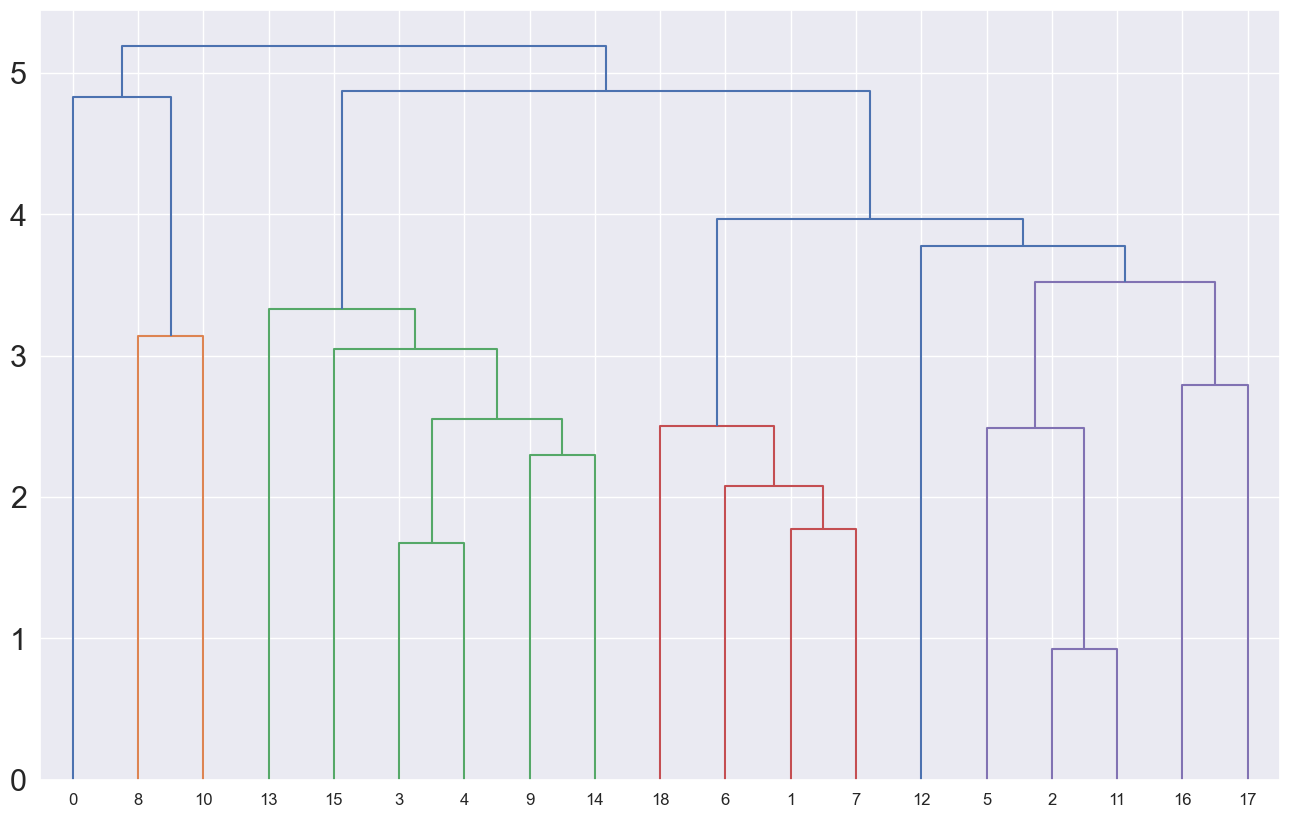

complete :	0.00s


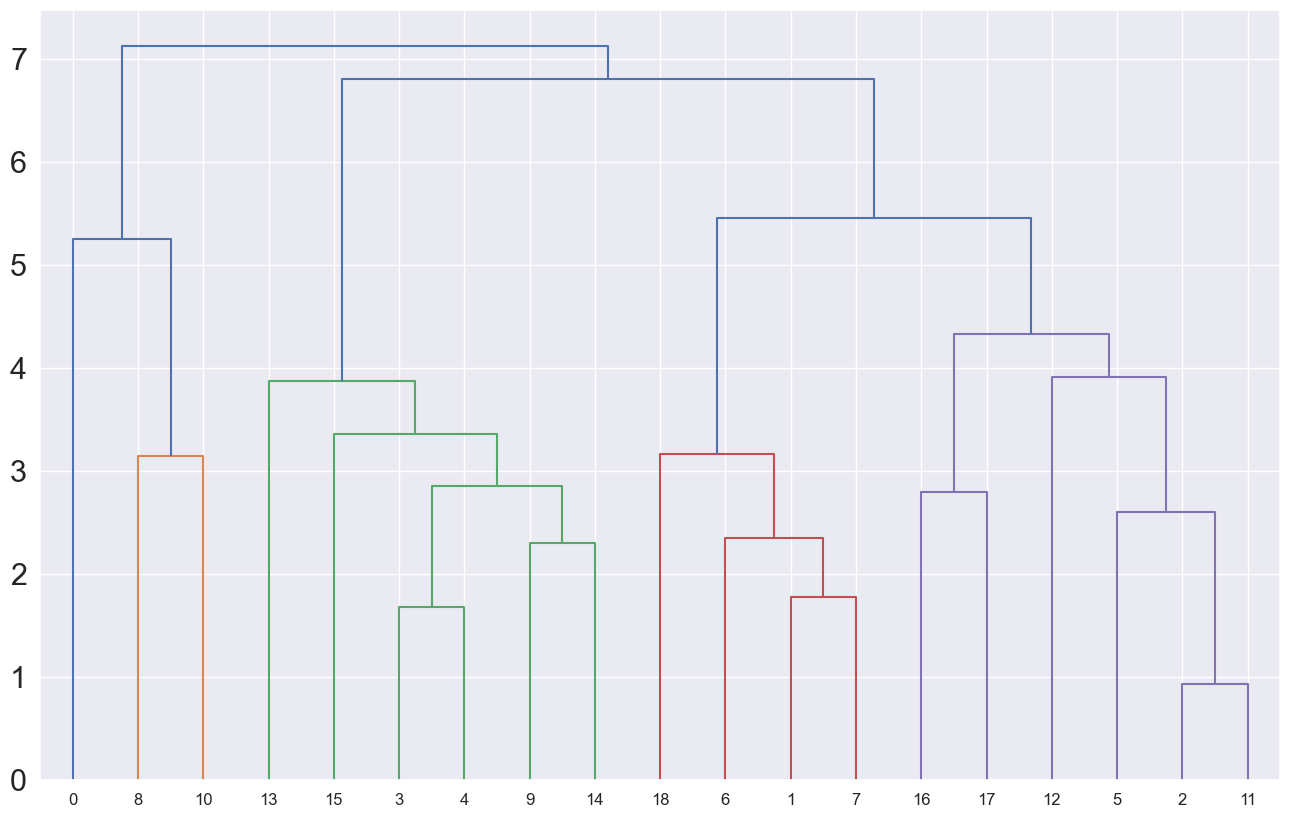

single :	0.01s


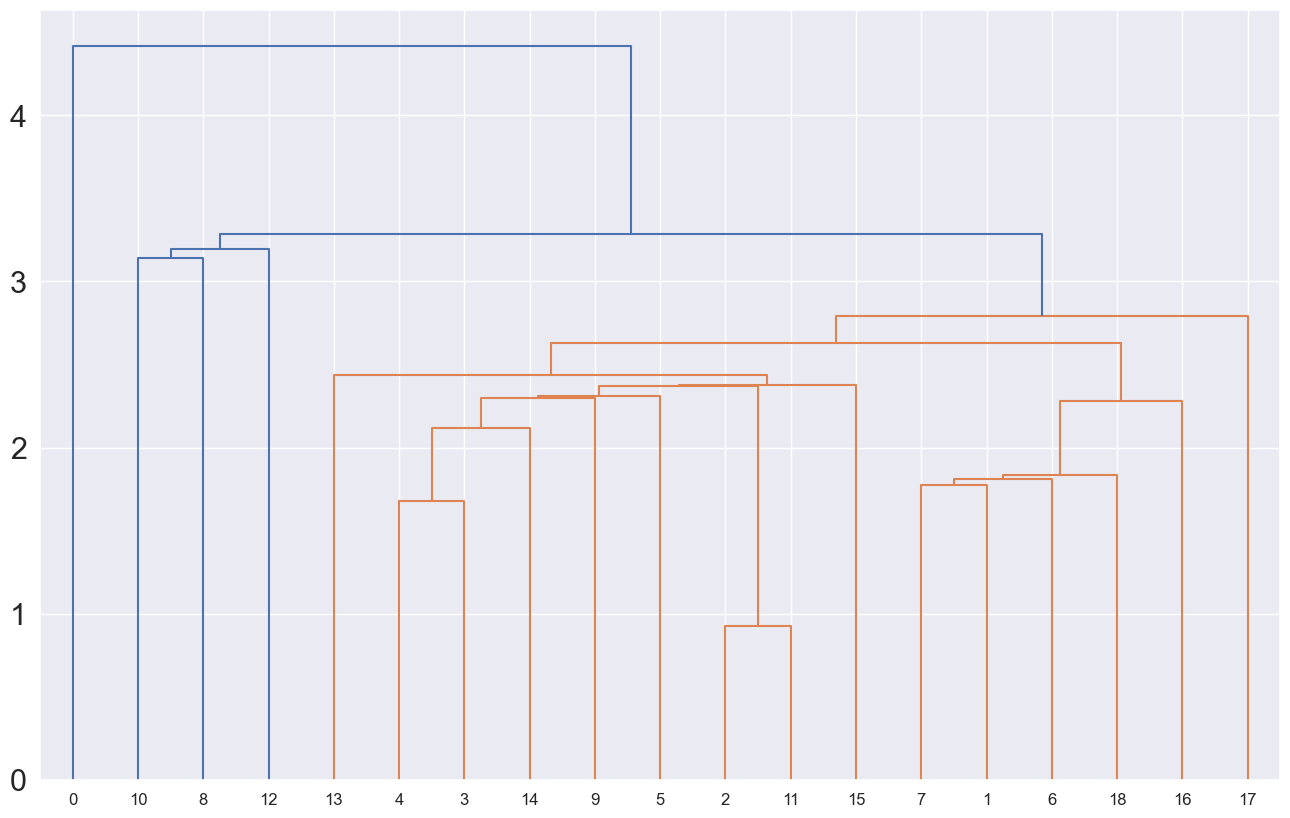

In [107]:
for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None,
                            distance_threshold = 0)
    t0 = time()
    clustering.fit(datos_ESP_scaled_df)
    print("%s :\t%.2fs" % (linkage, time() - t0))
    
    plt.clf()
    plot_dendogram(clustering)
    #plot_clustering(X_scaled, clustering.labels_, "%s linkage" % linkage)

El método de linkage completo parece ser el mejor. Las alturas de las separaciones son mayores que en el resto de los metodos y si corto en la linea de 2 quedan 16 clústers bien definidos.

#### 5. Toma una decisión sobre el número de clusters a considerar y realiza un análisis cluster mediante el método k-means.

In [108]:
from scipy.spatial.distance import cdist, pdist

def scree_plot_kmeans(data,n_max):
  range_n_clusters = range(2, n_max)
  X_scaled = scale(data)
  inertias = []
  silhouette = []
  var_perc = []
  
  for n_clusters in range_n_clusters:
      modelo_kmeans = KMeans(
                          n_clusters   = n_clusters, 
                          n_init       = 20, 
                          random_state = 123
                      )
      modelo_kmeans.fit(X_scaled)
      cluster_labels = modelo_kmeans.fit_predict(X_scaled)
      inertias.append(modelo_kmeans.inertia_)
      silhouette.append(silhouette_score(X_scaled, cluster_labels))
      tss = sum(pdist(X_scaled)**2)/X_scaled.shape[0]
      bss = tss - modelo_kmeans.inertia_
      var_perc.append(bss/tss*100)
      
  fig, ax = plt.subplots(1, 3, figsize=(16, 6))
  ax[0].plot(range_n_clusters, inertias, marker='o')
  ax[0].set_title("Scree plot Varianza intra")
  ax[0].set_xlabel('Número clusters')
  ax[0].set_ylabel('Intra-cluster (inertia)')
  
  ax[1].plot(range_n_clusters, silhouette, marker='o')
  ax[1].set_title("Scree plot silhouette")
  ax[1].set_xlabel('Número clusters')
  ax[1].set_ylabel('Media índices silhouette');
  
  ax[2].plot(range_n_clusters, var_perc, marker='o')
  ax[2].set_title("Scree plot % Varianza")
  ax[2].set_xlabel('Número clusters')
  ax[2].set_ylabel('% de varianza explicada')

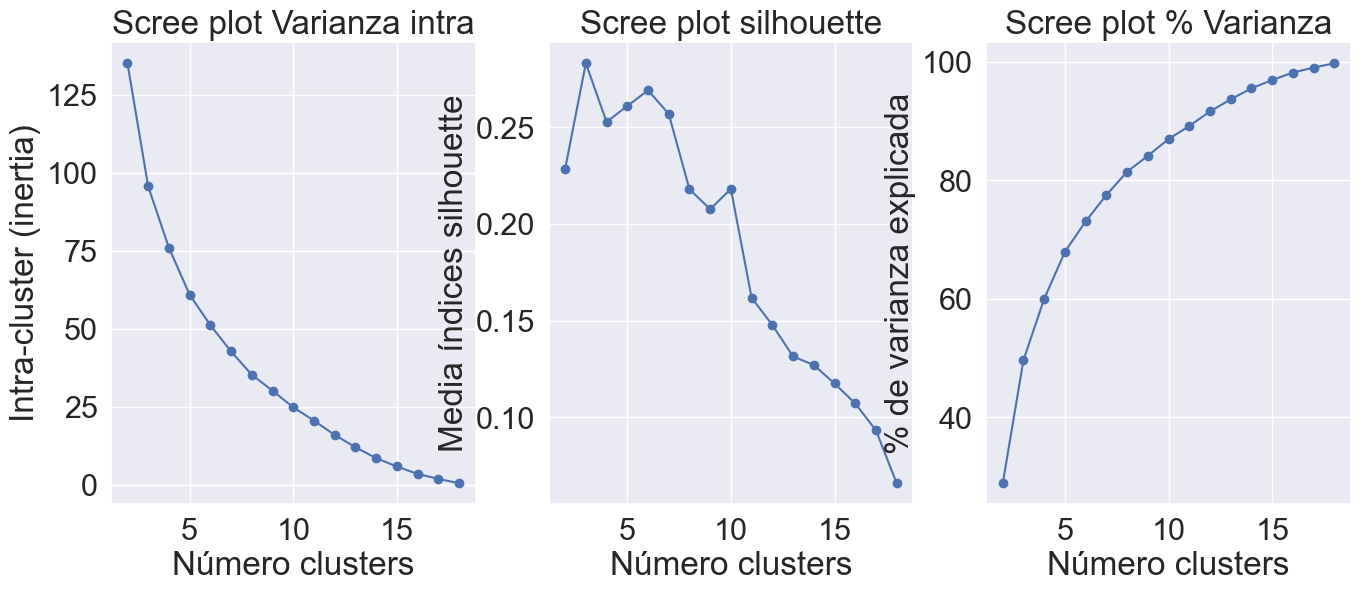

In [109]:
scree_plot_kmeans(datos_ESP_scaled_df,19)
plt.show()

Los picos en el segundo gráfico se dan en 3 clústers o 6. 3 clústers explican alrededor del 50% de la varianza, mientras que 6 están más cerca de explicar el 70%. Pruebo el k-means tanto con 3 clusters como con 6 para decidir cuántos usar. En el primer gáfico no se ve muy claro el "codo" que marcaría el número óptimo de clústers.

In [110]:
modelo_kmeans_3 = KMeans(n_clusters=3, n_init=25, random_state=123)
modelo_kmeans_3.fit(datos_ESP_scaled_df)
print('Varianza intra: ' + str(modelo_kmeans_3.inertia_))

print('Centroides')
print(modelo_kmeans_3.cluster_centers_)

print('Etiquetas')
modelo_kmeans_3.labels_[:5]

Varianza intra: 95.60188097096545
Centroides
[[-0.33860981  0.10486266  0.51269019  0.99452676 -0.98994577  0.42553548
   0.80505265 -0.83374308  0.91953159 -0.47475198]
 [-0.37443269  0.25360073  0.23565165 -1.02563559  1.00262868 -0.56804458
  -0.72436043  0.52100905 -0.64082283 -0.33572882]
 [ 1.34143254 -0.69071111 -1.36851113  0.31084934 -0.27285226  0.39140206
   0.03987873  0.41703229 -0.32753463  1.5022736 ]]
Etiquetas


array([2, 1, 1, 0, 0], dtype=int32)

In [111]:
y_predict_3 = modelo_kmeans_3.predict(datos_ESP_scaled_df)
silhouette_score(datos_ESP_scaled_df, y_predict_3)

0.28316742214343416

In [112]:
modelo_kmeans_6 = KMeans(n_clusters=6, n_init=25, random_state=123)
modelo_kmeans_6.fit(datos_ESP_scaled_df)
print('Varianza intra: ' + str(modelo_kmeans_6.inertia_))

print('Centroides')
print(modelo_kmeans_6.cluster_centers_)

print('Etiquetas')
modelo_kmeans_6.labels_[:5]

Varianza intra: 51.129738516011074
Centroides
[[-0.26782562  0.10177104  0.48889587  1.04092572 -1.16487608  0.5434614
   1.11907838 -0.88393369  0.90748763 -0.42794343]
 [-0.39477977  0.34329958  0.1906499  -0.38978055  0.64211519  0.64009296
  -1.1829415  -0.39870444  0.15346084 -0.36753083]
 [-0.40713658 -0.11096178 -1.78602669 -0.00670004 -0.0925986  -0.18474313
  -0.6252634   1.20912316 -0.27811735 -0.38836089]
 [-0.35619856  0.11581101  0.66542545 -1.36465427  1.30535494 -1.66471487
  -0.38405849  0.94840559 -1.14156862 -0.31266748]
 [ 1.45928773 -1.98781539 -1.13834501  0.12400475 -0.12643999  0.27277843
   0.5753453   0.79438234  0.06233664  1.86783443]
 [ 2.50656477  1.75048574 -0.50893319  0.53757551 -0.36254689  0.66164862
  -0.34663413 -0.90221346 -1.06093327  2.32950673]]
Etiquetas


array([5, 3, 1, 0, 0], dtype=int32)

In [113]:
y_predict_6 = modelo_kmeans_6.predict(datos_ESP_scaled_df)
silhouette_score(datos_ESP_scaled_df, y_predict_6)

0.26916352949286654

Dado que con 3 clusteres tengo un slihouette score más alto voy a continuar con 3 clusters. Ninguno de los dos scores está cerca de ser 1 pero con 2 clústeres parece ser mejor.

A continuación calculo el puntaje de Calinksi Harabasz para los 3 clusters, aunque no es un puntaje muy alto continúo con 3 clusters. 

In [114]:
from sklearn import metrics
metrics.calinski_harabasz_score(datos_ESP_scaled_df, y_predict_3)

7.899268765032233

#### 6. Muestra el biplot (puede ser proyección sobre dos de las variables que resulten relevantes o proyección sobre las dos primeras componentes principales de la matriz de entrada) y comenta los grupos formados. Interpreta los centroides.

In [115]:
from pca import pca

model = pca(normalize=True)

results = model.fit_transform(datos_ESP_scaled_df)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [10] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [116]:
model.results['loadings']

TotalCensus  Izda_Pct  Dcha_Pct  Age_19_65_pct  Age_over65_pct  \
PC1    -0.063116 -0.023971  0.016936      -0.456574        0.465697   
PC2     0.554247 -0.321520 -0.421350       0.038966       -0.000408   
PC3     0.205442  0.618931 -0.053735      -0.086141        0.204208   
PC4    -0.381982 -0.223988 -0.630274       0.084117       -0.051063   
PC5     0.012034 -0.579100  0.468247      -0.304530        0.181524   
PC6    -0.218714 -0.073507 -0.017615      -0.229690       -0.104001   

     WomanPopulationPtge  ForeignersPtge  IndustryUnemploymentPtge  \
PC1            -0.366278       -0.320015                  0.400465   
PC2             0.127575        0.008010                  0.190716   
PC3             0.339938       -0.493686                 -0.370174   
PC4             0.262281       -0.441484                  0.147865   
PC5             0.330581       -0.265860                 -0.195006   
PC6             0.578399        0.311924                 -0.091554   

     ServicesUnemploymentPtge  totalEmpresas  
PC1                 -0.415127      -0.023453  
PC2                 -0.094329       0.590569  
PC3                 -0.030816       0.159525  
PC4                  0.163498      -0.291025  
PC5                  0.310340       0.072463  
PC6                 -0.664239      -0.037947

[pca] >Plot PC1 vs PC2 with loadings.


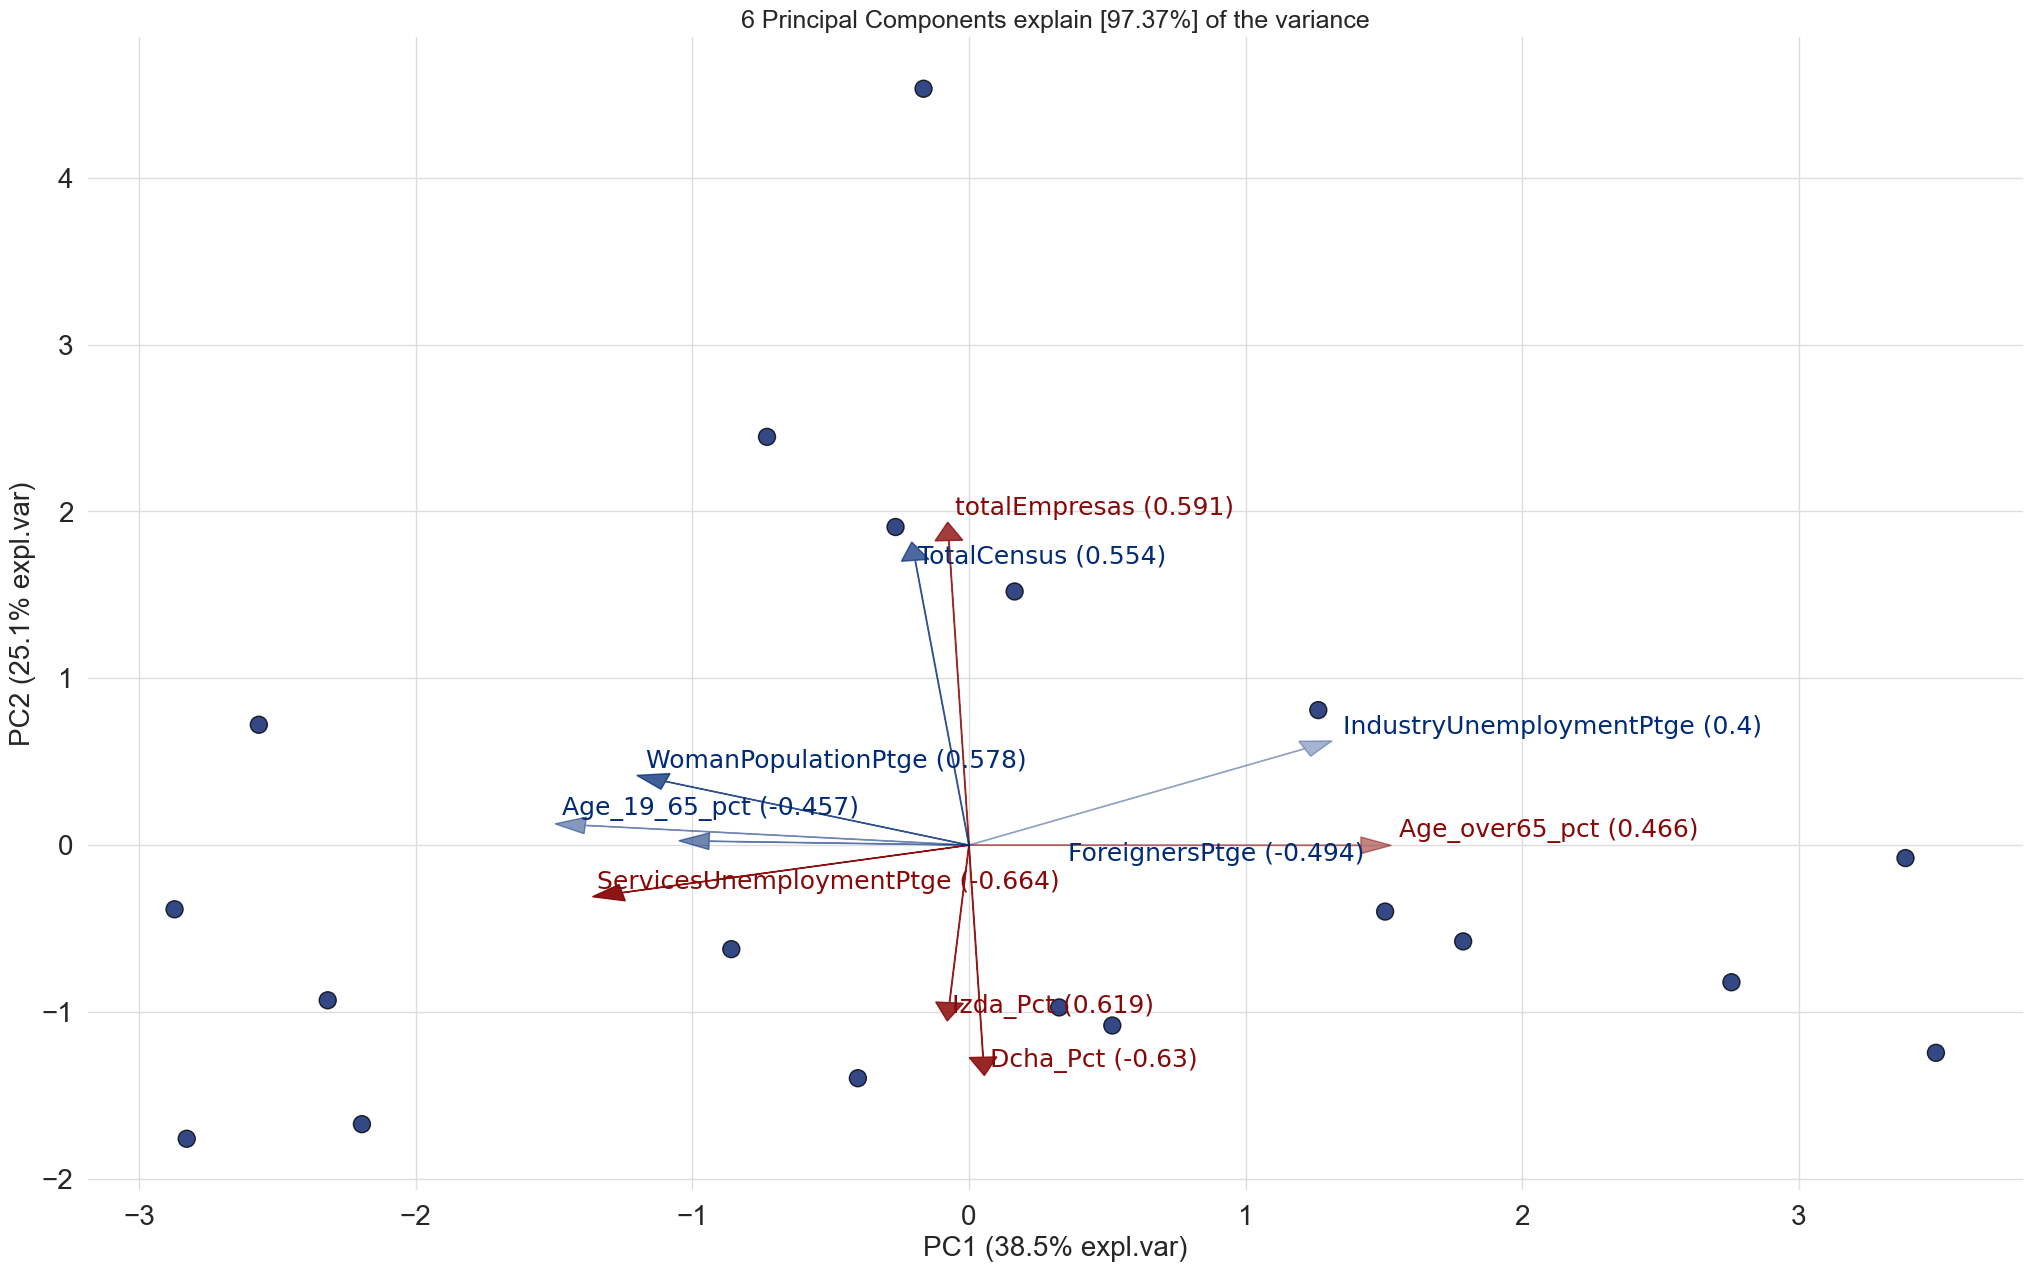

In [117]:
model.biplot(legend=False)
plt.show()

In [118]:
df_pc=model.results['PC']

In [119]:
datos_finales= pd.merge(datos_ESP_scaled_df, df_pc, left_index=True, right_index=True, how='left')

A continuación hago un gráfico que marque mejor los 3 clusters en el plano de los dos componentes principales.

In [120]:
datos_finales['cluster'] = y_predict_3
fig = px.scatter(datos_finales, x='PC1',y='PC2', color='cluster', text=datos_finales.index)
fig.show()

El cluster 0 se caracteriza por tener puntuaciones en negativas en ambos componentes, excepto por madrid que tiene puntuación positiva para el PC2. Las ciudades que lo componen estás situadas en el 3er cuadrante del gráfico.

El cluster 1 está compuesto por comunidades autónomas que tienen valores positivos en componente 1 y negativos para el 2, excepto por galicia que tiene valores positivos para el PC2. 

El cluster 2 tiene puntuaciones en torno al 0 para el componente 1 y altas para el componente 2. Está compuesto por Andalucía, Cataluña, la comunidad valenciana y el País Vasco. 

Voy a graficar las cargas de los componentes así puedo interpretar mejor cada uno de los custers.

In [121]:
datos_finales ['cluster']

CCAA
Andalucía         2
Aragón            1
Asturias          1
Baleares          0
Canarias          0
Cantabria         0
CastillaLeón      1
CastillaMancha    1
Cataluña          2
Ceuta             0
ComValenciana     2
Extremadura       1
Galicia           1
Madrid            0
Melilla           0
Murcia            0
Navarra           1
PaísVasco         2
Rioja             1
Name: cluster, dtype: int32

In [122]:
pca = PCA(n_components=2)
scores = pca.fit_transform(datos_ESP_scaled_df)
scores_df = pd.DataFrame(scores ,index=datos_ESP_scaled_df.index)
scores_df.rename(columns={0: 'CP1', 1: 'CP2'}, inplace=True)

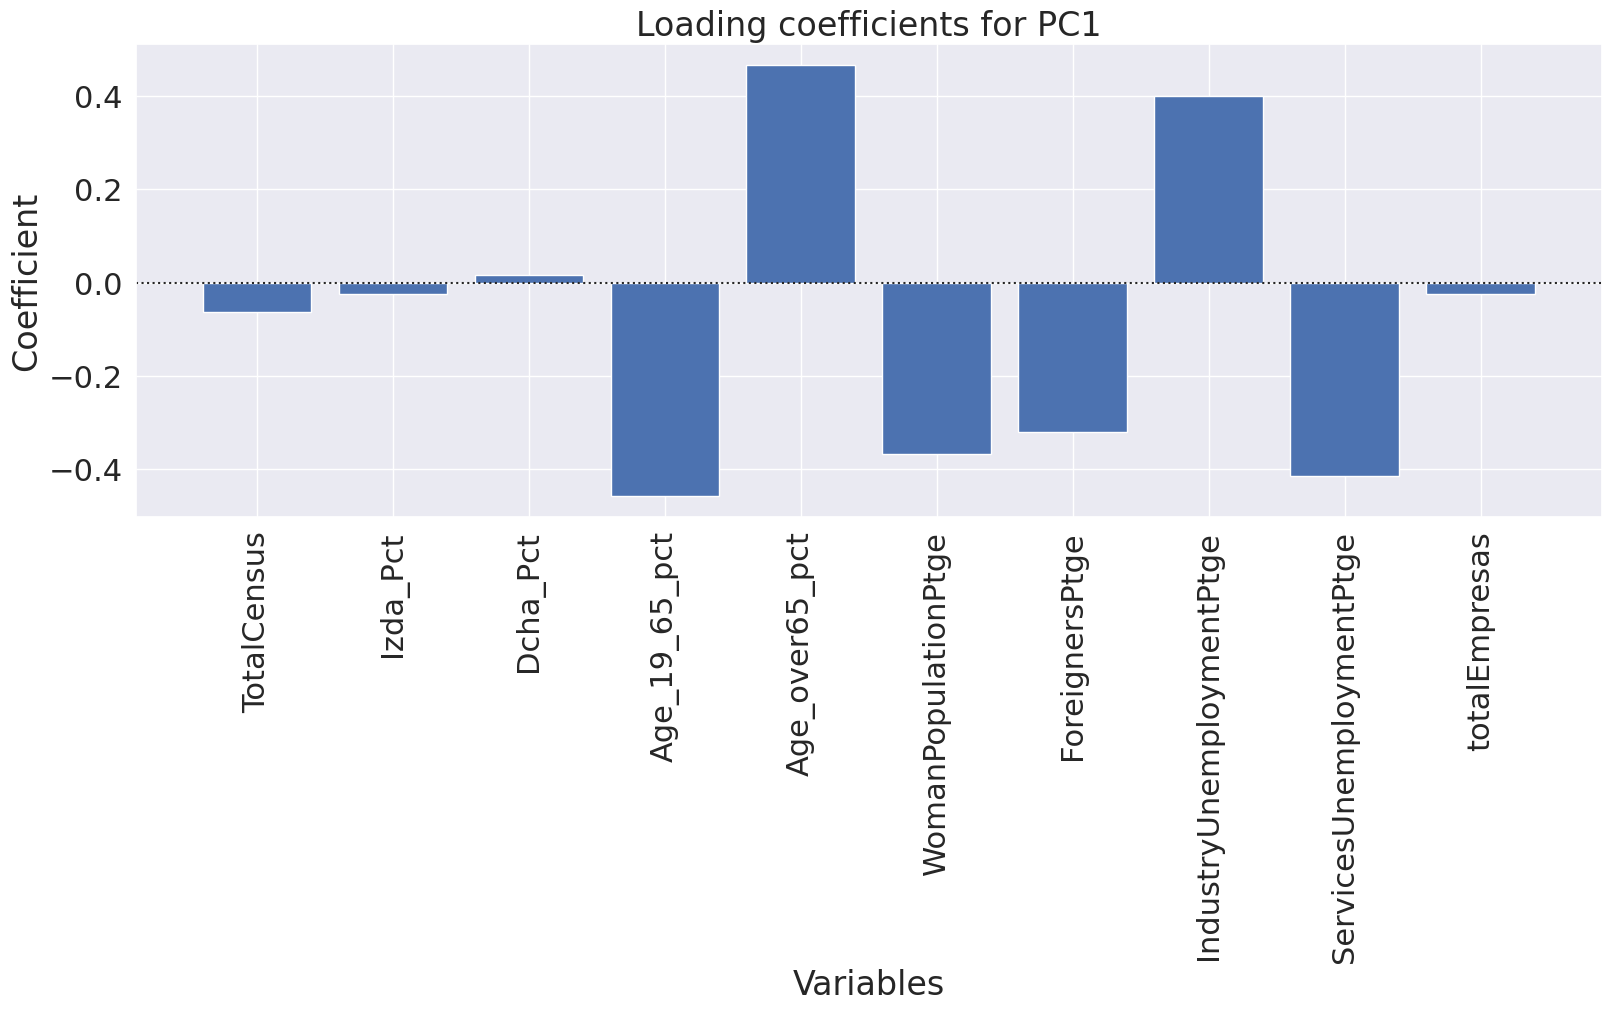

In [123]:
pca_1d_loadings(
        pca,
        datos_ESP_scaled_df.columns,
        select_components={1},
        plot_type='bar',
    )
plt.show()

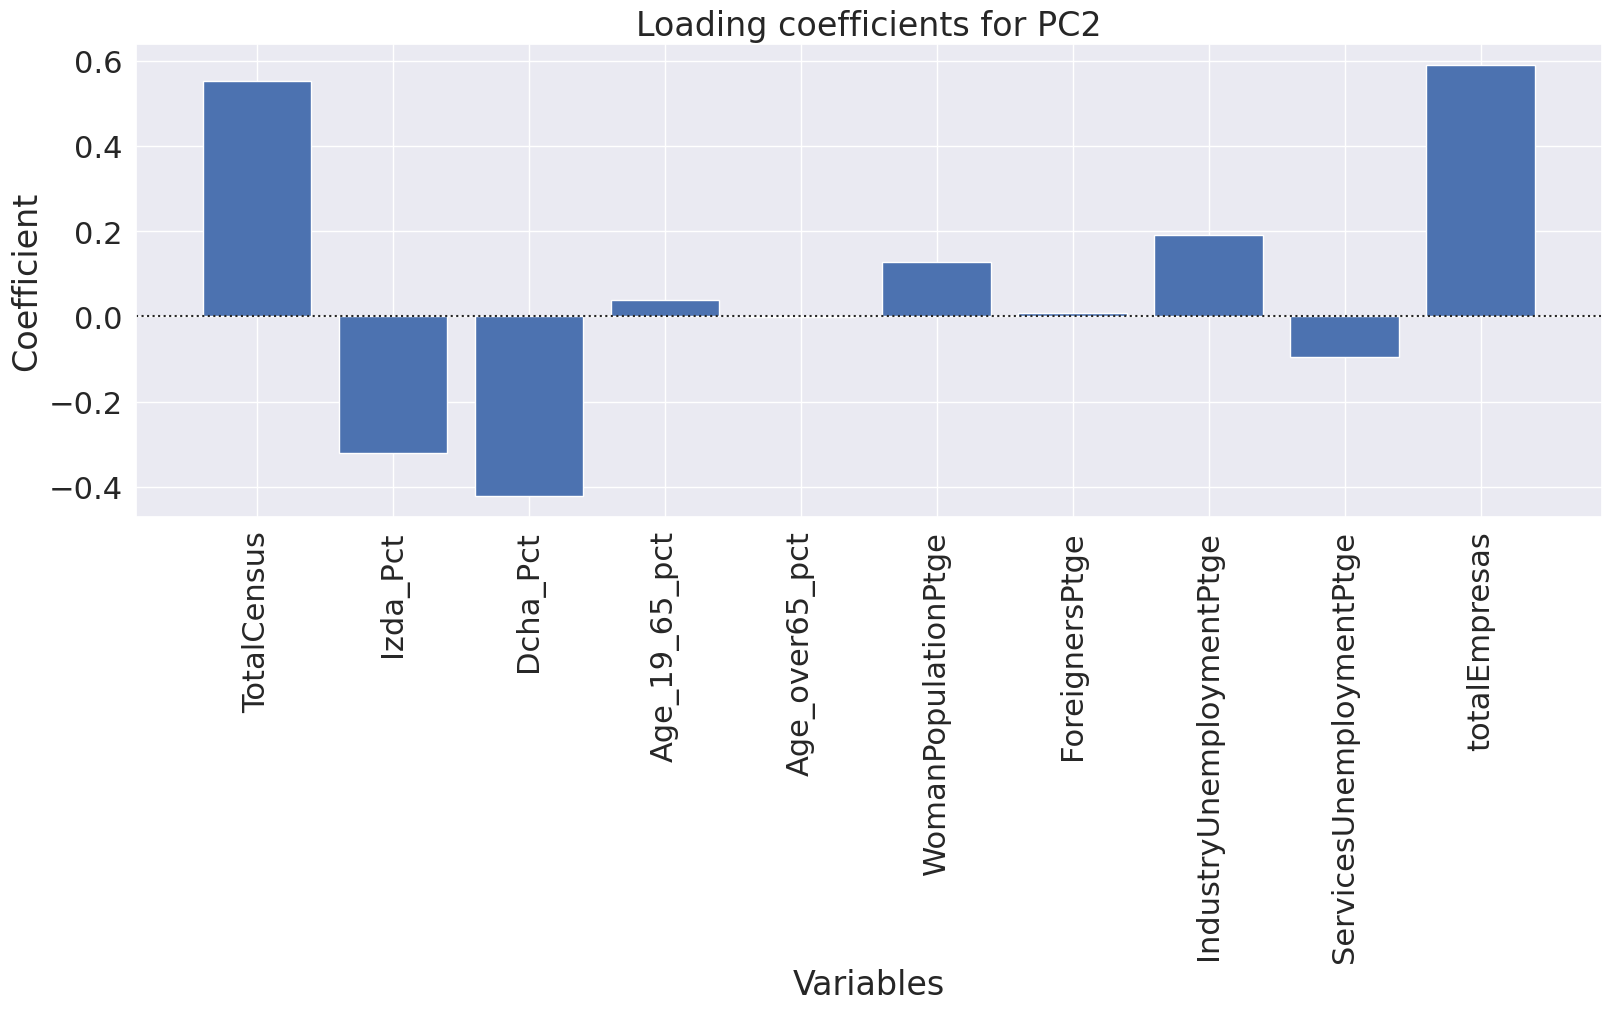

In [124]:
pca_1d_loadings(
        pca,
        datos_ESP_scaled_df.columns,
        select_components={2},
        plot_type='bar',
    )
plt.show()

El componente 1 está ligado a las características de la población, está compuesto por las edades y los grupos que la componen como mujeres y extrajeros. El componente 2 esta ligado al tamaño o desarrollo de las localidades ya que esta ligado a el tamaño de la población y la cantidad de empresas. 

El cluster 0 son comunidades autónomas con baja población encima de 65 años, muchos inmigrantes, y poco desempleo industrial. 

El cluster 1 son comunidades autónomas con alta población por encima de los 65 años, pocos inmigrantes y mucho desempleo industrial. A su vez tienen pocas empresas y poca población en edad de votar.

El cluster 2 se caracteriza por comunidades autónomas que no están en niguno de los extremos, es decir tienen valores medios para la población por encima de 65 años, la cantidad de inmigrantes y el desempleo. 